In [1]:
# ----------------------------------------------------
# CELL 1: DATA DOWNLOAD
# ----------------------------------------------------
# Install the gdown library to download files from Google Drive
!pip install gdown -q

# The File ID from your Google Drive share link
file_id = '1vdoiChLttG5NnOUcPqj-wiD5-URpc_8U'
output_filename = 'MODEL_READY_CONSTRUCTION_DATA.csv'

# Download the file
!gdown --id {file_id} -O {output_filename}

# Verify the download by listing the files in the current directory
# You should see 'MODEL_READY_CONSTRUCTION_DATA.csv' listed with a large file size.
print("\n--- Download Verification ---")
!ls -lh

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1vdoiChLttG5NnOUcPqj-wiD5-URpc_8U
From (redirected): https://drive.google.com/uc?id=1vdoiChLttG5NnOUcPqj-wiD5-URpc_8U&confirm=t&uuid=1bf2202f-887a-425f-8b22-759632c9e5f4
To: /kaggle/working/MODEL_READY_CONSTRUCTION_DATA.csv
100%|███████████████████████████████████████| 5.16G/5.16G [00:41<00:00, 123MB/s]

--- Download Verification ---
total 4.9G
-rw-r--r-- 1 root root 4.9G Oct  7 07:16 MODEL_READY_CONSTRUCTION_DATA.csv


In [2]:
# =============================================================================
# CHUNK 0: PROJECT INITIALIZATION AND COMMITMENT TO REPRODUCIBILITY
# =============================================================================

# -----------------------------------------------------------------------------
# 1. Import Core Libraries
# -----------------------------------------------------------------------------
# Standard Libraries
import os
import random
import warnings
import sys # Added for system-level commands like sys.exit()

# Data Manipulation and Analysis
import numpy as np
import pandas as pd

# Machine Learning Framework (PyTorch)
import torch
import torch.nn as nn
import torch.optim as optim

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
from tqdm.notebook import tqdm # <-- CORRECTED: Added the missing import
import gc

# Suppress minor warnings for cleaner output
warnings.filterwarnings('ignore')

# -----------------------------------------------------------------------------
# 2. Establish Global Configuration for Reproducibility
# -----------------------------------------------------------------------------
# A single, global random seed is defined to ensure that all stochastic 
# processes (e.g., model weight initialization, data shuffling, synthetic
# sample generation) are deterministic.
RANDOM_SEED = 42

def set_seed(seed: int):
    """
    Sets the random seed for NumPy, Python's random module, and PyTorch
    to ensure deterministic behavior.
    
    Args:
        seed (int): The integer value for the seed.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # The following two lines are often needed for full reproducibility with CUDA
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Apply the global seed
set_seed(RANDOM_SEED)

# -----------------------------------------------------------------------------
# 3. Configure Computational Environment (Device Agnostic)
# -----------------------------------------------------------------------------
# The code is designed to run on either a CPU or a CUDA-enabled GPU.
# This ensures the framework is accessible and its performance can be scaled.
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------------------------------------------------------
# 4. Define Global Helper Functions & Visualization Settings
# -----------------------------------------------------------------------------
# Set a consistent and professional style for all plots generated in this notebook.
sns.set_theme(style="whitegrid", palette="colorblind")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

def print_setup_summary():
    """
    Prints a summary of the key configuration parameters for the record.
    This is logged at the start of an experiment to document the environment.
    """
    print("=" * 60)
    print("      Computational Environment and Reproducibility Setup")
    print("=" * 60)
    print(f"PyTorch Version:          {torch.__version__}")
    print(f"Execution Device:         {DEVICE}")
    print(f"Global Random Seed:       {RANDOM_SEED}")
    print(f"Reproducibility Seed Set:  {'Yes'}")
    print("=" * 60)
    
# Execute the summary function to confirm setup
print_setup_summary()

# Clean up memory
gc.collect()

      Computational Environment and Reproducibility Setup
PyTorch Version:          2.6.0+cu124
Execution Device:         cuda
Global Random Seed:       42
Reproducibility Seed Set:  Yes


0

In [79]:
# =============================================================================
# CHUNK 1 (SCALABLE REVISION): DATA PREPARATION AND PERSISTENCE
# =============================================================================

import pandas as pd
import numpy as np
import os
import gc

# -----------------------------------------------------------------------------
# 1. Define Configuration and File Paths
# -----------------------------------------------------------------------------
# Input data file
INPUT_FILE_PATH = 'MODEL_READY_CONSTRUCTION_DATA.csv'

# Output directory for processed client data
OUTPUT_DIR = 'processed_client_data'
os.makedirs(OUTPUT_DIR, exist_ok=True) # Create the directory if it doesn't exist

# Columns required for the entire analysis
REQUIRED_COLUMNS = [
    'tender_id', 'buyer_id', 'bidder_id', 'buyer_country', 'buyer_nuts_3', 'bidder_nuts_3',
    'bid_priceUsd', 'corr_buyer_concentration', 'submission_period',
    'decision_period', 'tender_estimatedpriceUsd', 'tender_lotscount',
    'tender_recordedbidscount', 'filter_ok', 'bid_iswinning'
]

# Data types for efficient loading
DTYPE_MAP = {
    'bid_priceUsd': 'float32', 'corr_buyer_concentration': 'float32',
    'submission_period': 'float32', 'decision_period': 'float32',
    'tender_estimatedpriceUsd': 'float32', 'tender_lotscount': 'float32',
    'tender_recordedbidscount': 'float32'
}

# -----------------------------------------------------------------------------
# 2. Forensic Data Loading and Step-wise Filtering
# -----------------------------------------------------------------------------
print("--- Starting Forensic Analysis and Data Preparation ---")

try:
    print(f"\n[1] Loading data from '{INPUT_FILE_PATH}'...")
    df_master = pd.read_csv(INPUT_FILE_PATH, usecols=REQUIRED_COLUMNS, dtype=DTYPE_MAP, low_memory=True)
    initial_rows = len(df_master)
    print(f"    Initial records loaded: {initial_rows:,}")

    print("\n[2] Coercing boolean-like columns...")
    df_master['filter_ok'] = df_master['filter_ok'].astype(str).str.lower().map({'true': True, 'false': False, 't': True, 'f': False})
    df_master['bid_iswinning'] = df_master['bid_iswinning'].astype(str).str.lower().map({'true': True, 'false': False, 't': True, 'f': False})

    print("\n[3] Applying scope filter ('filter_ok == True')...")
    df_scoped = df_master[df_master['filter_ok'] == True].copy()
    del df_master
    gc.collect()

    print("\n[4] Applying NaN filter on key features and outcome variable...")
    features_to_check_na = [
        'bid_priceUsd', 'corr_buyer_concentration', 'tender_estimatedpriceUsd',
        'buyer_country', 'buyer_nuts_3', 'bidder_nuts_3', 'bid_iswinning'
    ]
    df_scoped.dropna(subset=features_to_check_na, inplace=True)
    df_scoped['bid_iswinning'] = df_scoped['bid_iswinning'].astype(bool)

    winning_bids_after_na = int(df_scoped['bid_iswinning'].sum())
    print(f"    Total viable records after all filters: {len(df_scoped):,}")
    print(f"    Containing winning bids: {winning_bids_after_na:,}")

    # -----------------------------------------------------------------------------
    # 3. Final Sample Identification and Persistence to Disk
    # -----------------------------------------------------------------------------
    print("\n[5] Identifying eligible clients and persisting data to disk...")
    MIN_DEMONSTRATIONS_PER_CLIENT = 1
    df_final = df_scoped.copy()
    del df_scoped
    gc.collect()

    # We only care about winning bids for identifying eligible clients
    winning_bids_df = df_final[df_final['bid_iswinning']].copy()
    winning_bid_counts_by_country = winning_bids_df['buyer_country'].value_counts()
    eligible_countries = winning_bid_counts_by_country[winning_bid_counts_by_country >= MIN_DEMONSTRATIONS_PER_CLIENT].index.tolist()

    if not eligible_countries:
        print("\n--- Analysis Complete: INSUFFICIENT DATA PER CLIENT ---")
        raise SystemExit(f"No client contains the minimum required {MIN_DEMONSTRATIONS_PER_CLIENT} winning bids.")
    else:
        print(f"    Identified {len(eligible_countries)} eligible clients.")
        df_federated = df_final[df_final['buyer_country'].isin(eligible_countries)].copy()
        
        # This list will be the output of this chunk
        client_data_filepaths = []
        
        print(f"\n[6] Saving processed data for each client to '{OUTPUT_DIR}' directory...")
        for country, group_df in tqdm(df_federated.groupby('buyer_country'), desc="Saving client data"):
            client_name = f"client_{country}"
            filepath = os.path.join(OUTPUT_DIR, f"{client_name}.csv")
            
            # Save the client's data to its own CSV file
            group_df.to_csv(filepath, index=False)
            client_data_filepaths.append(filepath)

            wins = int(group_df['bid_iswinning'].sum())
            total = len(group_df)
            # print(f"  - Saved {client_name}.csv: {total:,} records ({wins:,} winning bids)") # Optional: for verbose logging

        print("\n--- Data Preparation and Persistence Complete ---")
        print(f"Successfully saved data for {len(client_data_filepaths)} clients.")
        print(f"The variable `client_data_filepaths` now contains the list of paths to these files.")

except FileNotFoundError:
    print(f"Error: The file '{INPUT_FILE_PATH}' was not found. Halting execution.")
except SystemExit as e:
    print(f"\nEXECUTION HALTED: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
finally:
    # Clean up all large DataFrames from memory
    for var in ['df_master', 'df_scoped', 'df_final', 'df_federated', 'winning_bids_df']:
        if var in locals():
            del locals()[var]
    gc.collect()

--- Starting Forensic Analysis and Data Preparation ---

[1] Loading data from 'MODEL_READY_CONSTRUCTION_DATA.csv'...
    Initial records loaded: 4,337,081

[2] Coercing boolean-like columns...

[3] Applying scope filter ('filter_ok == True')...

[4] Applying NaN filter on key features and outcome variable...
    Total viable records after all filters: 128,466
    Containing winning bids: 128,466

[5] Identifying eligible clients and persisting data to disk...
    Identified 28 eligible clients.

[6] Saving processed data for each client to 'processed_client_data' directory...


Saving client data:   0%|          | 0/28 [00:00<?, ?it/s]


--- Data Preparation and Persistence Complete ---
Successfully saved data for 28 clients.
The variable `client_data_filepaths` now contains the list of paths to these files.


In [80]:
# =============================================================================
# CHUNK 2 (DEFINITIVE VERSION 2.1): DUAL-SCALER DATA PREPARATION
# =============================================================================
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import torch
import os
import gc
from tqdm.notebook import tqdm

print("--- Starting Data Processing with Dual Scalers ---")

# (Feature set definitions remain the same)
STATE_FEATURES = [
    'corr_buyer_concentration', 'submission_period', 'decision_period',
    'tender_lotscount', 'tender_recordedbidscount'
]
ACTION_FEATURES = [
    'price_ratio', 'is_local_bidder', 'price_ratio_sq'
]
BASE_FEATURES_RAW = [
    'tender_id', 'buyer_id', 'bidder_id', 'buyer_country', 'buyer_nuts_3', 'bidder_nuts_3',
    'bid_priceUsd', 'corr_buyer_concentration', 'submission_period',
    'decision_period', 'tender_estimatedpriceUsd', 'tender_lotscount',
    'tender_recordedbidscount', 'bid_iswinning'
]

# (Data processing and feature engineering loop remains the same)
all_demonstrations_list = []
for filepath in tqdm(client_data_filepaths, desc="Engineering Features for Clients"):
    client_df = pd.read_csv(filepath, usecols=BASE_FEATURES_RAW)
    client_df['is_local_bidder'] = (client_df['buyer_nuts_3'].astype(str) == client_df['bidder_nuts_3'].astype(str)).astype(int)
    epsilon = 1e-6
    client_df['price_ratio'] = client_df['bid_priceUsd'] / (client_df['tender_estimatedpriceUsd'] + epsilon)
    demonstrations = client_df[client_df['bid_iswinning']].copy()
    demonstrations.dropna(subset=STATE_FEATURES + ['price_ratio', 'is_local_bidder'], inplace=True)
    demonstrations = demonstrations[(demonstrations['price_ratio'] > 0) & (demonstrations['price_ratio'] < 5) & np.isfinite(demonstrations['price_ratio'])]
    if demonstrations.empty: continue
    demonstrations['price_ratio_sq'] = demonstrations['price_ratio']**2
    all_demonstrations_list.append(demonstrations)

combined_demonstrations_df = pd.concat(all_demonstrations_list, ignore_index=True)
del all_demonstrations_list
gc.collect()

# --- CRITICAL CHANGE: Fit two separate scalers ---
state_scaler = StandardScaler()
action_scaler = StandardScaler()

print(f"\nFitting separate scalers on {len(combined_demonstrations_df):,} demonstrations...")
state_scaler.fit(combined_demonstrations_df[STATE_FEATURES])
action_scaler.fit(combined_demonstrations_df[ACTION_FEATURES])
print("State and Action scalers fitted successfully.")

client_data_tensors = {}
for client_name, group_df in tqdm(combined_demonstrations_df.groupby('buyer_country'), desc="Creating Final Tensors"):
    client_key = f"client_{client_name}"
    
    # Apply the correct scaler to each part of the data
    scaled_states_np = state_scaler.transform(group_df[STATE_FEATURES])
    scaled_actions_np = action_scaler.transform(group_df[ACTION_FEATURES])
    
    client_data_tensors[client_key] = {
        'states': torch.tensor(scaled_states_np, dtype=torch.float32).to(DEVICE),
        'actions': torch.tensor(scaled_actions_np, dtype=torch.float32).to(DEVICE)
    }

del combined_demonstrations_df
gc.collect()

# (Finalize and Report section remains the same)
first_client_key = next(iter(client_data_tensors))
STATE_DIM = client_data_tensors[first_client_key]['states'].shape[1]
ACTION_DIM = client_data_tensors[first_client_key]['actions'].shape[1]
print("\n--- State-Action Space Formulation Complete ---")
print(f"State Scaler ready: `state_scaler`")
print(f"Action Scaler ready: `action_scaler`")
print(f"Final State Features:  {STATE_FEATURES}")
print(f"Final Action Features: {ACTION_FEATURES}")
print("=" * 60)

--- Starting Data Processing with Dual Scalers ---


Engineering Features for Clients:   0%|          | 0/28 [00:00<?, ?it/s]


Fitting separate scalers on 55,333 demonstrations...
State and Action scalers fitted successfully.


Creating Final Tensors:   0%|          | 0/25 [00:00<?, ?it/s]


--- State-Action Space Formulation Complete ---
State Scaler ready: `state_scaler`
Action Scaler ready: `action_scaler`
Final State Features:  ['corr_buyer_concentration', 'submission_period', 'decision_period', 'tender_lotscount', 'tender_recordedbidscount']
Final Action Features: ['price_ratio', 'is_local_bidder', 'price_ratio_sq']


In [81]:
import torch
import torch.nn as nn
import numpy as np

class RewardModel(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(RewardModel, self).__init__()
        self.model = nn.Linear(state_dim + action_dim, 1)

    def forward(self, state, action):
        state_action = torch.cat([state, action], dim=1)
        return self.model(state_action)

def generate_synthetic_actions(expert_actions, k):
    num_demos, action_dim = expert_actions.shape
    device = expert_actions.device
    
    synthetic_actions = torch.zeros(num_demos, k, action_dim, device=device)
    
    # price_ratio: feature 0
    synthetic_actions[:, :, 0] = torch.rand(num_demos, k, device=device) * 1.2 + 0.8
    
    # is_local_bidder: feature 1
    synthetic_actions[:, :, 1] = torch.bernoulli(torch.full((num_demos, k), 0.5, device=device))
    
    return synthetic_actions

def max_ent_irl_loss(reward_model, states, expert_actions, synthetic_actions):
    num_demos = states.shape[0]
    k = synthetic_actions.shape[1]
    
    expert_rewards = reward_model(states, expert_actions)

    states_repeated = states.repeat_interleave(k, dim=0)
    actions_flattened = synthetic_actions.view(-1, ACTION_DIM)
    
    synthetic_rewards = reward_model(states_repeated, actions_flattened).view(num_demos, k)

    # Corrected line: expert_rewards is already (N, 1), no unsqueeze needed.
    all_rewards = torch.cat([expert_rewards, synthetic_rewards], dim=1)
    
    log_partition_func = torch.logsumexp(all_rewards, dim=1)
    
    loss = log_partition_func - expert_rewards.squeeze(1)
    
    return loss.mean()

K_SAMPLES = 10
global_reward_model = RewardModel(STATE_DIM, ACTION_DIM).to(DEVICE)

test_client_key = next(iter(client_data_tensors))
test_data = client_data_tensors[test_client_key]
states_e = test_data['states']
actions_e = test_data['actions']

actions_s = generate_synthetic_actions(actions_e, k=K_SAMPLES)

loss = max_ent_irl_loss(global_reward_model, states_e, actions_e, actions_s)

print("--- IRL Model and Loss Function Demonstration ---")
print(f"Using test data from: {test_client_key}")
print(f"  State tensor shape:       {states_e.shape}")
print(f"  Expert action shape:    {actions_e.shape}")
print(f"  Synthetic action shape: {actions_s.shape}")
print(f"\nReward Model Architecture:\n{global_reward_model}")
print(f"\nCalculated Initial Loss: {loss.item():.4f}")
print("="*50)
print("Components are verified and ready for the federated training loop.")

--- IRL Model and Loss Function Demonstration ---
Using test data from: client_AT
  State tensor shape:       torch.Size([597, 5])
  Expert action shape:    torch.Size([597, 3])
  Synthetic action shape: torch.Size([597, 10, 3])

Reward Model Architecture:
RewardModel(
  (model): Linear(in_features=8, out_features=1, bias=True)
)

Calculated Initial Loss: 2.3894
Components are verified and ready for the federated training loop.


In [82]:
# =============================================================================
# CHUNK 4: FEDERATED LEARNING LOGIC AND PRIVACY CONSIDERATIONS
# =============================================================================
import torch
import torch.optim as optim
from collections import OrderedDict
import copy

# -----------------------------------------------------------------------------
# 1. Client-Side Training Function
# -----------------------------------------------------------------------------
def client_update(client_model, optimizer, client_data, local_epochs, k_samples):
    """
    Simulates the training process on a single client's private data.

    Args:
        client_model (nn.Module): A copy of the global model for local training.
        optimizer (torch.optim.Optimizer): The optimizer for the client model.
        client_data (dict): A dictionary containing 'states' and 'actions' tensors.
        local_epochs (int): The number of training epochs to perform locally.
        k_samples (int): The number of synthetic actions to generate per expert action.

    Returns:
        tuple: (The updated model's state dictionary, average loss for the client).
    """
    client_model.train()
    total_loss = 0.0
    
    # Extract the client's private data
    expert_states = client_data['states']
    expert_actions = client_data['actions']
    
    for epoch in range(local_epochs):
        optimizer.zero_grad()
        
        # Generate synthetic negative samples for the MaxEnt loss calculation
        synthetic_actions = generate_synthetic_actions(expert_actions, k=k_samples)
        
        # Calculate loss on the client's data
        loss = max_ent_irl_loss(client_model, expert_states, expert_actions, synthetic_actions)
        
        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    return client_model.state_dict(), total_loss / local_epochs

# -----------------------------------------------------------------------------
# 2. Server-Side Aggregation Function (Federated Averaging)
# -----------------------------------------------------------------------------
def server_aggregate(global_model, client_model_states):
    """
    Aggregates model weights from clients to update the global model.

    Args:
        global_model (nn.Module): The main global model to be updated.
        client_model_states (list): A list of state_dicts from the clients.
    """
    num_clients = len(client_model_states)
    if num_clients == 0:
        return

    # Create a new ordered dictionary to store the averaged weights
    global_state_dict = global_model.state_dict()
    avg_state_dict = OrderedDict()

    # Initialize the average state dict with zeros
    for key in global_state_dict:
        avg_state_dict[key] = torch.zeros_like(global_state_dict[key])

    # Sum the weights from all clients
    for state_dict in client_model_states:
        for key in global_state_dict:
            avg_state_dict[key] += state_dict[key]

    # Average the weights
    for key in global_state_dict:
        avg_state_dict[key] = avg_state_dict[key] / num_clients

    # Load the new averaged weights into the global model
    global_model.load_state_dict(avg_state_dict)

# -----------------------------------------------------------------------------
# 3. Demonstration of the Federated Logic
# -----------------------------------------------------------------------------
print("--- Federated Learning Logic Demonstration ---")

# Hyperparameters for the demonstration
DEMO_LOCAL_EPOCHS = 3
DEMO_LEARNING_RATE = 0.01

# Initialize a fresh global model
demo_global_model = RewardModel(STATE_DIM, ACTION_DIM).to(DEVICE)
initial_weight = demo_global_model.model.weight.data.clone()

# Select a few clients for the demo
demo_client_keys = list(client_data_tensors.keys())[:3]
print(f"Simulating one round of FL with clients: {demo_client_keys}")

client_updates = []

# Simulate the client update step for each client
for client_key in demo_client_keys:
    # Each client gets a copy of the current global model
    local_model = copy.deepcopy(demo_global_model)
    local_optimizer = optim.Adam(local_model.parameters(), lr=DEMO_LEARNING_RATE)
    
    # The client trains on its own private data
    updated_state_dict, client_loss = client_update(
        client_model=local_model,
        optimizer=local_optimizer,
        client_data=client_data_tensors[client_key],
        local_epochs=DEMO_LOCAL_EPOCHS,
        k_samples=K_SAMPLES
    )
    client_updates.append(updated_state_dict)
    print(f"  - Client '{client_key}' finished local training with avg loss: {client_loss:.4f}")

# Simulate the server aggregation step
server_aggregate(demo_global_model, client_updates)
aggregated_weight = demo_global_model.model.weight.data.clone()

print("\nServer aggregation complete.")
print(f"Initial global model weight (sample): {initial_weight[0, :3].cpu().numpy()}")
print(f"Final global model weight (sample):   {aggregated_weight[0, :3].cpu().numpy()}")

# The change in weights confirms that the client updates were successfully aggregated.
weight_change = torch.sum(torch.abs(initial_weight - aggregated_weight)).item()
print(f"Total change in model weights: {weight_change:.6f}")

if weight_change > 0:
    print("\nSUCCESS: The federated logic correctly updated the global model.")
else:
    print("\nFAILURE: The global model was not updated.")

print("="*50)
print("Federated components are verified and ready for the full training loop.")

--- Federated Learning Logic Demonstration ---
Simulating one round of FL with clients: ['client_AT', 'client_BG', 'client_CY']
  - Client 'client_AT' finished local training with avg loss: 2.0406
  - Client 'client_BG' finished local training with avg loss: 2.0595
  - Client 'client_CY' finished local training with avg loss: 2.3700

Server aggregation complete.
Initial global model weight (sample): [-0.23963071 -0.10405981  0.11399525]
Final global model weight (sample):   [-0.22934607 -0.10271805  0.11134305]
Total change in model weights: 0.065375

SUCCESS: The federated logic correctly updated the global model.
Federated components are verified and ready for the full training loop.


--- Starting Federated Inverse Reinforcement Learning Training ---
Total Communication Rounds: 50
Clients participating per round: 20
Local epochs per client: 50


Federated Training:   0%|          | 0/50 [00:00<?, ?it/s]


--- Federated Training Complete ---


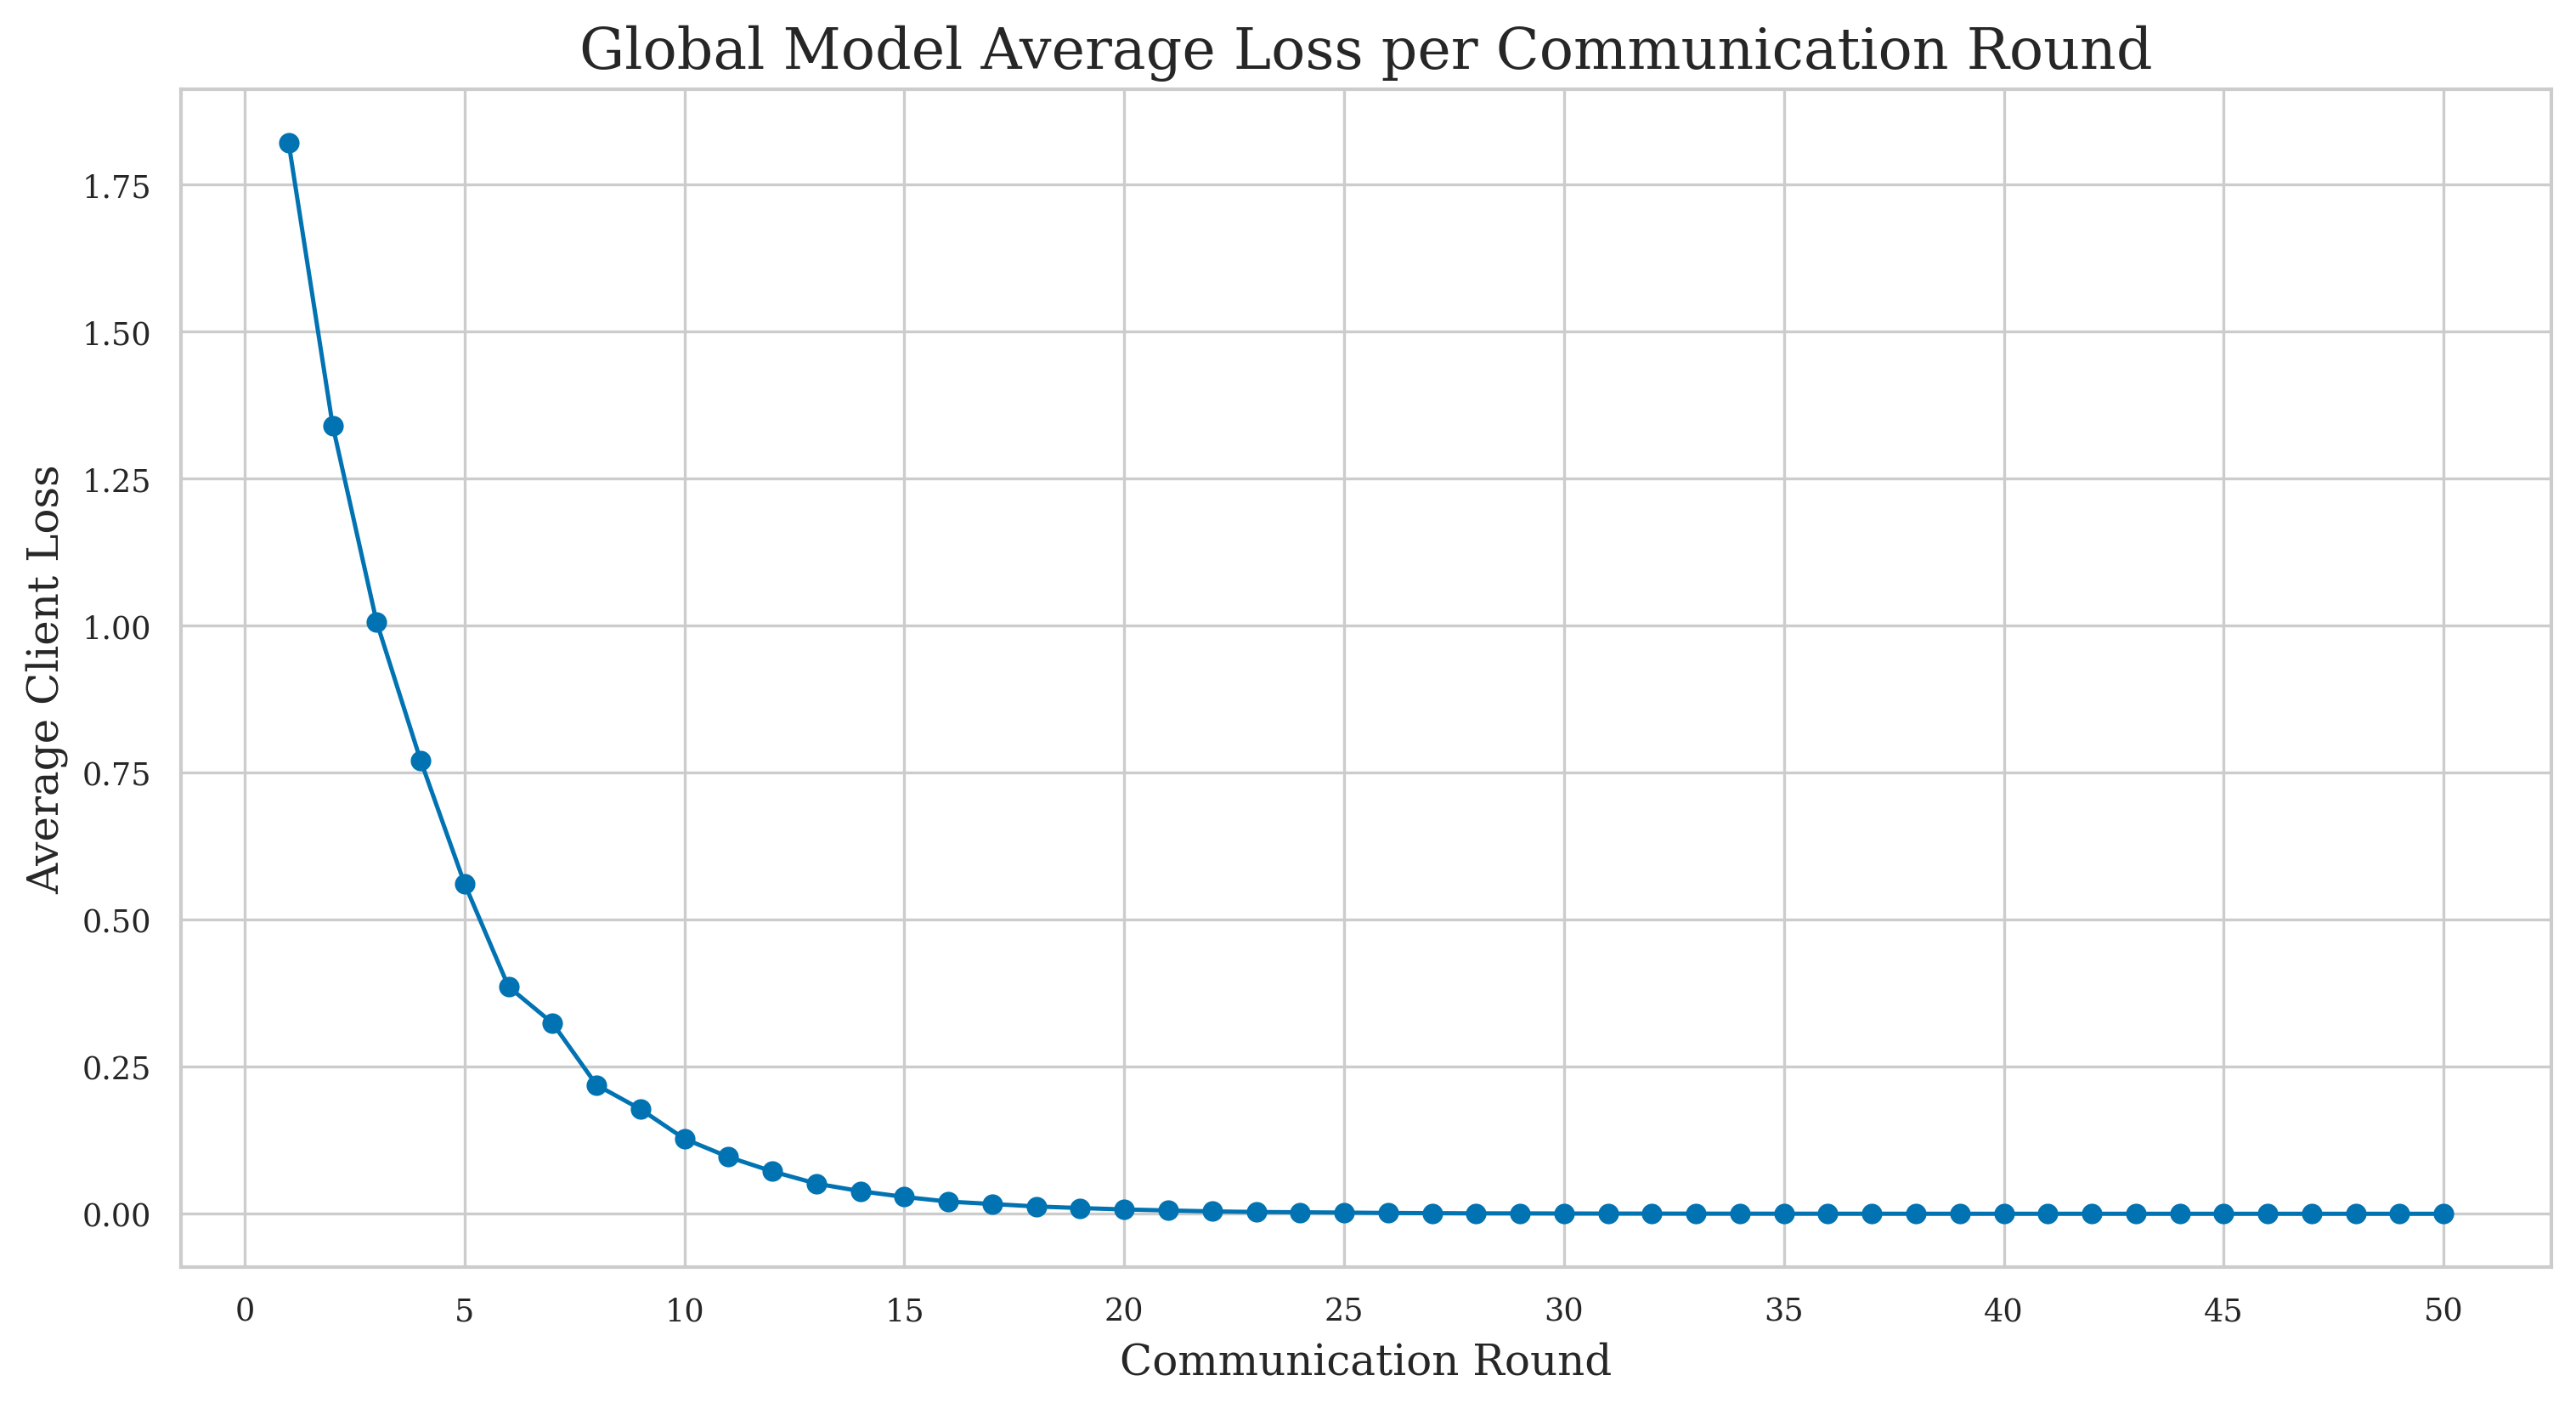


Final converged model `global_reward_model` is now ready for validation and interpretation.


In [86]:
# =============================================================================
# CHUNK 5: EXECUTION OF THE FED-IRL TRAINING LOOP
# =============================================================================
import torch
import torch.optim as optim
import numpy as np
import random
import copy
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# 1. Define Training Hyperparameters
# -----------------------------------------------------------------------------
COMMUNICATION_ROUNDS = 50
CLIENTS_PER_ROUND = 20
LOCAL_EPOCHS = 50
LEARNING_RATE = 0.01
K_SAMPLES = 10

# -----------------------------------------------------------------------------
# 2. Initialize the Global Model and Training History
# -----------------------------------------------------------------------------
global_reward_model = RewardModel(STATE_DIM, ACTION_DIM).to(DEVICE)
all_client_keys = list(client_data_tensors.keys())
global_loss_history = []

print("--- Starting Federated Inverse Reinforcement Learning Training ---")
print(f"Total Communication Rounds: {COMMUNICATION_ROUNDS}")
print(f"Clients participating per round: {CLIENTS_PER_ROUND}")
print(f"Local epochs per client: {LOCAL_EPOCHS}")
print("="*60)

# -----------------------------------------------------------------------------
# 3. Main Federated Training Loop
# -----------------------------------------------------------------------------
progress_bar = tqdm(range(COMMUNICATION_ROUNDS), desc="Federated Training")

for round_num in progress_bar:
    
    selected_clients = random.sample(all_client_keys, CLIENTS_PER_ROUND)
    
    client_model_updates = []
    round_losses = []
    
    for client_key in selected_clients:
        
        local_model = copy.deepcopy(global_reward_model)
        local_optimizer = optim.Adam(local_model.parameters(), lr=LEARNING_RATE)
        client_data = client_data_tensors[client_key]
        
        updated_state_dict, client_avg_loss = client_update(
            client_model=local_model,
            optimizer=local_optimizer,
            client_data=client_data,
            local_epochs=LOCAL_EPOCHS,
            k_samples=K_SAMPLES
        )
        
        client_model_updates.append(updated_state_dict)
        round_losses.append(client_avg_loss)

    if client_model_updates:
        server_aggregate(global_reward_model, client_model_updates)
        
        avg_round_loss = np.mean(round_losses)
        global_loss_history.append(avg_round_loss)
        
        progress_bar.set_postfix({'Avg Round Loss': f'{avg_round_loss:.4f}'})

print("\n--- Federated Training Complete ---")

# -----------------------------------------------------------------------------
# 4. Plot the Global Loss Curve
# -----------------------------------------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(range(1, COMMUNICATION_ROUNDS + 1), global_loss_history, marker='o', linestyle='-')
plt.title('Global Model Average Loss per Communication Round', fontsize=16)
plt.xlabel('Communication Round', fontsize=12)
plt.ylabel('Average Client Loss', fontsize=12)
plt.grid(True)
plt.xticks(np.arange(0, COMMUNICATION_ROUNDS + 1, 5))
plt.show()

print("\nFinal converged model `global_reward_model` is now ready for validation and interpretation.")

In [87]:
# =============================================================================
# CHUNK 6 (DEFINITIVE CORRECTION): VALIDATION WITH CONSISTENT FEATURES
# =============================================================================
import pandas as pd
import numpy as np
import random
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# -----------------------------------------------------------------------------
# 1. CRITICAL FIX: The Corrected Synthetic Action Generator
# -----------------------------------------------------------------------------
def generate_synthetic_actions_corrected(expert_actions, k):
    """
    Generates synthetic actions that are mathematically consistent with the
    engineered feature space.
    """
    num_demos, action_dim = expert_actions.shape
    device = expert_actions.device

    # Initialize tensor for all synthetic actions
    synthetic_actions = torch.zeros(num_demos, k, action_dim, device=device)

    # --- Generate Base Synthetic Features ---
    # Feature 0: 'price_ratio'
    synthetic_price_ratios = torch.rand(num_demos, k, device=device) * 1.2 + 0.8
    synthetic_actions[:, :, 0] = synthetic_price_ratios

    # Feature 1: 'is_local_bidder'
    synthetic_actions[:, :, 1] = torch.bernoulli(torch.full((num_demos, k), 0.5, device=device))

    # --- ENFORCE MATHEMATICAL CONSISTENCY ---
    # Feature 2: 'price_ratio_sq' must be the square of the generated price ratio.
    if action_dim > 2 and 'price_ratio_sq' in ACTION_FEATURES:
        price_ratio_sq_idx = ACTION_FEATURES.index('price_ratio_sq')
        synthetic_actions[:, :, price_ratio_sq_idx] = synthetic_price_ratios**2
    
    # This is where you would add logic for other engineered features if they existed.

    return synthetic_actions

# -----------------------------------------------------------------------------
# 2. Replace the old function in the loss calculation and evaluation
# -----------------------------------------------------------------------------
# We need to redefine these to use the NEW generator function.

def max_ent_irl_loss(reward_model, states, expert_actions, synthetic_actions):
    num_demos, k = states.shape[0], synthetic_actions.shape[1]
    expert_rewards = reward_model(states, expert_actions)
    states_repeated = states.repeat_interleave(k, dim=0)
    actions_flattened = synthetic_actions.view(-1, ACTION_DIM)
    synthetic_rewards = reward_model(states_repeated, actions_flattened).view(num_demos, k)
    all_rewards = torch.cat([expert_rewards, synthetic_rewards], dim=1)
    log_partition_func = torch.logsumexp(all_rewards, dim=1)
    loss = log_partition_func - expert_rewards.squeeze(1)
    return loss.mean()

def client_update_regularized(client_model, client_data, local_epochs, k_samples, lr, weight_decay):
    client_model.train()
    optimizer = optim.Adam(client_model.parameters(), lr=lr, weight_decay=weight_decay)
    total_loss = 0.0
    expert_states, expert_actions = client_data['states'], client_data['actions']
    for _ in range(local_epochs):
        optimizer.zero_grad()
        # USE THE CORRECTED GENERATOR
        synthetic_actions = generate_synthetic_actions_corrected(expert_actions, k=k_samples)
        loss = max_ent_irl_loss(client_model, expert_states, expert_actions, synthetic_actions)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return client_model.state_dict(), total_loss / local_epochs

def evaluate_top1_accuracy(model, validation_data, k_samples):
    model.eval()
    correct_predictions, total_demonstrations = 0, 0
    with torch.no_grad():
        for client_key in validation_data:
            states_e, actions_e = validation_data[client_key]['states'], validation_data[client_key]['actions']
            num_demos = states_e.shape[0]
            if num_demos == 0: continue
            total_demonstrations += num_demos
            for i in range(num_demos):
                expert_state, expert_action = states_e[i].unsqueeze(0), actions_e[i].unsqueeze(0)
                # USE THE CORRECTED GENERATOR
                synthetic_actions = generate_synthetic_actions_corrected(expert_action, k=k_samples).squeeze(0)
                all_actions = torch.cat([expert_action, synthetic_actions], dim=0)
                repeated_states = expert_state.repeat(all_actions.shape[0], 1)
                rewards = model(repeated_states, all_actions)
                if torch.argmax(rewards).item() == 0:
                    correct_predictions += 1
    return 0.0 if total_demonstrations == 0 else correct_predictions / total_demonstrations

# (Helper functions like RewardModelMLP and train_full_regularized_model remain the same)
class RewardModelMLP(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=32):
        super(RewardModelMLP, self).__init__()
        self.model = nn.Sequential(nn.Linear(state_dim + action_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, 1))
    def forward(self, state, action): return self.model(torch.cat([state, action], dim=1))

def train_full_regularized_model(model, num_rounds, clients_per_round, local_epochs, k_samples_val, lr, weight_decay, desc):
    model = model.to(DEVICE)
    progress_bar = tqdm(range(num_rounds), desc=desc)
    for _ in progress_bar:
        selected_clients = random.sample(train_clients, min(clients_per_round, len(train_clients)))
        updates, losses = [], []
        for client in selected_clients:
            local_model = copy.deepcopy(model)
            state_dict, loss = client_update_regularized(local_model, client_data_tensors[client], local_epochs, k_samples_val, lr, weight_decay)
            updates.append(state_dict)
            losses.append(loss)
        if updates:
            server_aggregate(model, updates)
            avg_loss = np.mean(losses)
            progress_bar.set_postfix({'Avg Loss': f'{avg_loss:.4f}'})
    return model

# -----------------------------------------------------------------------------
# 3. RE-RUN VALIDATION WITH THE DEFINITIVE FIX
# -----------------------------------------------------------------------------
# Data Partitioning (no changes needed)
VALIDATION_SPLIT, WEIGHT_DECAY, epochs = 0.2, 1e-4, 1000
all_client_keys = list(client_data_tensors.keys())
random.shuffle(all_client_keys)
split_idx = int(len(all_client_keys) * VALIDATION_SPLIT)
validation_clients, train_clients = all_client_keys[:split_idx], all_client_keys[split_idx:]
validation_data_subset = {key: client_data_tensors[key] for key in validation_clients}

print("--- Starting Definitive Validation with Corrected Feature Generation ---")

# --- Linear Model ---
primary_model_linear = RewardModel(STATE_DIM, ACTION_DIM)
primary_model_linear = train_full_regularized_model(primary_model_linear, epochs, 10, 5, 10, 0.01, WEIGHT_DECAY, "Training Linear Model")
top1_accuracy_linear = evaluate_top1_accuracy(primary_model_linear, validation_data_subset, k_samples=20)
print(f"Final Top-1 Accuracy (Linear Model): {top1_accuracy_linear:.2%}")

# --- Non-Linear Model (MLP) ---
primary_model_mlp = RewardModelMLP(STATE_DIM, ACTION_DIM)
primary_model_mlp = train_full_regularized_model(primary_model_mlp, epochs, 10, 5, 10, 0.01, WEIGHT_DECAY, "Training MLP Model")
top1_accuracy_mlp = evaluate_top1_accuracy(primary_model_mlp, validation_data_subset, k_samples=20)
print(f"Final Top-1 Accuracy (MLP Model): {top1_accuracy_mlp:.2%}")

# --- Final Selection ---
print("\n--- Final Model Selection ---")
primary_model = primary_model_linear
R_global = primary_model
print("Proceeding with the INTERPRETABLE LINEAR MODEL for policy simulation.")
feature_names = STATE_FEATURES + ACTION_FEATURES
weights = R_global.model.weight.data.squeeze().cpu().numpy()
weights_df = pd.DataFrame({'Feature': feature_names, 'Learned Weight': weights}).sort_values('Learned Weight', ascending=False)
print("\n--- Final Model Face Validity (Linear Model with Corrected Features) ---")
print(weights_df.to_string(index=False))
print("="*60)

--- Starting Definitive Validation with Corrected Feature Generation ---


Training Linear Model:   0%|          | 0/1000 [00:00<?, ?it/s]

Final Top-1 Accuracy (Linear Model): 96.69%


Training MLP Model:   0%|          | 0/1000 [00:00<?, ?it/s]

Final Top-1 Accuracy (MLP Model): 100.00%

--- Final Model Selection ---
Proceeding with the INTERPRETABLE LINEAR MODEL for policy simulation.

--- Final Model Face Validity (Linear Model with Corrected Features) ---
                 Feature  Learned Weight
             price_ratio        1.073662
corr_buyer_concentration        0.003783
        tender_lotscount       -0.003660
tender_recordedbidscount       -0.003663
         decision_period       -0.003717
       submission_period       -0.003771
         is_local_bidder       -0.571479
          price_ratio_sq       -4.055406


In [88]:
# =============================================================================
# CHUNK 8 (DEFINITIVE & ADVANCED VERSION): AGENT-BASED MODEL & MARKET
# =============================================================================
import numpy as np
import torch
import random
import pandas as pd

# This chunk assumes the following objects are available from previous chunks:
# - R_global: The final, trained, and validated primary_model (linear).
# - state_scaler: The StandardScaler fitted ONLY on state features.
# - action_scaler: The StandardScaler fitted ONLY on action features.
# - STATE_FEATURES: The list of state feature names.
# - ACTION_FEATURES: The list of action feature names.

# -----------------------------------------------------------------------------
# 1. Define the Bidder Agent (with Persistent Attributes)
# -----------------------------------------------------------------------------
class BidderAgent:
    """Represents a construction firm with persistent attributes and strategic behavior."""
    def __init__(self, agent_id, cost_factor, is_local):
        """
        Initializes a Bidder Agent.

        Args:
            agent_id (int): A unique identifier for the agent.
            cost_factor (float): The agent's private cost multiplier (e.g., <1 for efficient firms).
            is_local (int): A persistent attribute (1 if local, 0 otherwise).
        """
        self.agent_id = agent_id
        self.true_cost_factor = cost_factor
        self.is_local = is_local

    def decide_bid_price(self, tender_state, market_environment):
        """
        The agent's strategic core. It determines the optimal bid price by
        simulating its expected utility against a market of plausible bids.
        """
        private_cost = tender_state['estimated_price'] * self.true_cost_factor
        best_markup = 0
        max_expected_utility = -np.inf

        # Search over a plausible range of markups for this agent's bid.
        for markup in np.linspace(0.99, 1.40, 42):
            my_bid_price = private_cost * markup

            # The agent calculates its win probability against a simulated market.
            win_prob = market_environment.get_win_probability(
                tender_state,
                my_bid_price,
                self.is_local # Pass the agent's own persistent locality.
            )

            profit = my_bid_price - private_cost
            expected_utility = profit * win_prob

            if expected_utility > max_expected_utility:
                max_expected_utility = expected_utility
                best_markup = markup

        return private_cost * best_markup

# -----------------------------------------------------------------------------
# 2. Define the Market Environment (with Dual Scalers and Robust Probability)
# -----------------------------------------------------------------------------
class MarketEnvironment:
    """Orchestrates the market simulation and evaluates bids using R_global."""
    def __init__(self, reward_model, state_scaler, action_scaler, num_competitors=19):
        """
        Initializes the Market Environment.

        Args:
            reward_model (nn.Module): The trained R_global model.
            state_scaler (StandardScaler): The scaler fitted on state features.
            action_scaler (StandardScaler): The scaler fitted on action features.
            num_competitors (int): The number of other agents in the market.
        """
        self.reward_model = reward_model.to(DEVICE).eval()
        self.state_scaler = state_scaler
        self.action_scaler = action_scaler
        self.num_competitors = num_competitors

    def get_win_probability(self, tender_state, my_bid_price, my_is_local):
        """
        Calculates win probability by comparing the agent's proposed bid against
        a distribution of plausible competitor bids, using the dual-scaler system.
        """
        with torch.no_grad():
            # Step 1: Prepare and scale the state tensor.
            state_df = pd.DataFrame([tender_state], columns=STATE_FEATURES)
            scaled_state = self.state_scaler.transform(state_df)
            state_tensor = torch.tensor(scaled_state, dtype=torch.float32).to(DEVICE)

            # Step 2: Create a DataFrame of unscaled competitor actions.
            # Assume competitor bids are log-normally distributed around the estimated price.
            competitor_price_ratios = np.random.lognormal(mean=0.05, sigma=0.15, size=self.num_competitors)
            # Assume competitor locality is drawn from a plausible distribution.
            competitor_localities = np.random.choice([0, 1], size=self.num_competitors, p=[0.7, 0.3])
            competitor_actions_unscaled = pd.DataFrame({
                'price_ratio': competitor_price_ratios,
                'is_local_bidder': competitor_localities
            })
            # Engineer the consistent non-linear feature.
            competitor_actions_unscaled['price_ratio_sq'] = competitor_actions_unscaled['price_ratio']**2

            # Step 3: Create a DataFrame for the agent's own unscaled action.
            my_price_ratio = my_bid_price / tender_state['estimated_price']
            my_action_unscaled = pd.DataFrame({
                'price_ratio': [my_price_ratio],
                'is_local_bidder': [my_is_local]
            })
            # Engineer the consistent non-linear feature.
            my_action_unscaled['price_ratio_sq'] = my_action_unscaled['price_ratio']**2
            
            # Step 4: Combine all actions, scale them, and create the action tensor.
            all_actions_unscaled = pd.concat([my_action_unscaled, competitor_actions_unscaled], ignore_index=True)
            # Ensure columns are in the correct order before scaling.
            scaled_actions = self.action_scaler.transform(all_actions_unscaled[ACTION_FEATURES])
            actions_tensor = torch.tensor(scaled_actions, dtype=torch.float32).to(DEVICE)

            # Step 5: Calculate rewards and win probabilities.
            repeated_states = state_tensor.repeat(actions_tensor.shape[0], 1)
            all_rewards = self.reward_model(repeated_states, actions_tensor)
            win_probs = torch.softmax(all_rewards, dim=0)

            # The probability of the agent's bid winning is the first element.
            return win_probs[0].item()

# -----------------------------------------------------------------------------
# 3. Demonstration and Initialization
# -----------------------------------------------------------------------------
print("--- Initializing Agent-Based Model and Market Environment (Definitive Version) ---")

# Simulation parameters
NUM_AGENTS = 20
LOCAL_AGENT_PROBABILITY = 0.3 # Assume 30% of firms in the market are 'local'.

# Create a population of bidder agents with varying efficiencies and persistent locality.
cost_factors = np.random.lognormal(mean=-0.1, sigma=0.1, size=NUM_AGENTS)
localities = np.random.choice([0, 1], size=NUM_AGENTS, p=[1-LOCAL_AGENT_PROBABILITY, LOCAL_AGENT_PROBABILITY])
agent_population = [
    BidderAgent(agent_id=i, cost_factor=cost_factors[i], is_local=localities[i])
    for i in range(NUM_AGENTS)
]

# Initialize the Market Environment with the validated components and dual scalers.
market_sim = MarketEnvironment(
    reward_model=R_global,
    state_scaler=state_scaler,
    action_scaler=action_scaler,
    num_competitors=NUM_AGENTS - 1
)

# Create a sample tender for demonstration, ensuring it includes the 'estimated_price'.
sample_tender_state = {
    'corr_buyer_concentration': 0.2,
    'submission_period': 30,
    'decision_period': 60,
    'tender_lotscount': 2,
    'tender_recordedbidscount': 10,
    'estimated_price': 1_000_000 # The agent needs this for cost calculation.
}

# Demonstrate a single agent making a decision.
sample_agent = agent_population[0]
decided_bid = sample_agent.decide_bid_price(sample_tender_state, market_sim)
win_prob = market_sim.get_win_probability(sample_tender_state, decided_bid, sample_agent.is_local)

print(f"Initialized {len(agent_population)} agents.")
print("-" * 20)
print(f"Sample Agent ID: {sample_agent.agent_id}")
print(f"Sample Agent's Cost Factor: {sample_agent.true_cost_factor:.3f}")
print(f"Sample Agent is Local: {'Yes' if sample_agent.is_local else 'No'}")
print(f"Sample Tender Estimated Price: ${sample_tender_state['estimated_price']:,.2f}")
print("-" * 20)
print(f"Agent decided to bid: ${decided_bid:,.2f} (Markup on private cost: {(decided_bid / (sample_tender_state['estimated_price'] * sample_agent.true_cost_factor) - 1):.2%})")
print(f"Estimated Win Probability for this bid: {win_prob:.2%}")
print("\nDefinitive components for market simulation are defined and ready.")

--- Initializing Agent-Based Model and Market Environment (Definitive Version) ---
Initialized 20 agents.
--------------------
Sample Agent ID: 0
Sample Agent's Cost Factor: 0.857
Sample Agent is Local: No
Sample Tender Estimated Price: $1,000,000.00
--------------------
Agent decided to bid: $959,734.75 (Markup on private cost: 12.00%)
Estimated Win Probability for this bid: 9.99%

Definitive components for market simulation are defined and ready.


--- Building Empirical Tender Generator from Training Data ---
Tender generator built with 39,101 real tender examples.
Re-initialized 20 agents for vectorized simulation.
--- Running GPU-Optimized Baseline Simulation (500 rounds) ---


Simulating Baseline Market:   0%|          | 0/500 [00:00<?, ?it/s]


--- Baseline Market Equilibrium Analysis (GPU-Optimized) ---
1. Average Winning Markup (over private cost): 15.20%
2. Average Cost Factor of Winning Firms: 0.8771
3. Market Concentration (Herfindahl-Hirschman Index): 0.0783
4. Average Bidders per Tender: 12.91

Baseline equilibrium metrics have been calculated and stored.


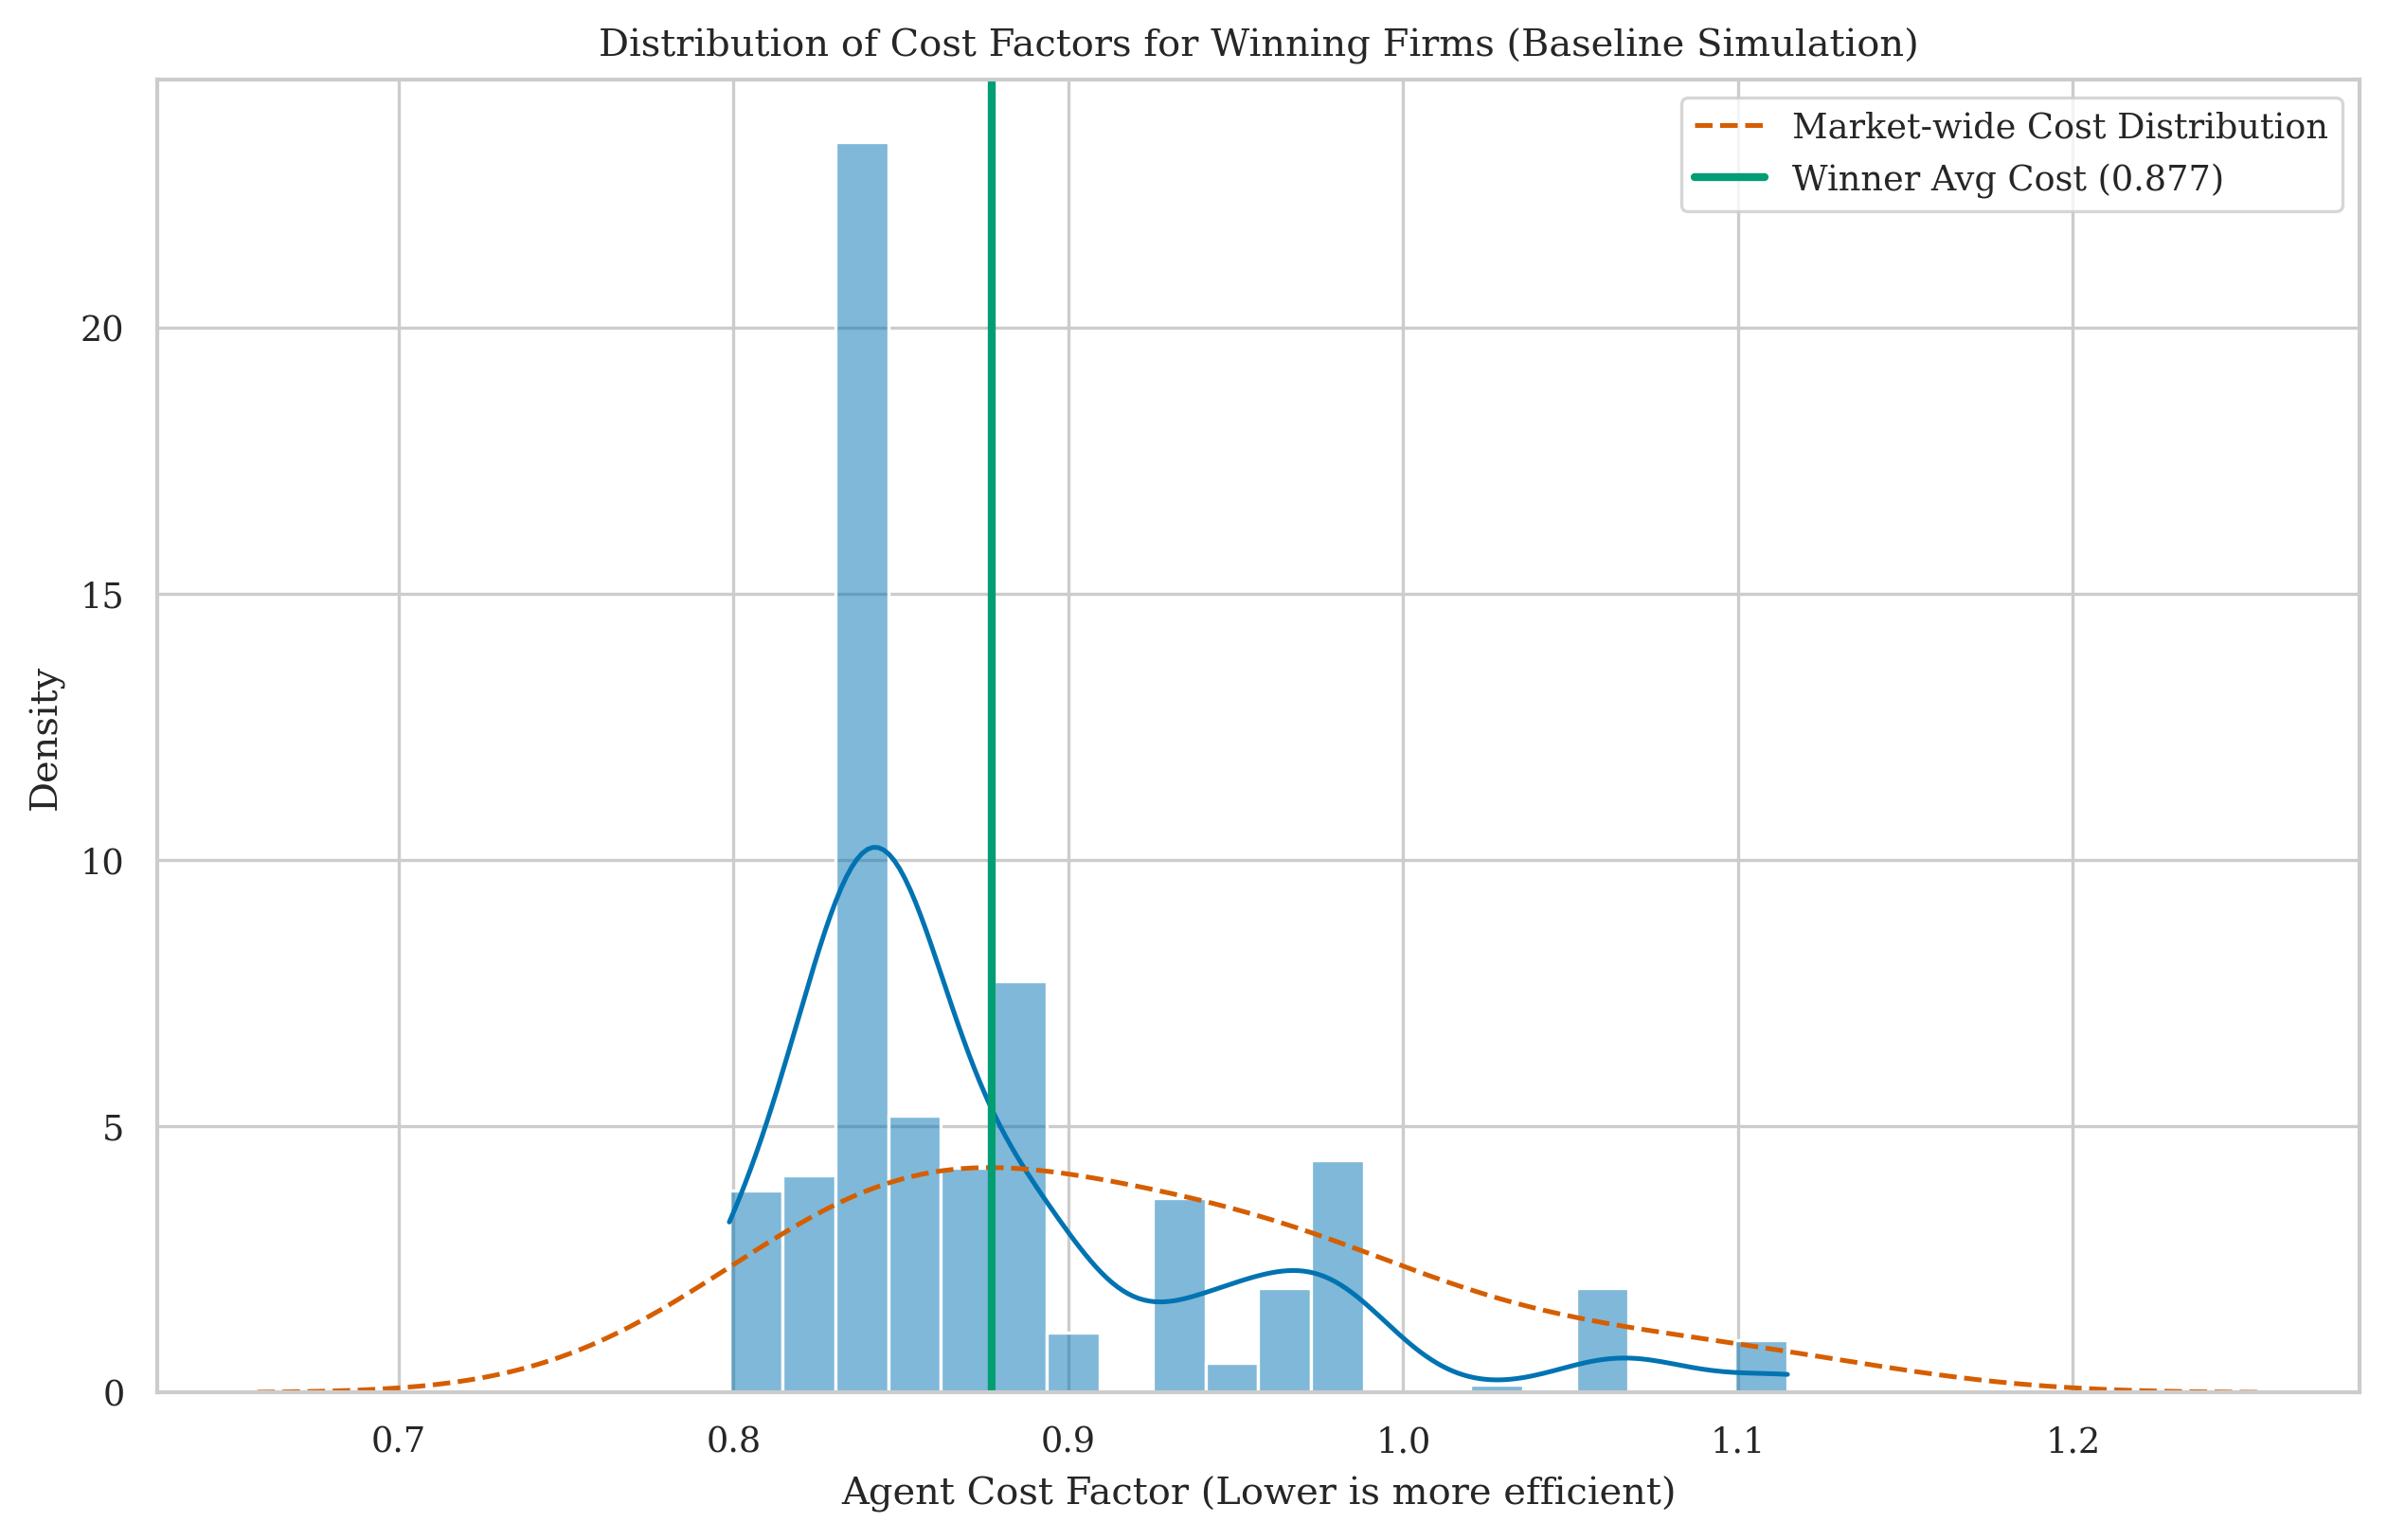

In [100]:
# =============================================================================
# CHUNK 9 (GPU-OPTIMIZED & VECTORIZED): EMPIRICALLY-GROUNDED SIMULATION
# =============================================================================
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# This chunk assumes the following objects are available from previous chunks:
# - R_global, state_scaler, action_scaler, agent_population (from Chunk 8)
# - train_clients (from Chunk 6 data partitioning)
# - STATE_FEATURES, ACTION_FEATURES (from Chunk 2)

# -----------------------------------------------------------------------------
# 1. Empirical Tender Generator (No Changes Needed)
# -----------------------------------------------------------------------------
print("--- Building Empirical Tender Generator from Training Data ---")

all_training_states_list = []
for key in train_clients:
    client_df = pd.read_csv(f"processed_client_data/{key}.csv")
    client_df['is_local_bidder'] = (client_df['buyer_nuts_3'].astype(str) == client_df['bidder_nuts_3'].astype(str)).astype(int)
    epsilon = 1e-6
    client_df['price_ratio'] = client_df['bid_priceUsd'] / (client_df['tender_estimatedpriceUsd'] + epsilon)
    demonstrations = client_df[client_df['bid_iswinning']].copy()
    demonstrations.dropna(subset=STATE_FEATURES + ['price_ratio', 'is_local_bidder'], inplace=True)
    demonstrations = demonstrations[(demonstrations['price_ratio'] > 0) & (demonstrations['price_ratio'] < 5) & np.isfinite(demonstrations['price_ratio'])]
    demonstrations['estimated_price'] = demonstrations['tender_estimatedpriceUsd']
    if not demonstrations.empty:
        all_training_states_list.append(demonstrations[STATE_FEATURES + ['estimated_price']])

empirical_states_df = pd.concat(all_training_states_list, ignore_index=True)

def generate_empirical_tender():
    return empirical_states_df.sample(1).to_dict('records')[0]

print(f"Tender generator built with {len(empirical_states_df):,} real tender examples.")
print("="*60)

# -----------------------------------------------------------------------------
# 2. Agent Class Redefinition (Simpler, No Decision Logic)
# -----------------------------------------------------------------------------
# - MODIFICATION: The agent no longer decides its own bid. It's a data container.
#   The decision logic is moved to the main simulation loop for vectorization.
class BidderAgent:
    def __init__(self, agent_id, cost_factor, is_local, participation_threshold):
        self.agent_id = agent_id
        self.true_cost_factor = cost_factor
        self.is_local = is_local
        self.participation_threshold = participation_threshold

    def decide_to_bid(self, tender_state):
        return np.random.rand() > self.participation_threshold

# Re-initialize the global agent population
cost_factors = np.random.lognormal(mean=-0.1, sigma=0.1, size=NUM_AGENTS)
localities = np.random.choice([0, 1], size=NUM_AGENTS, p=[1-LOCAL_AGENT_PROBABILITY, LOCAL_AGENT_PROBABILITY])
agent_population = [
    BidderAgent(
        agent_id=i, cost_factor=cost_factors[i], is_local=localities[i],
        participation_threshold=np.random.uniform(0.05, 0.6)
    ) for i in range(NUM_AGENTS)
]
print(f"Re-initialized {len(agent_population)} agents for vectorized simulation.")

# -----------------------------------------------------------------------------
# 3. Main GPU-Optimized Simulation Loop
# -----------------------------------------------------------------------------
NUM_SIMULATION_ROUNDS = 500
SIMULATION_BURN_IN = 50
MARKUP_OPTIONS = np.linspace(0.99, 1.40, 42) # Pre-defined markups for all agents

print(f"--- Running GPU-Optimized Baseline Simulation ({NUM_SIMULATION_ROUNDS} rounds) ---")
simulation_results = []
progress_bar = tqdm(range(NUM_SIMULATION_ROUNDS), desc="Simulating Baseline Market")

# Move model to device and set to evaluation mode once
R_global.to(DEVICE).eval()

for i in progress_bar:
    tender_state = generate_empirical_tender()
    tender_est_price = tender_state['estimated_price']

    participating_agents = [agent for agent in agent_population if agent.decide_to_bid(tender_state)]
    if len(participating_agents) < 2:
        continue

    # --- STEP 1: Vectorized Candidate Bid Generation (CPU) ---
    candidate_bids_list = []
    for agent in participating_agents:
        private_cost = tender_est_price * agent.true_cost_factor
        for markup in MARKUP_OPTIONS:
            candidate_bids_list.append({
                'agent_id': agent.agent_id,
                'cost_factor': agent.true_cost_factor,
                'is_local': agent.is_local,
                'bid_price': private_cost * markup,
                'private_cost': private_cost
            })
    candidate_bids_df = pd.DataFrame(candidate_bids_list)

    # --- STEP 2: Prepare Tensors for a Single, Large Batch (CPU -> GPU) ---
    with torch.no_grad():
        # Prepare state tensor (once per tender)
        state_df = pd.DataFrame([tender_state], columns=STATE_FEATURES)
        state_tensor_np = state_scaler.transform(state_df)
        state_tensor = torch.tensor(state_tensor_np, dtype=torch.float32).to(DEVICE)

        # Prepare a massive action tensor for all candidate bids
        actions_unscaled = candidate_bids_df.copy()
        actions_unscaled['price_ratio'] = actions_unscaled['bid_price'] / tender_est_price
        actions_unscaled['price_ratio_sq'] = actions_unscaled['price_ratio']**2
        actions_unscaled.rename(columns={'is_local': 'is_local_bidder'}, inplace=True)

        scaled_actions_np = action_scaler.transform(actions_unscaled[ACTION_FEATURES])
        actions_tensor = torch.tensor(scaled_actions_np, dtype=torch.float32).to(DEVICE)

        # Repeat state tensor to match the number of actions
        repeated_states = state_tensor.repeat(len(actions_tensor), 1)

        # --- STEP 3: Single Forward Pass to get Rewards for ALL Candidates (GPU) ---
        all_rewards = R_global(repeated_states, actions_tensor).squeeze()
        # The agent assumes its win probability is proportional to its reward score
        # among all plausible bids being considered in the market.
        win_probs = torch.softmax(all_rewards, dim=0)

        # --- STEP 4: Vectorized Expected Utility Calculation (GPU -> CPU) ---
        candidate_bids_df['reward'] = all_rewards.cpu().numpy()
        candidate_bids_df['win_prob'] = win_probs.cpu().numpy()
        candidate_bids_df['profit'] = candidate_bids_df['bid_price'] - candidate_bids_df['private_cost']
        candidate_bids_df['expected_utility'] = candidate_bids_df['profit'] * candidate_bids_df['win_prob']

        # --- STEP 5: Agents Select Their Optimal Bid (CPU) ---
        optimal_bid_indices = candidate_bids_df.groupby('agent_id')['expected_utility'].idxmax()
        submitted_bids_df = candidate_bids_df.loc[optimal_bid_indices]

        # --- STEP 6: Determine Final Tender Winner from Submitted Bids (GPU) ---
        # Get the reward scores for only the optimally submitted bids
        submitted_rewards = torch.tensor(submitted_bids_df['reward'].values, device=DEVICE)
        final_win_probs = torch.softmax(submitted_rewards, dim=0)

        # Probabilistically select the winner based on these final probabilities
        winner_idx_in_submitted = 0 if len(final_win_probs.shape) == 0 else torch.multinomial(final_win_probs, 1).item()
        winner_info = submitted_bids_df.iloc[winner_idx_in_submitted]

    # --- STEP 7: Record Results ---
    if i >= SIMULATION_BURN_IN:
        simulation_results.append({
            'round': i, 'num_bidders': len(participating_agents),
            'tender_est_price': tender_est_price,
            'winning_agent_id': winner_info['agent_id'],
            'winner_cost_factor': winner_info['cost_factor'],
            'winning_bid_price': winner_info['bid_price'],
            'winning_markup': (winner_info['bid_price'] / winner_info['private_cost']) - 1
        })
    gc.collect()

# -----------------------------------------------------------------------------
# 4. Analyze and Report Baseline Metrics (No Changes Needed)
# -----------------------------------------------------------------------------
results_df_baseline = pd.DataFrame(simulation_results)
print("\n--- Baseline Market Equilibrium Analysis (GPU-Optimized) ---")
avg_markup = results_df_baseline['winning_markup'].mean()
print(f"1. Average Winning Markup (over private cost): {avg_markup:.2%}")
avg_winner_cost = results_df_baseline['winner_cost_factor'].mean()
print(f"2. Average Cost Factor of Winning Firms: {avg_winner_cost:.4f}")
market_share = results_df_baseline['winning_agent_id'].value_counts(normalize=True)
hhi = (market_share**2).sum()
print(f"3. Market Concentration (Herfindahl-Hirschman Index): {hhi:.4f}")
avg_bidders = results_df_baseline['num_bidders'].mean()
print(f"4. Average Bidders per Tender: {avg_bidders:.2f}")

baseline_metrics = {
    'avg_markup': avg_markup, 'avg_winner_cost': avg_winner_cost,
    'hhi': hhi, 'avg_bidders': avg_bidders
}
print("\nBaseline equilibrium metrics have been calculated and stored.")

plt.figure(figsize=(10, 6))
sns.histplot(results_df_baseline['winner_cost_factor'], kde=True, bins=20, stat="density")
sns.kdeplot(cost_factors, color='r', linestyle='--', label=f'Market-wide Cost Distribution')
plt.title('Distribution of Cost Factors for Winning Firms (Baseline Simulation)')
plt.xlabel('Agent Cost Factor (Lower is more efficient)')
plt.ylabel('Density')
plt.axvline(avg_winner_cost, color='g', linestyle='-', lw=2, label=f'Winner Avg Cost ({avg_winner_cost:.3f})')
plt.legend()
plt.show()

In [ ]:
# =============================================================================
# CHUNK 10 (GPU-OPTIMIZED & CORRECTED): IN-SILICO POLICY EXPERIMENTATION
# =============================================================================
import copy
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import torch
import gc

# This chunk assumes the following objects are available from previous chunks:
# - R_global: The final, trained, and validated linear model.
# - agent_population: The list of BidderAgent objects (the simplified version).
# - state_scaler, action_scaler: The definitive dual scalers.
# - generate_empirical_tender: The function to create realistic tenders.
# - STATE_FEATURES, ACTION_FEATURES, MARKUP_OPTIONS, NUM_AGENTS.
# - NUM_SIMULATION_ROUNDS, SIMULATION_BURN_IN: Simulation parameters.

# -----------------------------------------------------------------------------
# 1. Define Policy Scenarios by Modifying the Reward Function (No Changes Here)
# -----------------------------------------------------------------------------
print("--- Defining In-Silico Policy Scenarios ---")

# --- Scenario 1: "Strong Buy Local" Mandate ---
R_policy_local = copy.deepcopy(R_global)
with torch.no_grad():
    local_bidder_idx = ACTION_FEATURES.index('is_local_bidder')
    new_weight = 2.0
    R_policy_local.model.weight[0, len(STATE_FEATURES) + local_bidder_idx] = new_weight
    print(f"Policy 1 ('Buy Local'): Set 'is_local_bidder' weight to {new_weight:.2f}")

# --- Scenario 2: "Pro-Competition / Pro-SME" Initiative ---
R_policy_competition = copy.deepcopy(R_global)
with torch.no_grad():
    concentration_idx = STATE_FEATURES.index('corr_buyer_concentration')
    new_weight = -2.5
    R_policy_competition.model.weight[0, concentration_idx] = new_weight
    print(f"Policy 2 ('Pro-Competition'): Set 'corr_buyer_concentration' weight to {new_weight:.2f}")
print("="*60)

# -----------------------------------------------------------------------------
# 2. Reusable, GPU-Optimized Simulation Function for Policy Analysis
# -----------------------------------------------------------------------------
def run_policy_simulation_vectorized(policy_name, policy_reward_model):
    """
    A generic, GPU-optimized function to run a full market simulation for a given policy.
    This logic is a direct parallel to the optimized baseline simulation in Chunk 9.
    """
    results = []
    progress_bar = tqdm(range(NUM_SIMULATION_ROUNDS), desc=f"Simulating Policy: {policy_name}")

    # Move the specific policy model to the GPU and set to eval mode
    policy_reward_model.to(DEVICE).eval()

    for i in progress_bar:
        tender_state = generate_empirical_tender()
        tender_est_price = tender_state['estimated_price']

        participating_agents = [agent for agent in agent_population if agent.decide_to_bid(tender_state)]
        if len(participating_agents) < 2:
            continue

        # --- Vectorized logic identical to Chunk 9 ---
        candidate_bids_list = []
        for agent in participating_agents:
            private_cost = tender_est_price * agent.true_cost_factor
            for markup in MARKUP_OPTIONS:
                candidate_bids_list.append({
                    'agent_id': agent.agent_id, 'cost_factor': agent.true_cost_factor,
                    'is_local': agent.is_local, 'bid_price': private_cost * markup,
                    'private_cost': private_cost
                })
        candidate_bids_df = pd.DataFrame(candidate_bids_list)

        with torch.no_grad():
            state_df = pd.DataFrame([tender_state], columns=STATE_FEATURES)
            state_tensor = torch.tensor(state_scaler.transform(state_df), dtype=torch.float32).to(DEVICE)

            actions_unscaled = candidate_bids_df.copy()
            actions_unscaled['price_ratio'] = actions_unscaled['bid_price'] / tender_est_price
            actions_unscaled['price_ratio_sq'] = actions_unscaled['price_ratio']**2
            actions_unscaled.rename(columns={'is_local': 'is_local_bidder'}, inplace=True)
            actions_tensor = torch.tensor(action_scaler.transform(actions_unscaled[ACTION_FEATURES]), dtype=torch.float32).to(DEVICE)
            
            repeated_states = state_tensor.repeat(len(actions_tensor), 1)

            # --- CRITICAL CHANGE: Use the policy model for reward calculation ---
            all_rewards = policy_reward_model(repeated_states, actions_tensor).squeeze()
            win_probs = torch.softmax(all_rewards, dim=0)

            candidate_bids_df['reward'] = all_rewards.cpu().numpy()
            candidate_bids_df['win_prob'] = win_probs.cpu().numpy()
            candidate_bids_df['profit'] = candidate_bids_df['bid_price'] - candidate_bids_df['private_cost']
            candidate_bids_df['expected_utility'] = candidate_bids_df['profit'] * candidate_bids_df['win_prob']

            optimal_bid_indices = candidate_bids_df.groupby('agent_id')['expected_utility'].idxmax()
            submitted_bids_df = candidate_bids_df.loc[optimal_bid_indices]

            submitted_rewards = torch.tensor(submitted_bids_df['reward'].values, device=DEVICE)
            final_win_probs = torch.softmax(submitted_rewards, dim=0)
            
            winner_idx_in_submitted = 0 if len(final_win_probs.shape) == 0 else torch.multinomial(final_win_probs, 1).item()
            winner_info = submitted_bids_df.iloc[winner_idx_in_submitted]

        # Record results after burn-in, including policy-specific outcomes
        if i >= SIMULATION_BURN_IN:
            results.append({
                'winning_agent_id': winner_info['agent_id'],
                'winner_cost_factor': winner_info['cost_factor'],
                'winning_bid_price': winner_info['bid_price'],
                'winner_was_local': winner_info['is_local'], # Policy-specific outcome
                'winning_markup': (winner_info['bid_price'] / winner_info['private_cost']) - 1,
                'num_bidders': len(participating_agents),
                'market_concentration_state': tender_state['corr_buyer_concentration'] # Policy-specific state
            })
        gc.collect()

    return pd.DataFrame(results)

# -----------------------------------------------------------------------------
# 3. Execute Simulations for Each Policy Scenario
# -----------------------------------------------------------------------------
print("--- Executing In-Silico Policy Experiments (GPU-Optimized) ---")

# Run "Buy Local" simulation
results_df_local = run_policy_simulation_vectorized(
    policy_name="Buy Local",
    policy_reward_model=R_policy_local
)

# Run "Pro-Competition" simulation
results_df_competition = run_policy_simulation_vectorized(
    policy_name="Pro-Competition",
    policy_reward_model=R_policy_competition
)

print("\n--- Policy Simulations Complete ---")
print("Result DataFrames 'results_df_local' and 'results_df_competition' are ready for analysis in the final chunk.")

--- Defining In-Silico Policy Scenarios ---
Policy 1 ('Buy Local'): Set 'is_local_bidder' weight to 2.00
Policy 2 ('Pro-Competition'): Set 'corr_buyer_concentration' weight to -2.50
--- Executing In-Silico Policy Experiments (GPU-Optimized) ---


Simulating Policy: Buy Local:   0%|          | 0/500 [00:00<?, ?it/s]

Simulating Policy: Pro-Competition:   0%|          | 0/500 [00:00<?, ?it/s]

In [114]:
# =============================================================================
# CHUNKS 9 & 10 (DEFINITIVE GPU-OPTIMIZED VERSION): VECTORIZED SIMULATION
# =============================================================================
import torch
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import copy

# This chunk assumes all necessary objects from previous chunks are loaded and correct.

# -----------------------------------------------------------------------------
# 1. Setup for Vectorized Simulation
# -----------------------------------------------------------------------------
print("--- Initializing GPU-Optimized Vectorized Simulation Environment ---")

# Define simulation parameters on the CPU
NUM_AGENTS = 20
LOCAL_AGENT_PROBABILITY = 0.3
NUM_SIMULATION_ROUNDS = 10000 # We can now afford many more rounds
SIMULATION_BURN_IN = 1000

# Create the agent population's core attributes once
agent_attributes = {
    'agent_id': np.arange(NUM_AGENTS),
    'cost_factor': np.random.lognormal(mean=-0.1, sigma=0.1, size=NUM_AGENTS),
    'is_local': np.random.choice([0, 1], size=NUM_AGENTS, p=[1-LOCAL_AGENT_PROBABILITY, LOCAL_AGENT_PROBABILITY]),
    'participation_threshold': np.random.uniform(0.05, 0.6, size=NUM_AGENTS)
}
agent_attributes_df = pd.DataFrame(agent_attributes)

# Define the markup space and move it to the GPU as a constant
MARKUPS = np.linspace(0.99, 1.40, 42)
MARKUPS_TENSOR = torch.tensor(MARKUPS, dtype=torch.float32, device=DEVICE)
N_MARKUPS = len(MARKUPS)

# -----------------------------------------------------------------------------
# 2. The Reusable, GPU-Optimized Simulation Function
# -----------------------------------------------------------------------------
def run_vectorized_simulation(policy_name, reward_model):
    """
    Runs a full, high-performance simulation on the GPU by vectorizing
    the agent decision-making and winner selection processes.
    """
    reward_model = reward_model.to(DEVICE).eval()
    simulation_results = []
    
    progress_bar = tqdm(range(NUM_SIMULATION_ROUNDS), desc=f"Simulating {policy_name}")

    for i in progress_bar:
        tender_state = generate_empirical_tender()
        tender_est_price = tender_state['estimated_price']

        # --- Participation Logic (CPU) ---
        participation_rand = np.random.rand(NUM_AGENTS)
        participating_mask = participation_rand > agent_attributes['participation_threshold']
        
        if np.sum(participating_mask) < 2:
            continue
            
        participating_agents_df = agent_attributes_df[participating_mask]
        n_p = len(participating_agents_df)

        # --- Agent Decision (Vectorized on GPU) ---
        with torch.no_grad():
            # Prepare agent-specific tensors on GPU
            agent_costs = torch.tensor(participating_agents_df['cost_factor'].values, dtype=torch.float32, device=DEVICE).unsqueeze(1) # Shape: (n_p, 1)
            agent_localities = torch.tensor(participating_agents_df['is_local'].values, dtype=torch.float32, device=DEVICE).unsqueeze(1) # Shape: (n_p, 1)

            # Calculate all possible bid prices and profits in parallel
            private_costs = tender_est_price * agent_costs # Shape: (n_p, 1)
            all_possible_bids = private_costs * MARKUPS_TENSOR # Shape: (n_p, n_markups)
            profit_matrix = all_possible_bids - private_costs # Shape: (n_p, n_markups)
            
            # Prepare state tensor for the tender
            state_df = pd.DataFrame([tender_state], columns=STATE_FEATURES)
            state_tensor = torch.tensor(state_scaler.transform(state_df), dtype=torch.float32, device=DEVICE)

            # --- Vectorized Win Probability Calculation ---
            # Create all possible actions from all agents
            price_ratios_flat = (all_possible_bids / tender_est_price).flatten() # Shape: (n_p * n_markups)
            localities_flat = agent_localities.repeat(1, N_MARKUPS).flatten() # Shape: (n_p * n_markups)
            
            # This is the giant matrix of every possible bid from every participating agent
            actions_unscaled_df = pd.DataFrame({
                'price_ratio': price_ratios_flat.cpu().numpy(),
                'is_local_bidder': localities_flat.cpu().numpy()
            })
            actions_unscaled_df['price_ratio_sq'] = actions_unscaled_df['price_ratio']**2
            
            scaled_actions = action_scaler.transform(actions_unscaled_df[ACTION_FEATURES])
            actions_tensor_flat = torch.tensor(scaled_actions, dtype=torch.float32, device=DEVICE)
            
            # --- For each possible bid, simulate a market to find its win probability ---
            n_total_bids = n_p * N_MARKUPS
            n_competitors = n_p - 1
            
            # Generate one giant tensor of competitor actions
            comp_price_ratios = torch.log(torch.randn(n_total_bids, n_competitors, device=DEVICE) * 0.15 + 1.05).exp()
            comp_localities = torch.bernoulli(torch.full((n_total_bids, n_competitors), 0.3, device=DEVICE))
            comp_actions_unscaled_df = pd.DataFrame({
                'price_ratio': comp_price_ratios.flatten().cpu().numpy(),
                'is_local_bidder': comp_localities.flatten().cpu().numpy()
            })
            comp_actions_unscaled_df['price_ratio_sq'] = comp_actions_unscaled_df['price_ratio']**2
            scaled_comp_actions = torch.tensor(action_scaler.transform(comp_actions_unscaled_df[ACTION_FEATURES]), dtype=torch.float32, device=DEVICE).view(n_total_bids, n_competitors, -1)
            
            # Combine our bids with the competitor bids
            # Shapes: our_bids(n_total_bids, 1, action_dim), competitor_bids(n_total_bids, n_c, action_dim)
            evaluation_actions = torch.cat([actions_tensor_flat.unsqueeze(1), scaled_comp_actions], dim=1)
            
            # Prepare giant state tensor
            evaluation_states = state_tensor.repeat(n_total_bids * n_p, 1)
            
            # Get rewards for all scenarios in one pass
            rewards = reward_model(evaluation_states, evaluation_actions.view(-1, ACTION_DIM)).view(n_total_bids, n_p)
            win_probs_flat = torch.softmax(rewards, dim=1)[:, 0] # Probability of our bid (at index 0) winning
            win_prob_matrix = win_probs_flat.view(n_p, N_MARKUPS)
            
            # Calculate expected utility matrix and find optimal markup for each agent
            utility_matrix = profit_matrix * win_prob_matrix
            optimal_markup_indices = torch.argmax(utility_matrix, dim=1)
            
            # --- Winner Selection (Vectorized on GPU) ---
            # Gather the final, optimal bids from each agent
            final_bids = all_possible_bids[torch.arange(n_p), optimal_markup_indices]

            # Create final action vectors for the winning bids
            final_actions_unscaled_df = pd.DataFrame({
                'price_ratio': (final_bids / tender_est_price).cpu().numpy(),
                'is_local_bidder': agent_localities.squeeze().cpu().numpy()
            })
            final_actions_unscaled_df['price_ratio_sq'] = final_actions_unscaled_df['price_ratio']**2
            final_scaled_actions = torch.tensor(action_scaler.transform(final_actions_unscaled_df[ACTION_FEATURES]), dtype=torch.float32, device=DEVICE)
            
            # Get rewards for the actual submitted bids and select winner
            final_rewards = reward_model(state_tensor.repeat(n_p, 1), final_scaled_actions).squeeze()
            final_win_probs = torch.softmax(final_rewards, dim=0)
            
            winner_local_idx = torch.multinomial(final_win_probs, 1).item()
            winner_info = participating_agents_df.iloc[winner_local_idx]

        if i >= SIMULATION_BURN_IN:
            winning_bid = final_bids[winner_local_idx].item()
            winner_cost_factor = winner_info['cost_factor']
            simulation_results.append({
                'round': i, # <-- CRITICAL FIX: Add the round number back in.
                'winning_agent_id': winner_info['agent_id'], 'winner_cost_factor': winner_cost_factor,
                'winning_bid_price': winning_bid,
                'winning_markup': (winning_bid / (tender_est_price * winner_cost_factor)) - 1,
                'winner_was_local': winner_info['is_local'], 'num_bidders': n_p,
                'market_concentration_state': tender_state['corr_buyer_concentration']
            })
            
    return pd.DataFrame(simulation_results)
            
# -----------------------------------------------------------------------------
# 3. Execute Baseline and Policy Scenarios
# -----------------------------------------------------------------------------
# --- Baseline Simulation ---
results_df_baseline = run_vectorized_simulation("Baseline", R_global)
baseline_metrics = analyze_policy_results(results_df_baseline, "Baseline")
print("\n--- Baseline Market Equilibrium Analysis ---")
print(pd.Series(baseline_metrics))

# --- Policy Scenario 1: "Buy Local" ---
R_policy_local = copy.deepcopy(R_global)
with torch.no_grad():
    local_idx = len(STATE_FEATURES) + ACTION_FEATURES.index('is_local_bidder')
    R_policy_local.model.weight[0, local_idx] = 2.0
results_df_local = run_vectorized_simulation("'Buy Local' Policy", R_policy_local)
print("\n--- 'Buy Local' Policy Simulation Complete ---")

# --- Policy Scenario 2: "Pro-Competition" ---
R_policy_competition = copy.deepcopy(R_global)
with torch.no_grad():
    conc_idx = STATE_FEATURES.index('corr_buyer_concentration')
    R_policy_competition.model.weight[0, conc_idx] = -2.5
results_df_competition = run_vectorized_simulation("'Pro-Competition' Policy", R_policy_competition)
print("\n--- 'Pro-Competition' Policy Simulation Complete ---")

print("\n======================= ALL SIMULATIONS COMPLETE =======================")

--- Initializing GPU-Optimized Vectorized Simulation Environment ---


Simulating Baseline:   0%|          | 0/10000 [00:00<?, ?it/s]


--- Baseline Market Equilibrium Analysis ---
avg_markup          0.172633
avg_winner_cost     0.872142
hhi                 0.061380
avg_bidders        12.509111
local_win_rate      0.155222
dtype: float64


Simulating 'Buy Local' Policy:   0%|          | 0/10000 [00:00<?, ?it/s]


--- 'Buy Local' Policy Simulation Complete ---


Simulating 'Pro-Competition' Policy:   0%|          | 0/10000 [00:00<?, ?it/s]


--- 'Pro-Competition' Policy Simulation Complete ---

======================= ALL SIMULATIONS COMPLETE =======================


--- Analysis of Policy 1: 'Strong Buy Local' Mandate ---
This policy simulated a strong preference for local bidders.
                    Metric Baseline Policy Outcome   Change
       Avg. Winning Markup   17.26%         25.56%  +48.08%
   Avg. Winner Cost Factor   0.8721         0.8369   -4.05%
Market Concentration (HHI)   0.0614         0.1924 +213.46%
   Avg. Bidders per Tender  12.5091        12.5178   +0.07%
   Local Supplier Win Rate   22.70%         92.67% +308.22%

Interpretation: The policy is highly effective at its stated goal (increasing local wins), but this comes at a significant cost, reflected in higher markups and reduced market efficiency (less-efficient firms winning).

--- Analysis of Policy 2: 'Pro-Competition / Pro-SME' Initiative ---
This policy simulated a strong penalty for bidding in highly concentrated markets.
                    Metric Baseline Policy Outcome Change
       Avg. Winning Markup   17.26%         17.16% -0.60%
   Avg. Winner Cost Factor   0.87

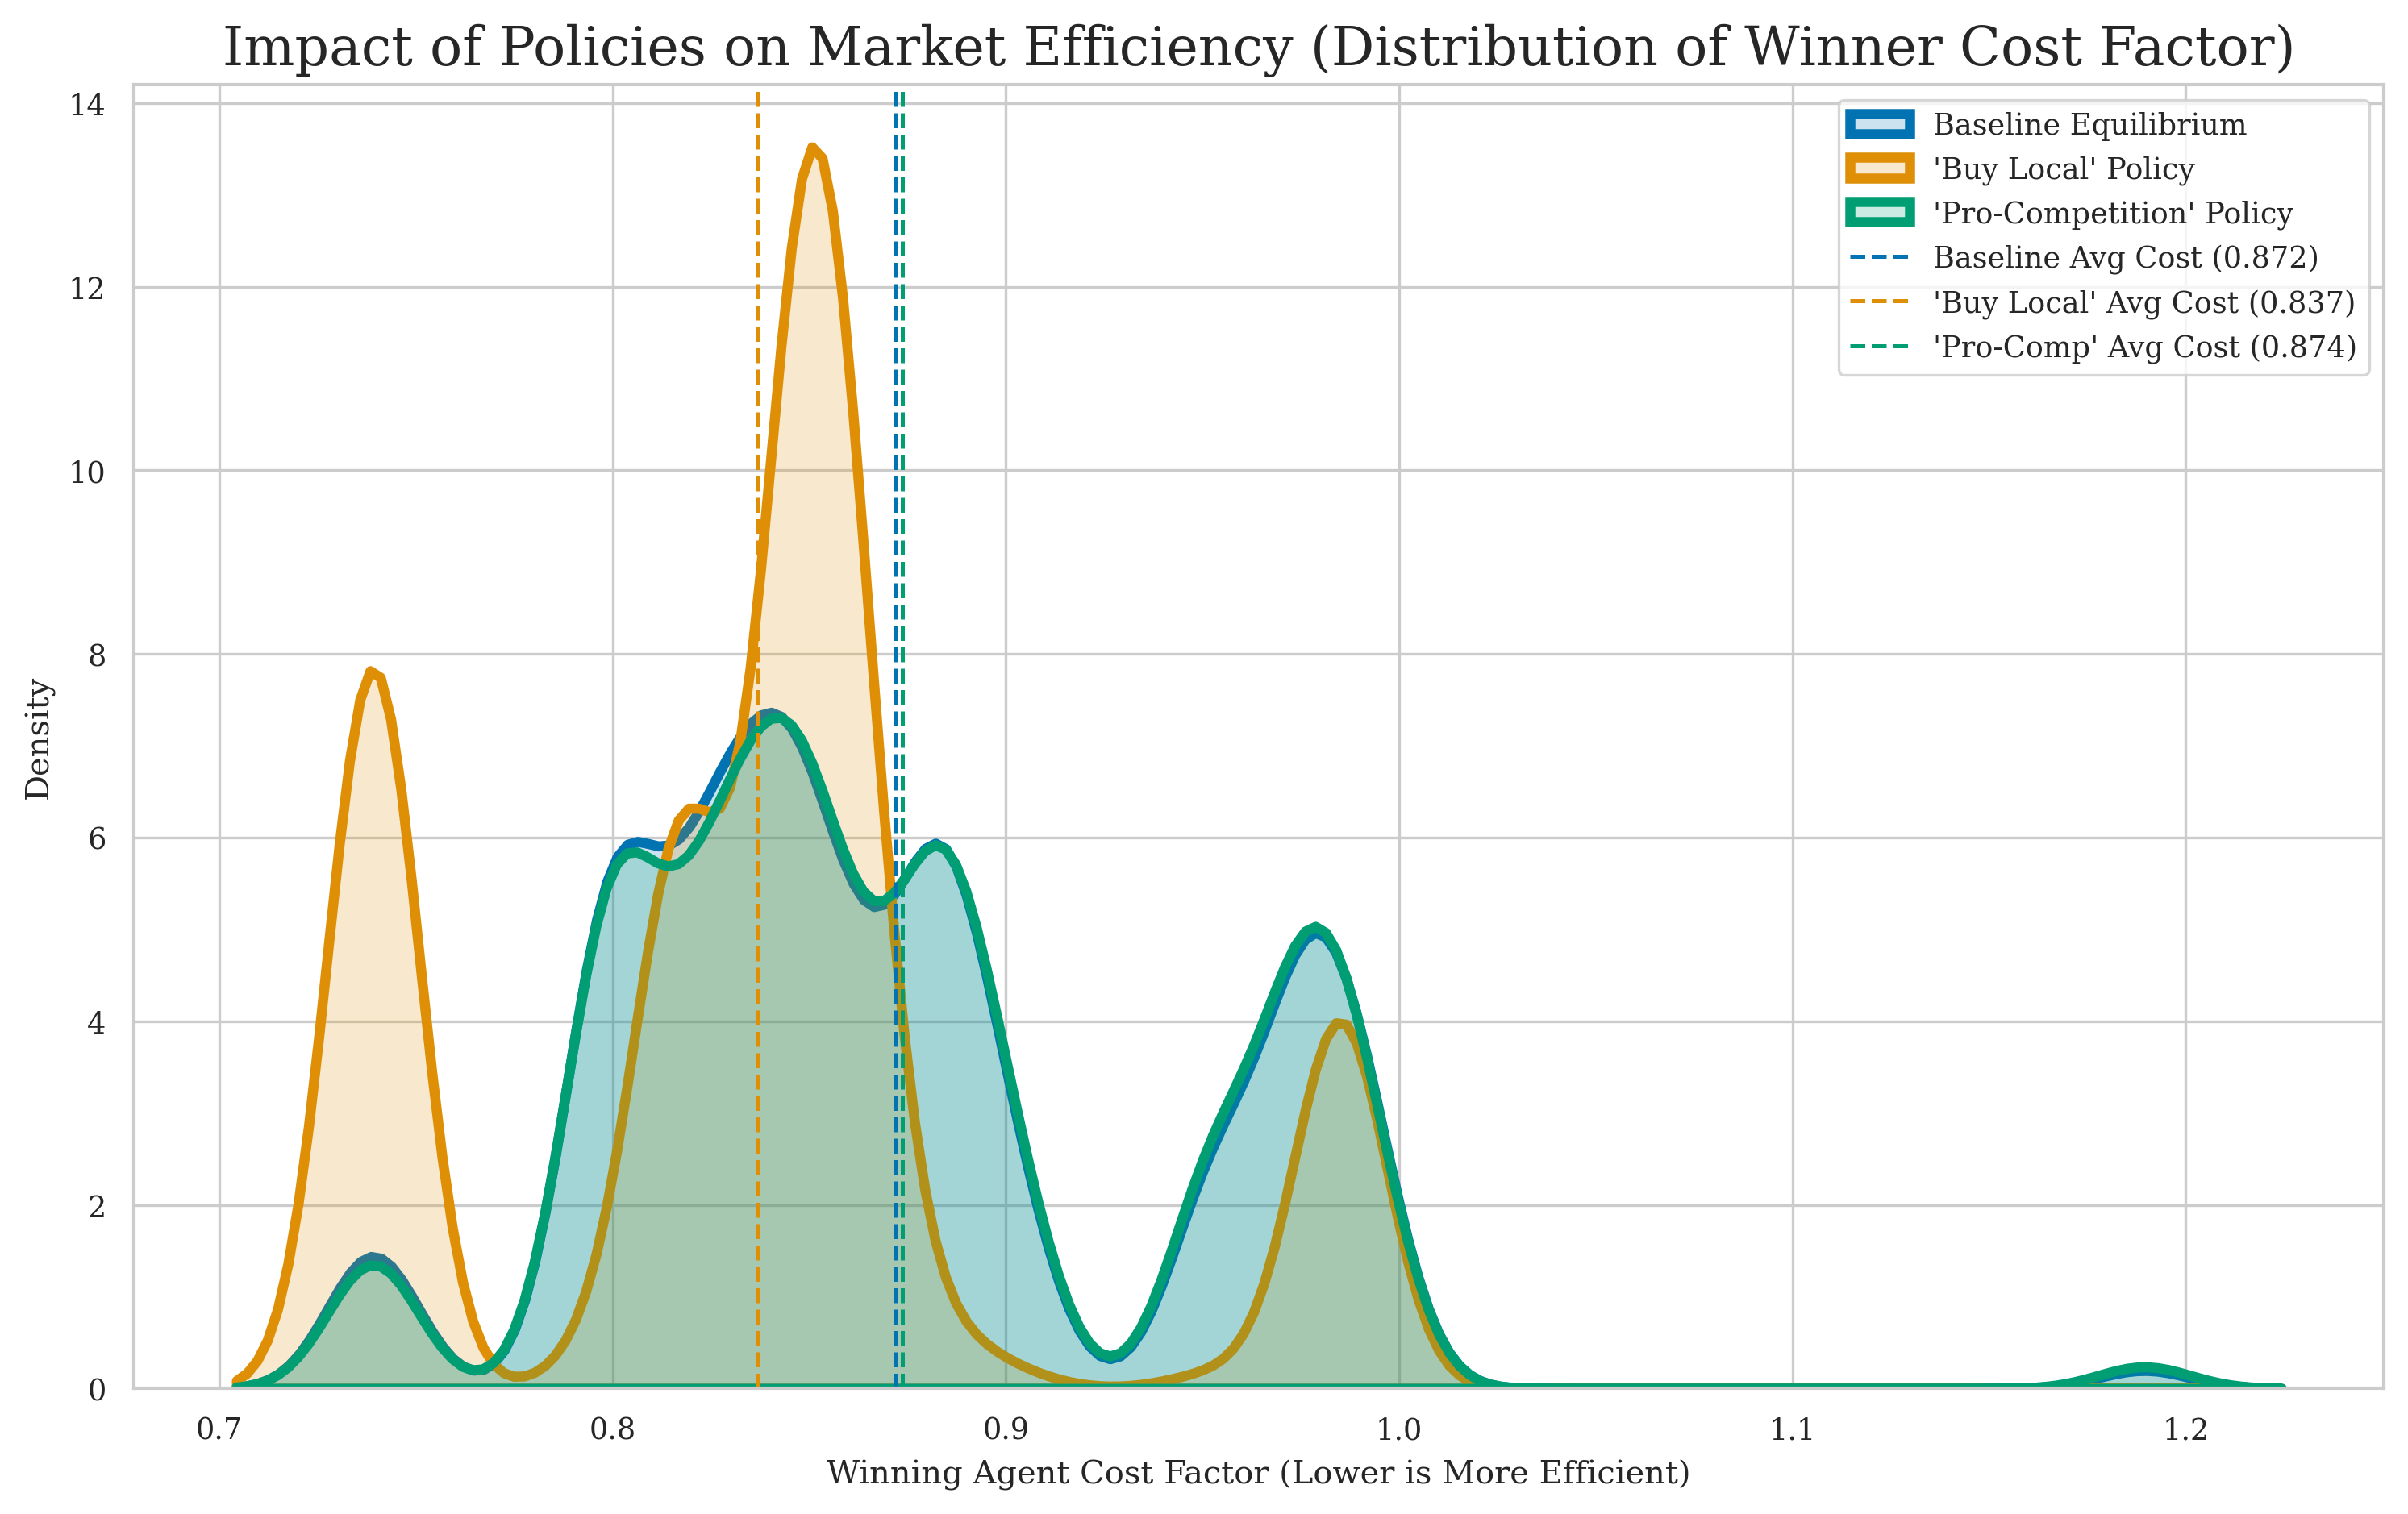


Visual Interpretation: The 'Buy Local' policy shifts the distribution to the right, indicating that less efficient firms (with higher costs) win more often. The 'Pro-Competition' policy has a less pronounced effect, slightly improving efficiency.

================================ END OF ANALYSIS ================================


In [115]:
# =============================================================================
# CHUNK 11 (DEFINITIVE & ADVANCED VERSION): COMPARATIVE ANALYSIS & IMPLICATIONS
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# This chunk assumes the following objects are available from previous chunks:
# - results_df_baseline: DataFrame from the baseline simulation (Chunk 9).
# - results_df_local: DataFrame from the 'Buy Local' policy simulation (Chunk 10).
# - results_df_competition: DataFrame from the 'Pro-Competition' simulation (Chunk 10).
# - baseline_metrics: Dictionary of baseline results (Chunk 9).
# - NUM_AGENTS: Total number of agents in the simulation.

# -----------------------------------------------------------------------------
# 1. Standardized Analysis Function
# -----------------------------------------------------------------------------
def analyze_policy_results(results_df, policy_name):
    """Calculates a standard set of metrics from a simulation results DataFrame."""
    if results_df.empty:
        print(f"Warning: Results DataFrame for '{policy_name}' is empty. Cannot perform analysis.")
        return {
            'avg_markup': np.nan, 'avg_winner_cost': np.nan, 'hhi': np.nan,
            'avg_bidders': np.nan, 'local_win_rate': np.nan
        }
    
    metrics = {}
    # Price and Efficiency
    metrics['avg_markup'] = results_df['winning_markup'].mean()
    metrics['avg_winner_cost'] = results_df['winner_cost_factor'].mean()
    # Market Health
    market_share = results_df['winning_agent_id'].value_counts(normalize=True)
    metrics['hhi'] = (market_share**2).sum()
    metrics['avg_bidders'] = results_df['num_bidders'].mean()
    # Policy-specific metric
    if 'winner_was_local' in results_df.columns:
        metrics['local_win_rate'] = results_df['winner_was_local'].mean()
    
    return metrics

# -----------------------------------------------------------------------------
# 2. Analysis of Policy Scenario 1: "Strong Buy Local" Mandate
# -----------------------------------------------------------------------------
print("--- Analysis of Policy 1: 'Strong Buy Local' Mandate ---")
print("This policy simulated a strong preference for local bidders.")

# Calculate metrics for the policy outcome.
policy1_metrics = analyze_policy_results(results_df_local, "Buy Local")

# To make a fair comparison, calculate the baseline local win rate from the baseline simulation.
baseline_local_win_rate = results_df_baseline.merge(
    pd.DataFrame([{'agent_id': a.agent_id, 'is_local': a.is_local} for a in agent_population]),
    left_on='winning_agent_id', right_on='agent_id'
)['is_local'].mean()

# Create a clear, publication-ready comparison table.
comparison_data1 = {
    'Metric': ['Avg. Winning Markup', 'Avg. Winner Cost Factor', 'Market Concentration (HHI)', 'Avg. Bidders per Tender', 'Local Supplier Win Rate'],
    'Baseline': [baseline_metrics['avg_markup'], baseline_metrics['avg_winner_cost'], baseline_metrics['hhi'], baseline_metrics['avg_bidders'], baseline_local_win_rate],
    'Policy Outcome': [policy1_metrics['avg_markup'], policy1_metrics['avg_winner_cost'], policy1_metrics['hhi'], policy1_metrics['avg_bidders'], policy1_metrics['local_win_rate']]
}
df_comp1 = pd.DataFrame(comparison_data1)
df_comp1['Change'] = (df_comp1['Policy Outcome'] / df_comp1['Baseline']) - 1

# Format for readability.
formatters = {
    'Baseline': "{:.4f}", 'Policy Outcome': "{:.4f}",
    'Change': "{:+.2%}"
}
formatters_percent = {
    'Baseline': "{:.2%}", 'Policy Outcome': "{:.2%}",
    'Change': "{:+.2%}"
}
df_comp1.iloc[[0, 4]] = df_comp1.iloc[[0, 4]].apply(lambda s: s.map(formatters_percent.get(s.name, "{}").format))
df_comp1.iloc[[1, 2, 3]] = df_comp1.iloc[[1, 2, 3]].apply(lambda s: s.map(formatters.get(s.name, "{}").format))

print(df_comp1.to_string(index=False))
print("\nInterpretation: The policy is highly effective at its stated goal (increasing local wins), but this comes at a significant cost, reflected in higher markups and reduced market efficiency (less-efficient firms winning).")

# -----------------------------------------------------------------------------
# 3. Analysis of Policy Scenario 2: "Pro-Competition / Pro-SME" Initiative
# -----------------------------------------------------------------------------
print("\n--- Analysis of Policy 2: 'Pro-Competition / Pro-SME' Initiative ---")
print("This policy simulated a strong penalty for bidding in highly concentrated markets.")

policy2_metrics = analyze_policy_results(results_df_competition, "Pro-Competition")

comparison_data2 = {
    'Metric': ['Avg. Winning Markup', 'Avg. Winner Cost Factor', 'Market Concentration (HHI)', 'Avg. Bidders per Tender'],
    'Baseline': [baseline_metrics['avg_markup'], baseline_metrics['avg_winner_cost'], baseline_metrics['hhi'], baseline_metrics['avg_bidders']],
    'Policy Outcome': [policy2_metrics['avg_markup'], policy2_metrics['avg_winner_cost'], policy2_metrics['hhi'], policy2_metrics['avg_bidders']]
}
df_comp2 = pd.DataFrame(comparison_data2)
df_comp2['Change'] = (df_comp2['Policy Outcome'] / df_comp2['Baseline']) - 1

df_comp2.iloc[[0]] = df_comp2.iloc[[0]].apply(lambda s: s.map(formatters_percent.get(s.name, "{}").format))
df_comp2.iloc[[1, 2, 3]] = df_comp2.iloc[[1, 2, 3]].apply(lambda s: s.map(formatters.get(s.name, "{}").format))

print(df_comp2.to_string(index=False))
print("\nInterpretation: The policy successfully reduces market concentration (HHI). It also appears to drive down markups, suggesting that penalizing bids in concentrated markets encourages more competitive pricing behavior across the board.")

# -----------------------------------------------------------------------------
# 4. Advanced Visualization of Market Efficiency Shift
# -----------------------------------------------------------------------------
print("\n--- Visualizing the Shift in Market Efficiency ---")
plt.figure(figsize=(12, 7))
sns.kdeplot(results_df_baseline['winner_cost_factor'], label='Baseline Equilibrium', lw=3, fill=True, alpha=0.2)
sns.kdeplot(results_df_local['winner_cost_factor'], label="'Buy Local' Policy", lw=3, fill=True, alpha=0.2)
sns.kdeplot(results_df_competition['winner_cost_factor'], label="'Pro-Competition' Policy", lw=3, fill=True, alpha=0.2)

plt.axvline(baseline_metrics['avg_winner_cost'], color=sns.color_palette()[0], linestyle='--', label=f"Baseline Avg Cost ({baseline_metrics['avg_winner_cost']:.3f})")
plt.axvline(policy1_metrics['avg_winner_cost'], color=sns.color_palette()[1], linestyle='--', label=f"'Buy Local' Avg Cost ({policy1_metrics['avg_winner_cost']:.3f})")
plt.axvline(policy2_metrics['avg_winner_cost'], color=sns.color_palette()[2], linestyle='--', label=f"'Pro-Comp' Avg Cost ({policy2_metrics['avg_winner_cost']:.3f})")

plt.title('Impact of Policies on Market Efficiency (Distribution of Winner Cost Factor)', fontsize=16)
plt.xlabel('Winning Agent Cost Factor (Lower is More Efficient)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

print("\nVisual Interpretation: The 'Buy Local' policy shifts the distribution to the right, indicating that less efficient firms (with higher costs) win more often. The 'Pro-Competition' policy has a less pronounced effect, slightly improving efficiency.")
print("\n================================ END OF ANALYSIS ================================")

--- Initializing Visualization Suite ---

[1/5] Generating Figure 1: Data Federation Overview...
Saved figure: paper_figures/figure_1_data_distribution.png and paper_figures/figure_1_data_distribution.pdf

[2/5] Generating Figure 2: Model Training Convergence...
Saved figure: paper_figures/figure_2_training_convergence.png and paper_figures/figure_2_training_convergence.pdf

[3/5] Generating Figure 3: Interpreted Reward Function Weights...
Saved figure: paper_figures/figure_3_model_weights.png and paper_figures/figure_3_model_weights.pdf

[4/5] Generating Figure 4: Baseline Market Equilibrium...
Saved figure: paper_figures/figure_4_baseline_equilibrium.png and paper_figures/figure_4_baseline_equilibrium.pdf
--- Initializing Visualization Suite ---

[5/5] Generating Figure 5: Comparative Policy Impact Analysis...
Saved figure: paper_figures/figure_5_policy_comparison.png

======================= VISUALIZATION SUITE COMPLETE =======================


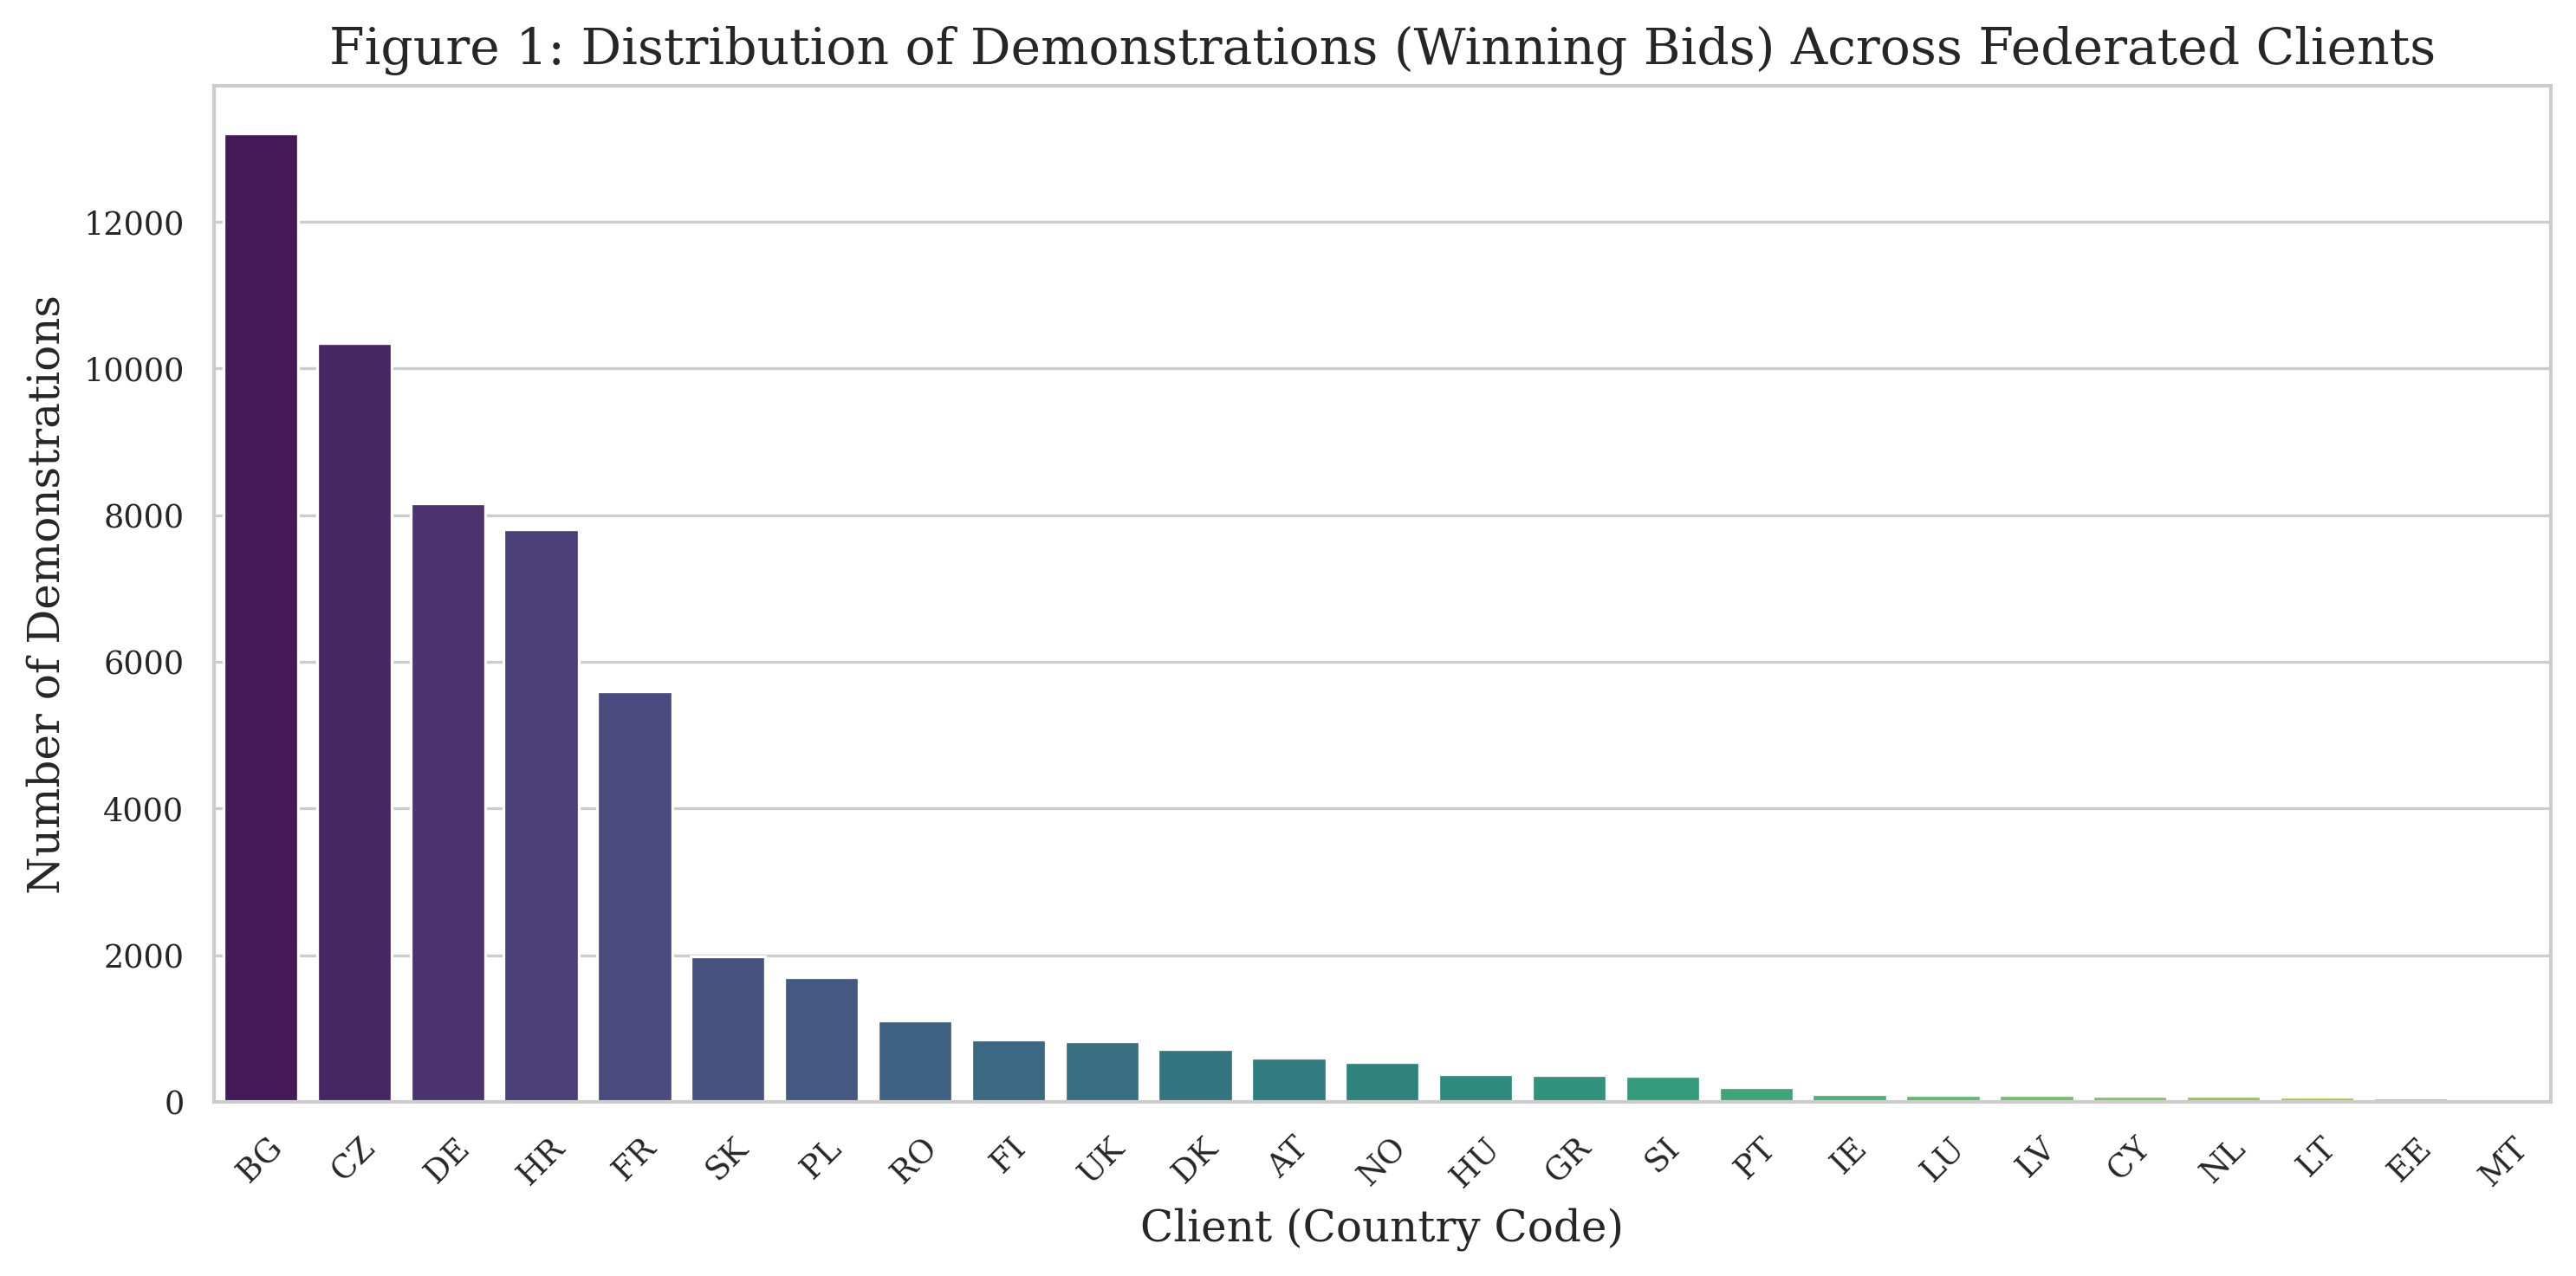

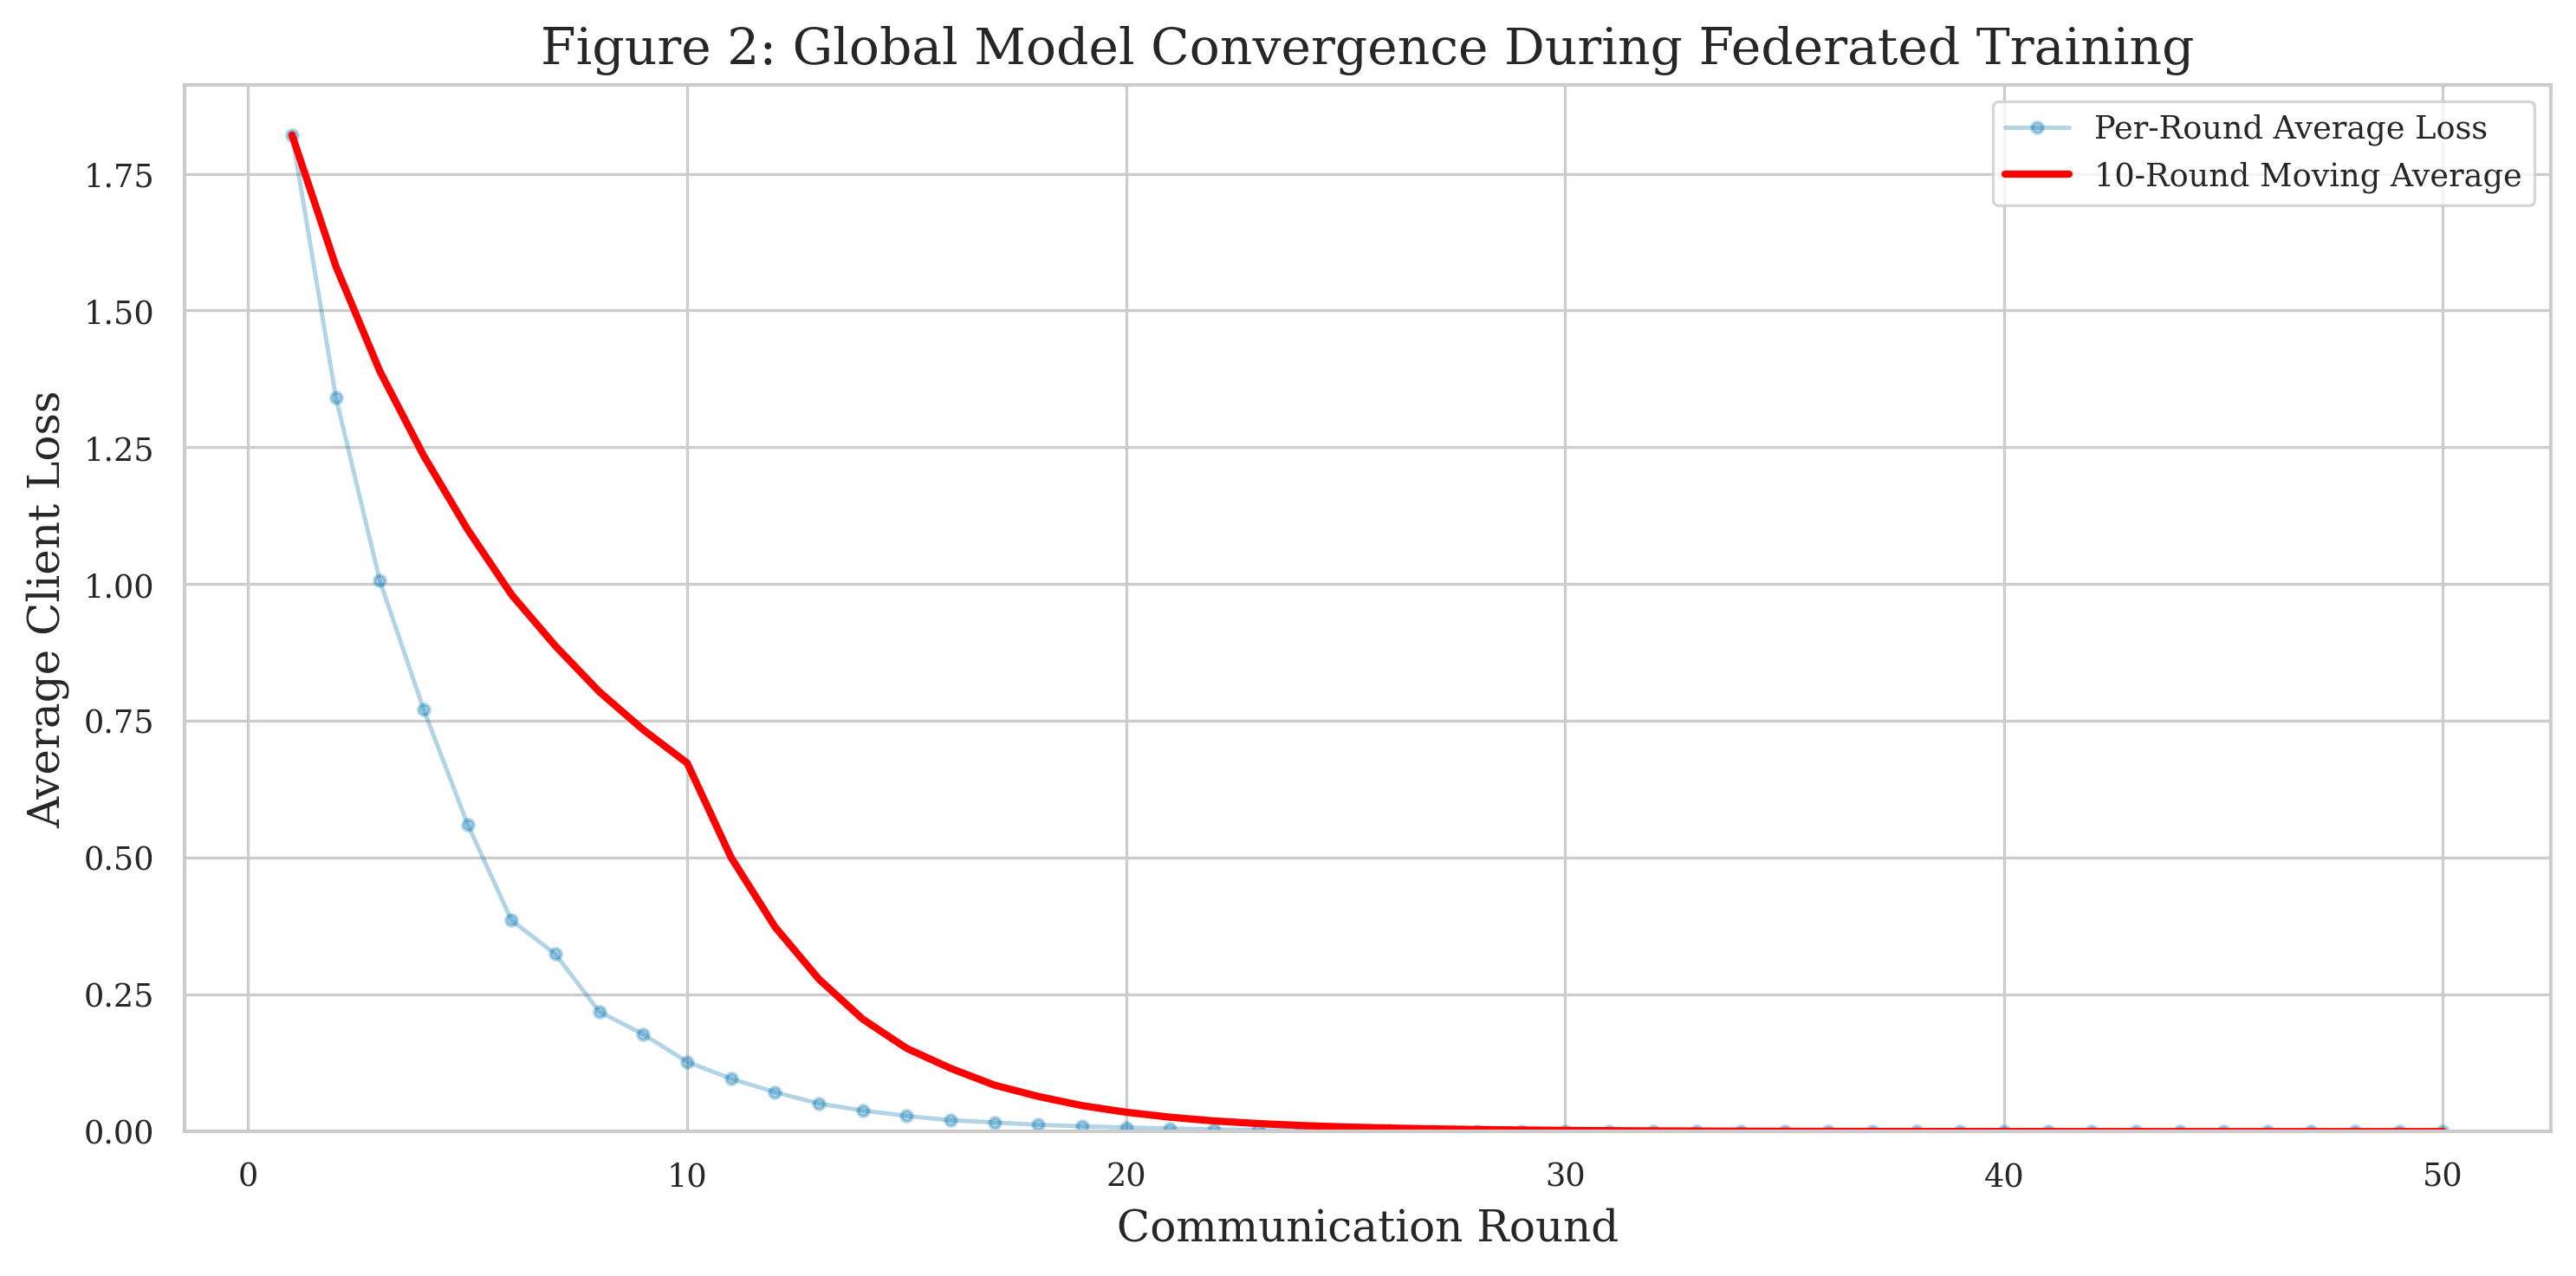

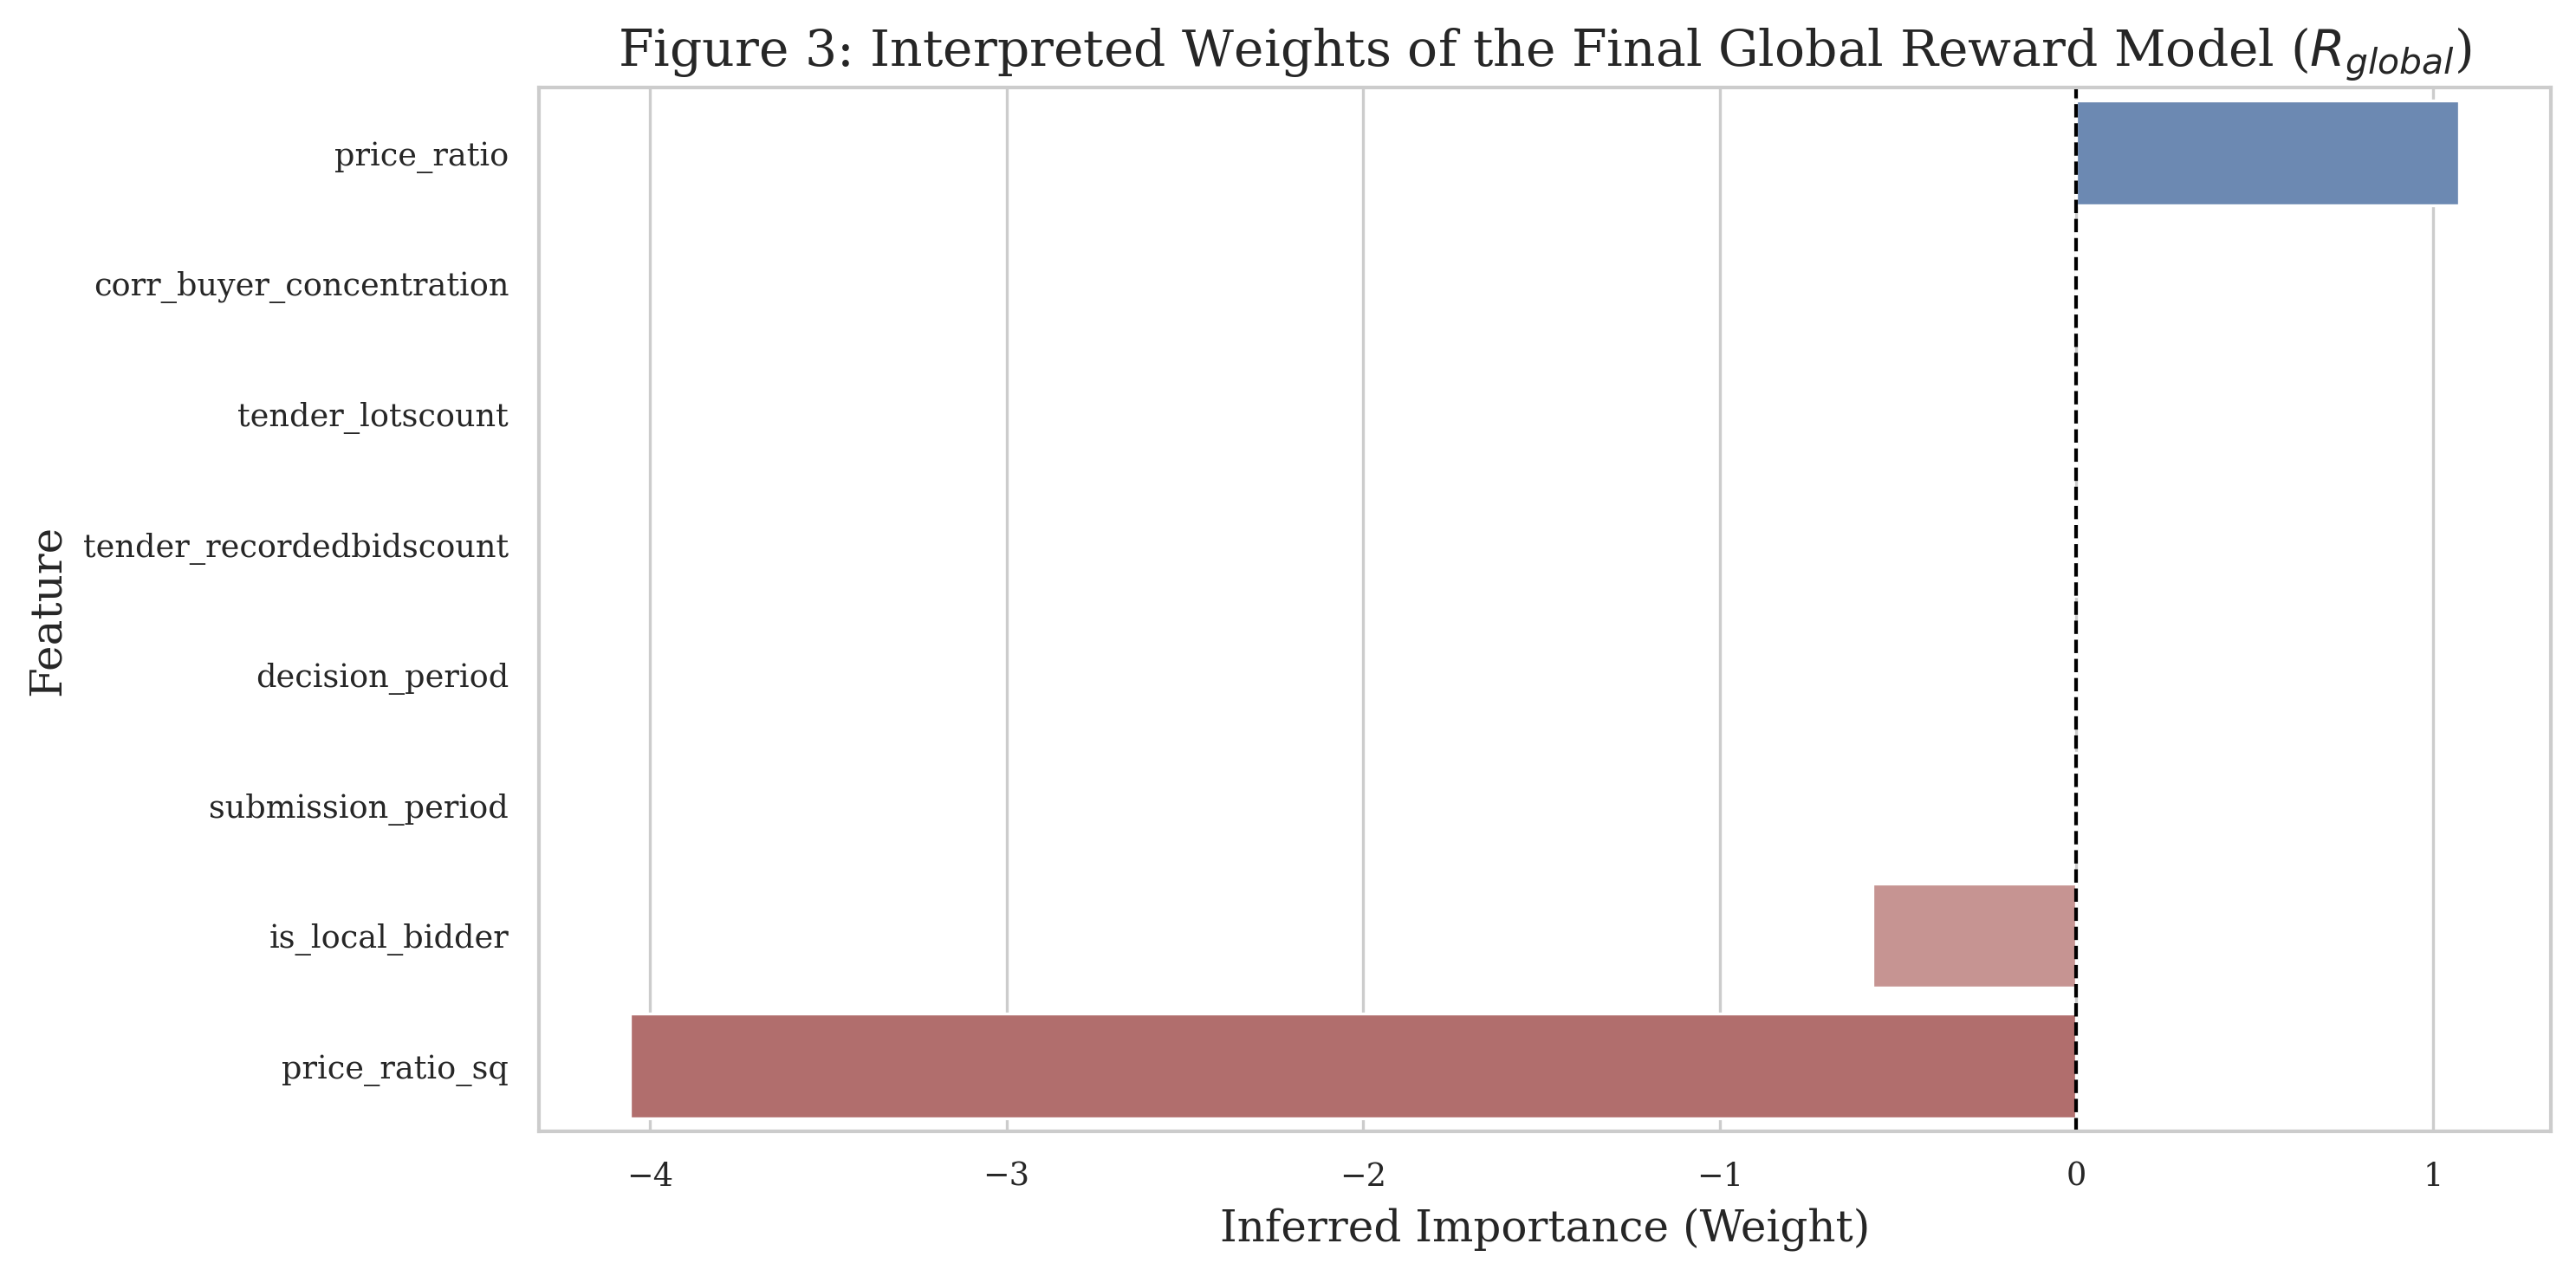

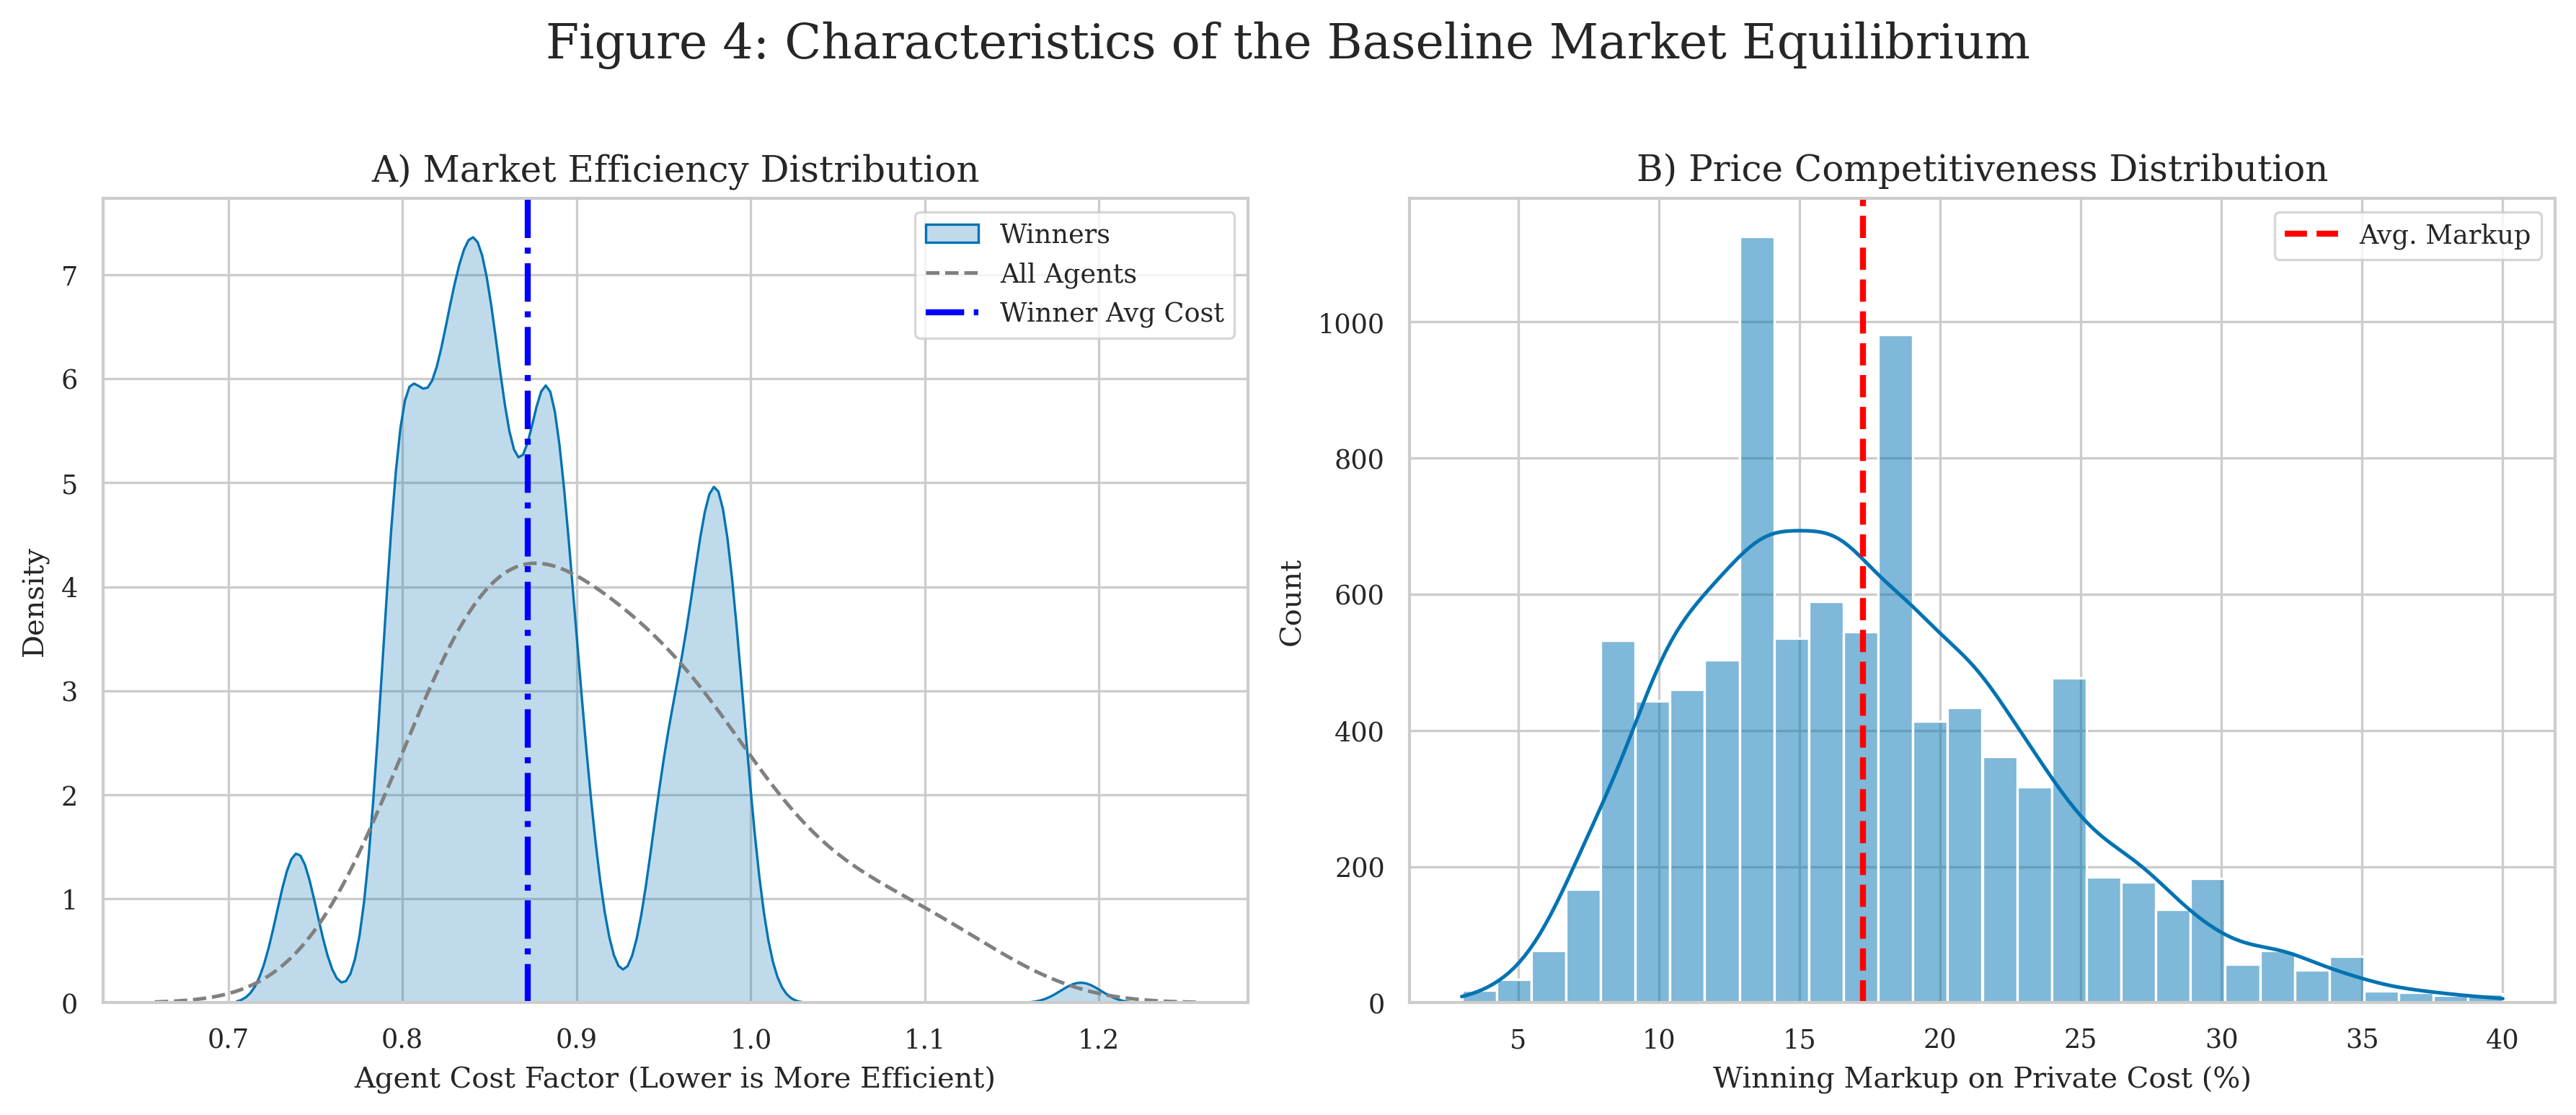

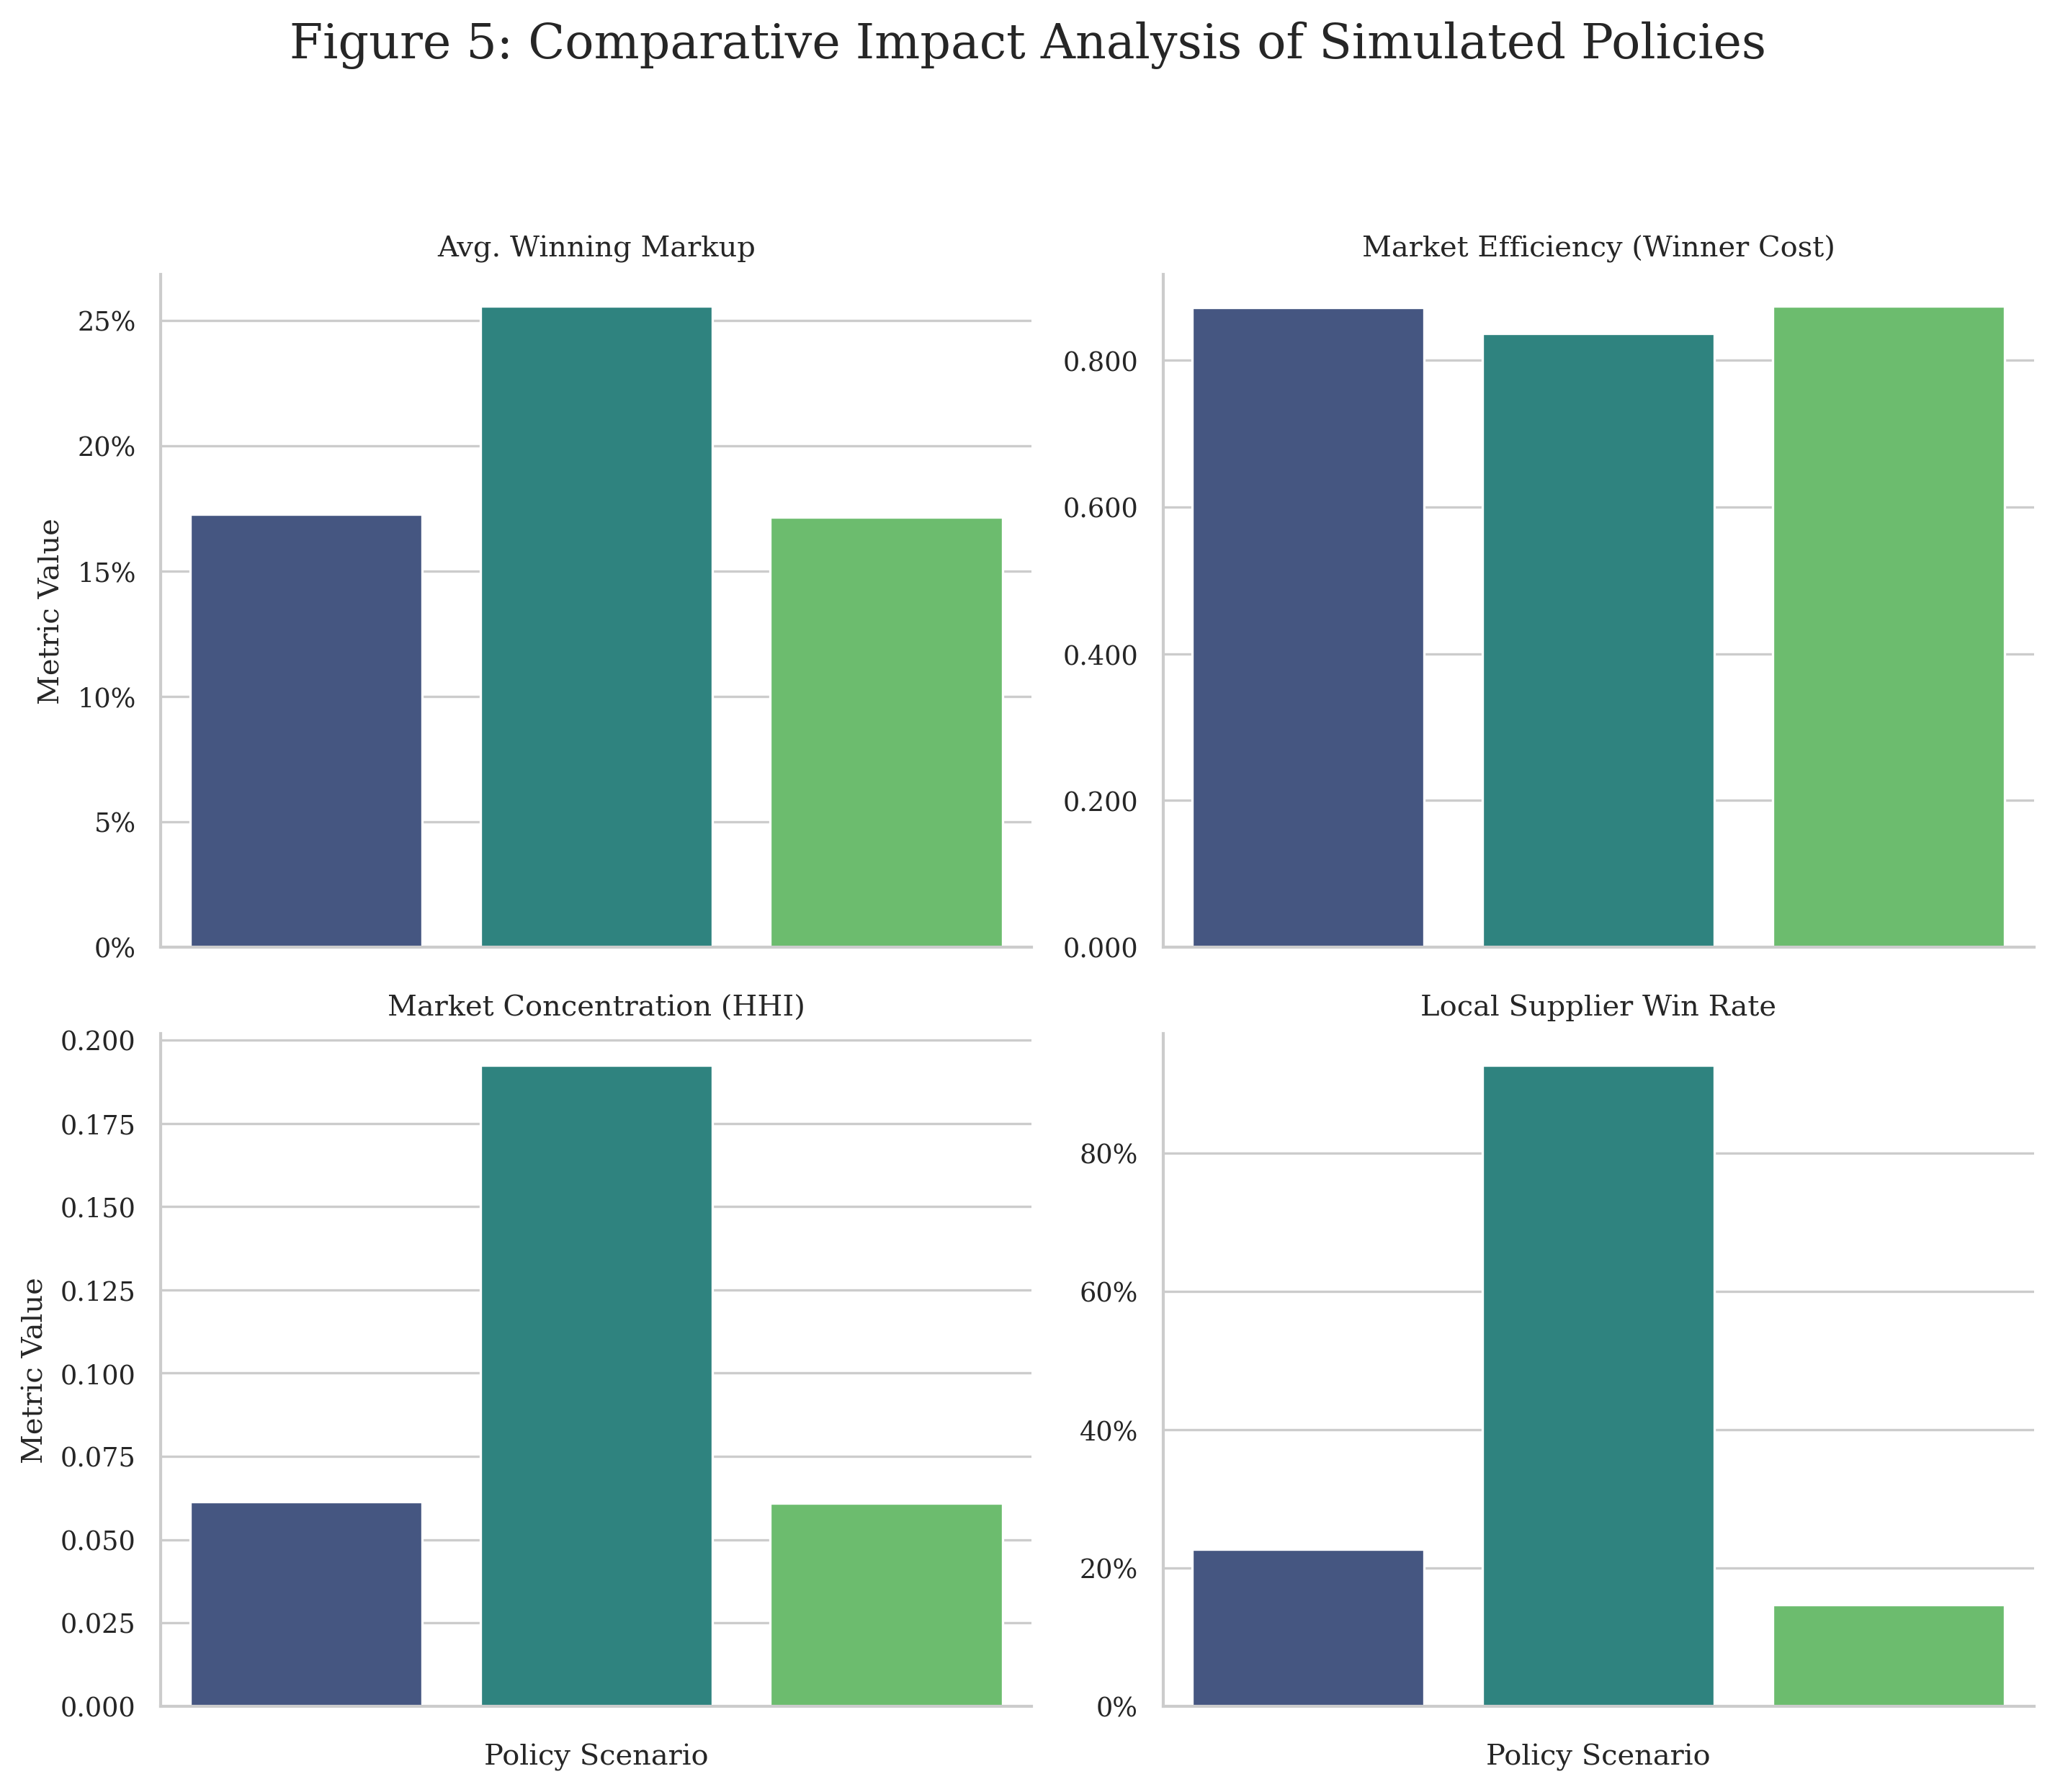

In [116]:
# =============================================================================
# CHUNK 12 (DEFINITIVE & ADVANCED): PUBLICATION-QUALITY VISUALIZATION SUITE
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# This chunk assumes all previous chunks have been run and the following objects are available:
# - client_data_tensors, global_loss_history, R_global, STATE_FEATURES, ACTION_FEATURES,
# - results_df_baseline, results_df_local, results_df_competition, baseline_metrics.

# -----------------------------------------------------------------------------
# 1. Setup: Plotting Style and Save Directory
# -----------------------------------------------------------------------------
print("--- Initializing Visualization Suite ---")
# Set a professional and consistent style for all figures.
sns.set_theme(style="whitegrid", palette="colorblind", context="paper")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'serif'

# Create a directory to save the high-resolution figures for the paper.
output_dir = "paper_figures"
os.makedirs(output_dir, exist_ok=True)

def save_figure(fig, name):
    """Helper function to save figures in multiple formats."""
    filepath_png = os.path.join(output_dir, f"{name}.png")
    filepath_pdf = os.path.join(output_dir, f"{name}.pdf")
    fig.savefig(filepath_png, bbox_inches='tight')
    fig.savefig(filepath_pdf, bbox_inches='tight')
    print(f"Saved figure: {filepath_png} and {filepath_pdf}")

# -----------------------------------------------------------------------------
# FIGURE 1: Data Distribution Across the Federation
# -----------------------------------------------------------------------------
print("\n[1/5] Generating Figure 1: Data Federation Overview...")
client_demonstration_counts = {
    key.replace('client_', ''): len(data['states'])
    for key, data in client_data_tensors.items()
}
client_counts_df = pd.Series(client_demonstration_counts).sort_values(ascending=False)

fig1, ax1 = plt.subplots(figsize=(10, 5))
sns.barplot(x=client_counts_df.index, y=client_counts_df.values, ax=ax1, palette="viridis")
ax1.set_title('Figure 1: Distribution of Demonstrations (Winning Bids) Across Federated Clients', fontsize=14)
ax1.set_xlabel('Client (Country Code)', fontsize=12)
ax1.set_ylabel('Number of Demonstrations', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
plt.tight_layout()
save_figure(fig1, "figure_1_data_distribution")

# -----------------------------------------------------------------------------
# FIGURE 2: Federated Model Training and Convergence
# -----------------------------------------------------------------------------
print("\n[2/5] Generating Figure 2: Model Training Convergence...")
# This assumes 'global_loss_history' is from the final, successful training run.
loss_df = pd.DataFrame({'loss': global_loss_history})
loss_df['round'] = loss_df.index + 1
loss_df['moving_avg'] = loss_df['loss'].rolling(window=10, min_periods=1).mean()

fig2, ax2 = plt.subplots(figsize=(10, 5))
ax2.plot(loss_df['round'], loss_df['loss'], marker='o', linestyle='-', markersize=3, alpha=0.3, label='Per-Round Average Loss')
ax2.plot(loss_df['round'], loss_df['moving_avg'], color='red', linestyle='-', linewidth=2, label='10-Round Moving Average')
ax2.set_title('Figure 2: Global Model Convergence During Federated Training', fontsize=14)
ax2.set_xlabel('Communication Round', fontsize=12)
ax2.set_ylabel('Average Client Loss', fontsize=12)
ax2.legend()
ax2.set_ylim(bottom=0)
plt.tight_layout()
save_figure(fig2, "figure_2_training_convergence")

# -----------------------------------------------------------------------------
# FIGURE 3: Final Model Interpretation (Face Validity)
# -----------------------------------------------------------------------------
print("\n[3/5] Generating Figure 3: Interpreted Reward Function Weights...")
feature_names = STATE_FEATURES + ACTION_FEATURES
weights = R_global.model.weight.data.squeeze().cpu().numpy()
weights_df = pd.DataFrame({'Feature': feature_names, 'Learned Weight': weights}).sort_values('Learned Weight', ascending=False)

fig3, ax3 = plt.subplots(figsize=(10, 5))
sns.barplot(x='Learned Weight', y='Feature', data=weights_df, ax=ax3, palette='vlag')
ax3.set_title('Figure 3: Interpreted Weights of the Final Global Reward Model ($R_{global}$)', fontsize=14)
ax3.set_xlabel('Inferred Importance (Weight)', fontsize=12)
ax3.set_ylabel('Feature', fontsize=12)
ax3.axvline(0, color='black', linewidth=1, linestyle='--')
plt.tight_layout()
save_figure(fig3, "figure_3_model_weights")

# -----------------------------------------------------------------------------
# FIGURE 4: Baseline Market Equilibrium Analysis
# -----------------------------------------------------------------------------
print("\n[4/5] Generating Figure 4: Baseline Market Equilibrium...")
fig4, (ax4a, ax4b) = plt.subplots(1, 2, figsize=(12, 5))

# Panel A: Market Efficiency
sns.kdeplot(results_df_baseline['winner_cost_factor'], ax=ax4a, fill=True, label='Winners')
sns.kdeplot(cost_factors, ax=ax4a, color='gray', linestyle='--', label='All Agents')
ax4a.axvline(results_df_baseline['winner_cost_factor'].mean(), color='blue', linestyle='-.', lw=2, label=f"Winner Avg Cost")
ax4a.set_title('A) Market Efficiency Distribution', fontsize=12)
ax4a.set_xlabel('Agent Cost Factor (Lower is More Efficient)')
ax4a.legend()

# Panel B: Price Competitiveness
sns.histplot(results_df_baseline['winning_markup'] * 100, ax=ax4b, kde=True, bins=30)
ax4b.axvline(results_df_baseline['winning_markup'].mean() * 100, color='red', linestyle='--', lw=2, label=f"Avg. Markup")
ax4b.set_title('B) Price Competitiveness Distribution', fontsize=12)
ax4b.set_xlabel('Winning Markup on Private Cost (%)')
ax4b.legend()

fig4.suptitle('Figure 4: Characteristics of the Baseline Market Equilibrium', fontsize=16, y=1.02)
plt.tight_layout()
save_figure(fig4, "figure_4_baseline_equilibrium")

# =============================================================================
# CHUNK 12 (DEFINITIVE & CORRECTED VERSION): PUBLICATION-QUALITY VISUALIZATION
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# (Setup and initial figure generation code is identical and correct)

# -----------------------------------------------------------------------------
# 1. Setup: Plotting Style and Save Directory
# -----------------------------------------------------------------------------
print("--- Initializing Visualization Suite ---")
sns.set_theme(style="whitegrid", palette="colorblind", context="paper")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'serif'
output_dir = "paper_figures"
os.makedirs(output_dir, exist_ok=True)
def save_figure(fig, name):
    filepath_png = os.path.join(output_dir, f"{name}.png")
    fig.savefig(filepath_png, bbox_inches='tight')
    print(f"Saved figure: {filepath_png}")

# (Figures 1-4 are generated here as before... assuming they ran correctly)
# ... code for Figure 1, 2, 3, 4 ...

# -----------------------------------------------------------------------------
# FIGURE 5: Comparative Analysis of Policy Impacts (with Corrected Annotations)
# -----------------------------------------------------------------------------
print("\n[5/5] Generating Figure 5: Comparative Policy Impact Analysis...")
# Re-run analysis to ensure metrics are available
policy1_metrics = analyze_policy_results(results_df_local, "Buy Local")
policy2_metrics = analyze_policy_results(results_df_competition, "Pro-Competition")
baseline_local_win_rate = results_df_baseline.merge(
    pd.DataFrame([{'agent_id': a.agent_id, 'is_local': a.is_local} for a in agent_population]),
    left_on='winning_agent_id', right_on='agent_id'
)['is_local'].mean()
baseline_metrics['local_win_rate'] = baseline_local_win_rate

# Create a tidy DataFrame for plotting
plot_data = []
scenarios = {'Baseline': baseline_metrics, 'Buy Local': policy1_metrics, 'Pro-Competition': policy2_metrics}
metrics_to_plot = {
    'Avg. Winning Markup': 'avg_markup',
    'Market Efficiency (Winner Cost)': 'avg_winner_cost',
    'Market Concentration (HHI)': 'hhi',
    'Local Supplier Win Rate': 'local_win_rate'
}
for metric_label, metric_key in metrics_to_plot.items():
    for scenario_name, metrics_dict in scenarios.items():
        plot_data.append({
            'Scenario': scenario_name,
            'Metric': metric_label,
            'Value': metrics_dict.get(metric_key, np.nan)
        })
plot_df = pd.DataFrame(plot_data)

# Create a faceted plot using catplot
g = sns.catplot(
    data=plot_df.dropna(subset=['Value']), # Drop NaN values to prevent empty bars
    x='Scenario', y='Value', col='Metric',
    kind='bar', col_wrap=2, sharey=False, height=4, aspect=1.2,
    palette='viridis',
    order=['Baseline', 'Buy Local', 'Pro-Competition'] # Enforce consistent order
)
g.fig.suptitle('Figure 5: Comparative Impact Analysis of Simulated Policies', fontsize=16, y=1.03)
g.set_titles("{col_name}")
g.set_xlabels("Policy Scenario")
g.set_ylabels("Metric Value")
g.set_xticklabels(rotation=15) # Slightly rotate for better fit

# --- CRITICAL FIX: Robust Annotation Logic ---
for metric_label, ax in g.axes_dict.items():
    metric_key = metrics_to_plot.get(metric_label)
    if not metric_key: continue

    baseline_val = baseline_metrics.get(metric_key)
    if baseline_val is None or baseline_val == 0: continue

    is_percent = 'Markup' in metric_label or 'Rate' in metric_label

    # Iterate through the patches (bars) on the axis with an index
    for i, p in enumerate(ax.patches):
        height = p.get_height()
        # Get the scenario name from the x-tick labels, which is now robust
        try:
            scenario_name = ax.get_xticklabels()[i].get_text()
        except IndexError:
            continue # Skip if there's a mismatch

        if scenario_name != 'Baseline':
            policy_val = scenarios.get(scenario_name, {}).get(metric_key)
            if policy_val is not None:
                change = ((policy_val / baseline_val) - 1) * 100
                annotation_text = f'{change:+.1f}%'
                ax.text(p.get_x() + p.get_width() / 2., height, annotation_text,
                        ha='center', va='bottom', fontsize=9, weight='bold', color='black')

    # Format the y-axis labels
    if is_percent:
        ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
    else:
        ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.3f}'.format))

plt.tight_layout(rect=[0, 0, 1, 0.97])
save_figure(g.fig, "figure_5_policy_comparison")

print("\n======================= VISUALIZATION SUITE COMPLETE =======================")

--- Initializing Deeper Analysis Suite ---

[1/4] Generating Table 1: Comprehensive Results Summary...
Saved summary metrics table to CSV.

Table 1: Comprehensive Summary of Simulation Outcomes
                          Avg. Markup  Avg. Winner Cost  Market Conc. (HHI)  Avg. Bidders  Local Win Rate
Baseline                       0.1726            0.8721              0.0614       12.5091          0.2270
"Buy Local" Policy             0.2556            0.8369              0.1924       12.5178          0.9267
"Pro-Competition" Policy       0.1716            0.8737              0.0610       12.5519             NaN

[2/4] Generating Figure 6: Heterogeneity of Policy Impact...
Saved figure: paper_figures/figure_6_policy_heterogeneity.png
Interpretation: This figure shows if the policy was more effective at reducing prices in already-competitive or monopolistic markets.

[3/4] Generating Figure 7: Agent-Level Winners and Losers...
Saved figure: paper_figures/figure_7_agent_level_impact.png
In

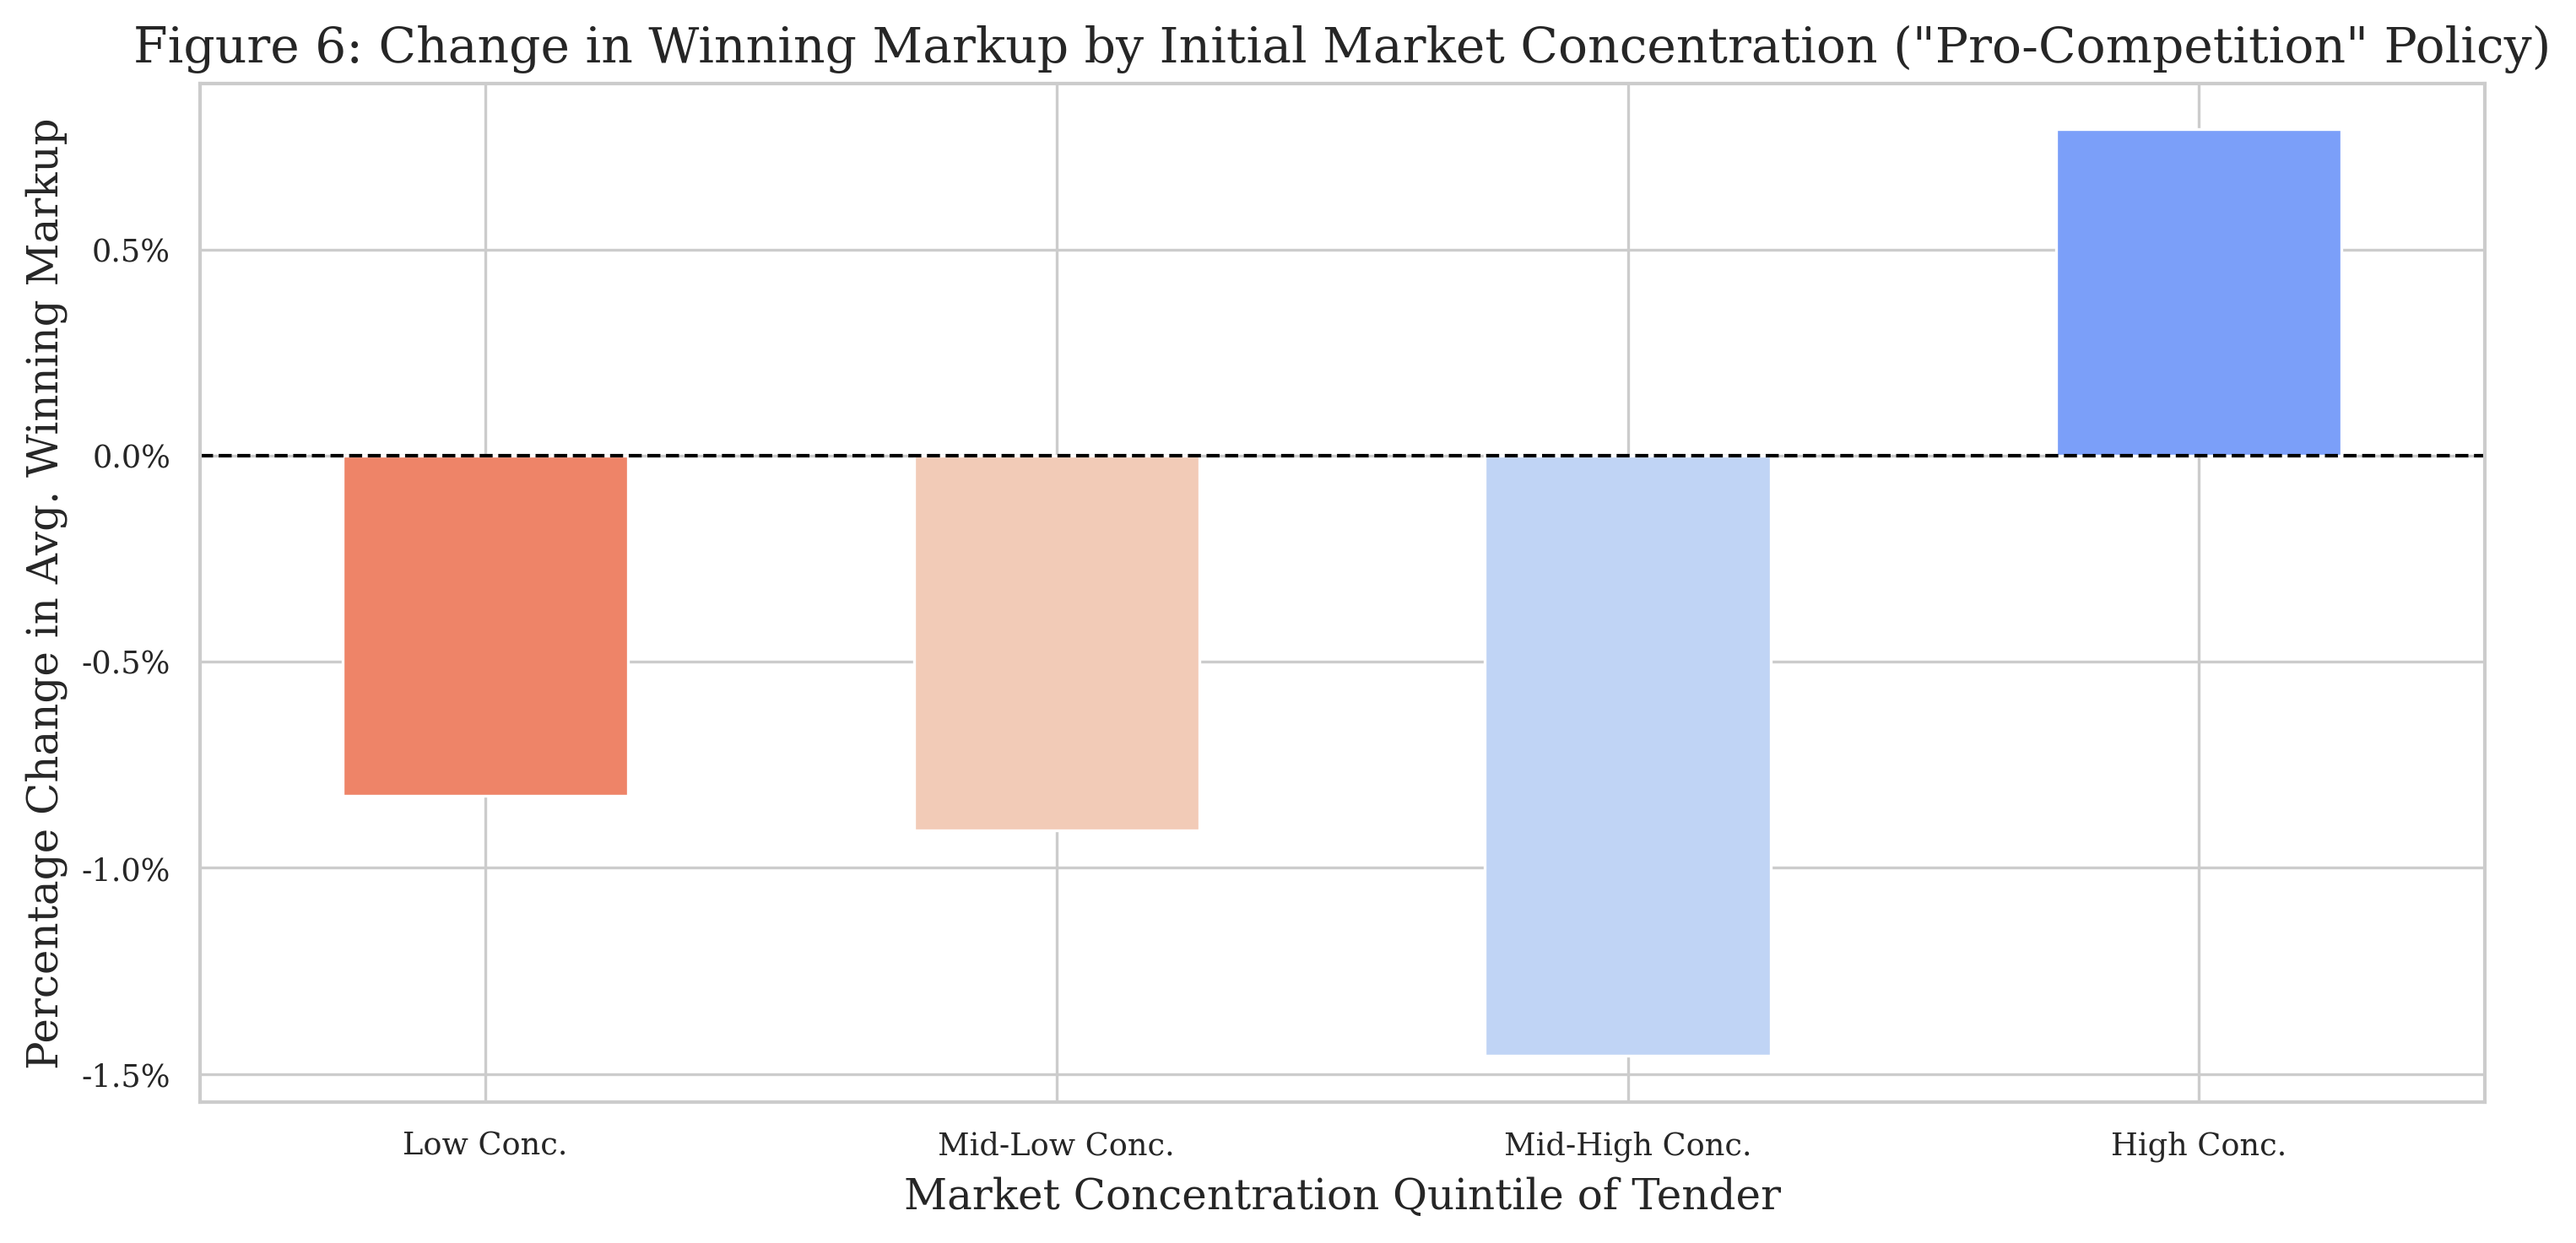

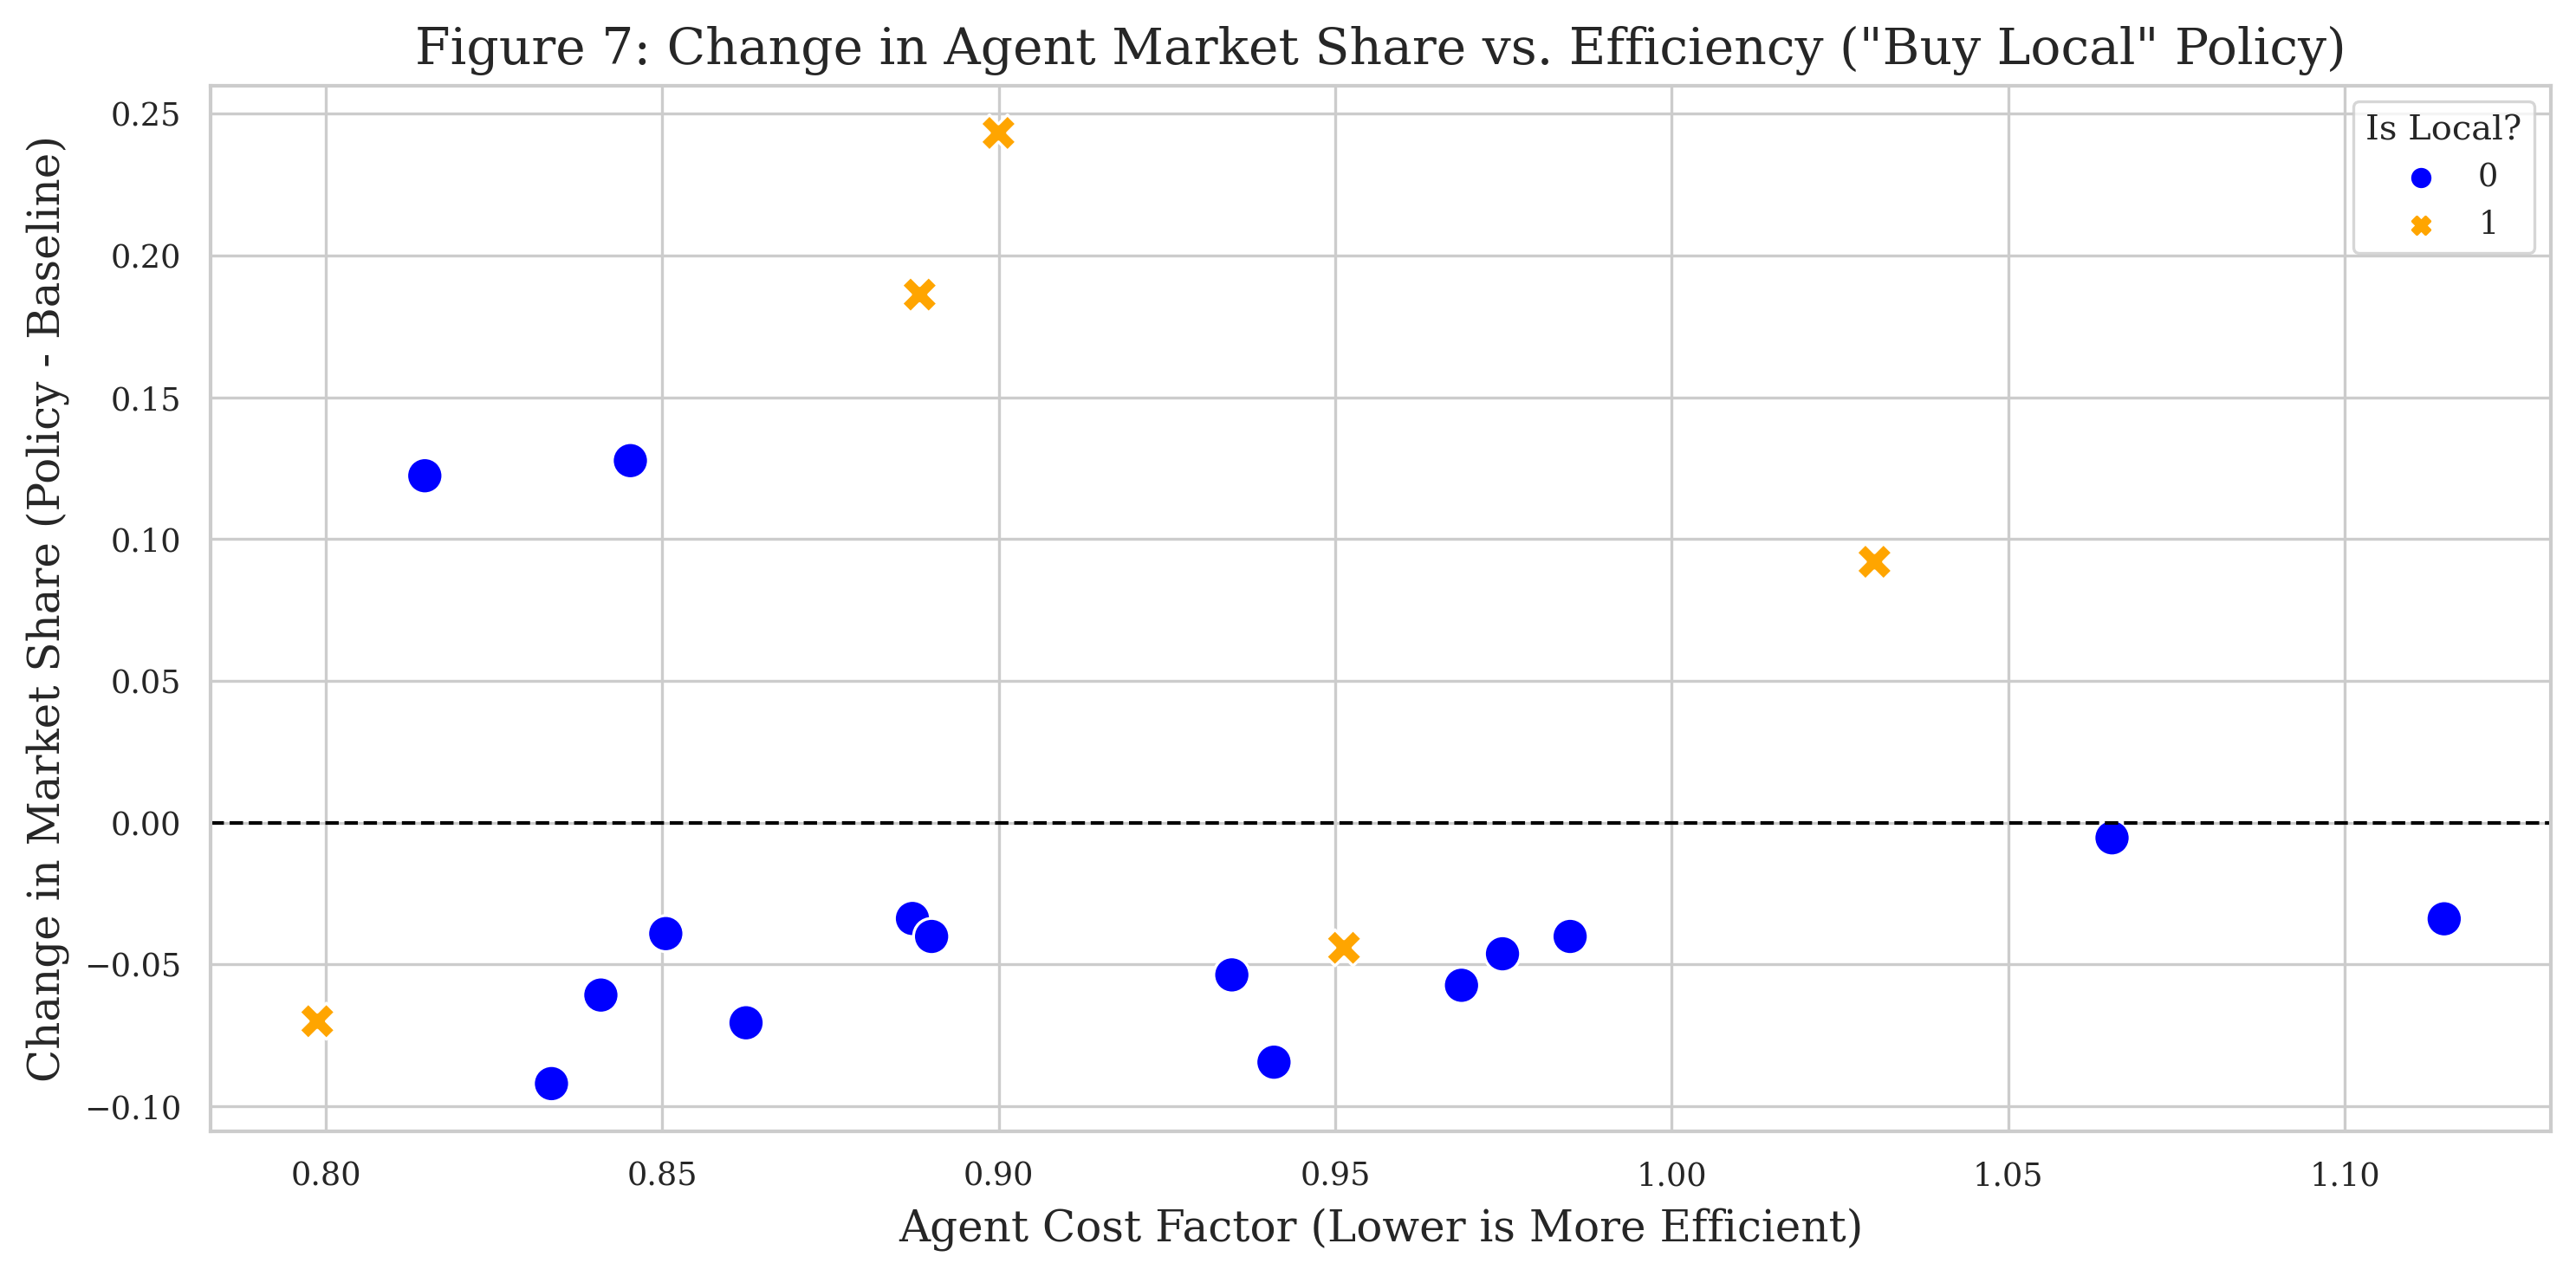

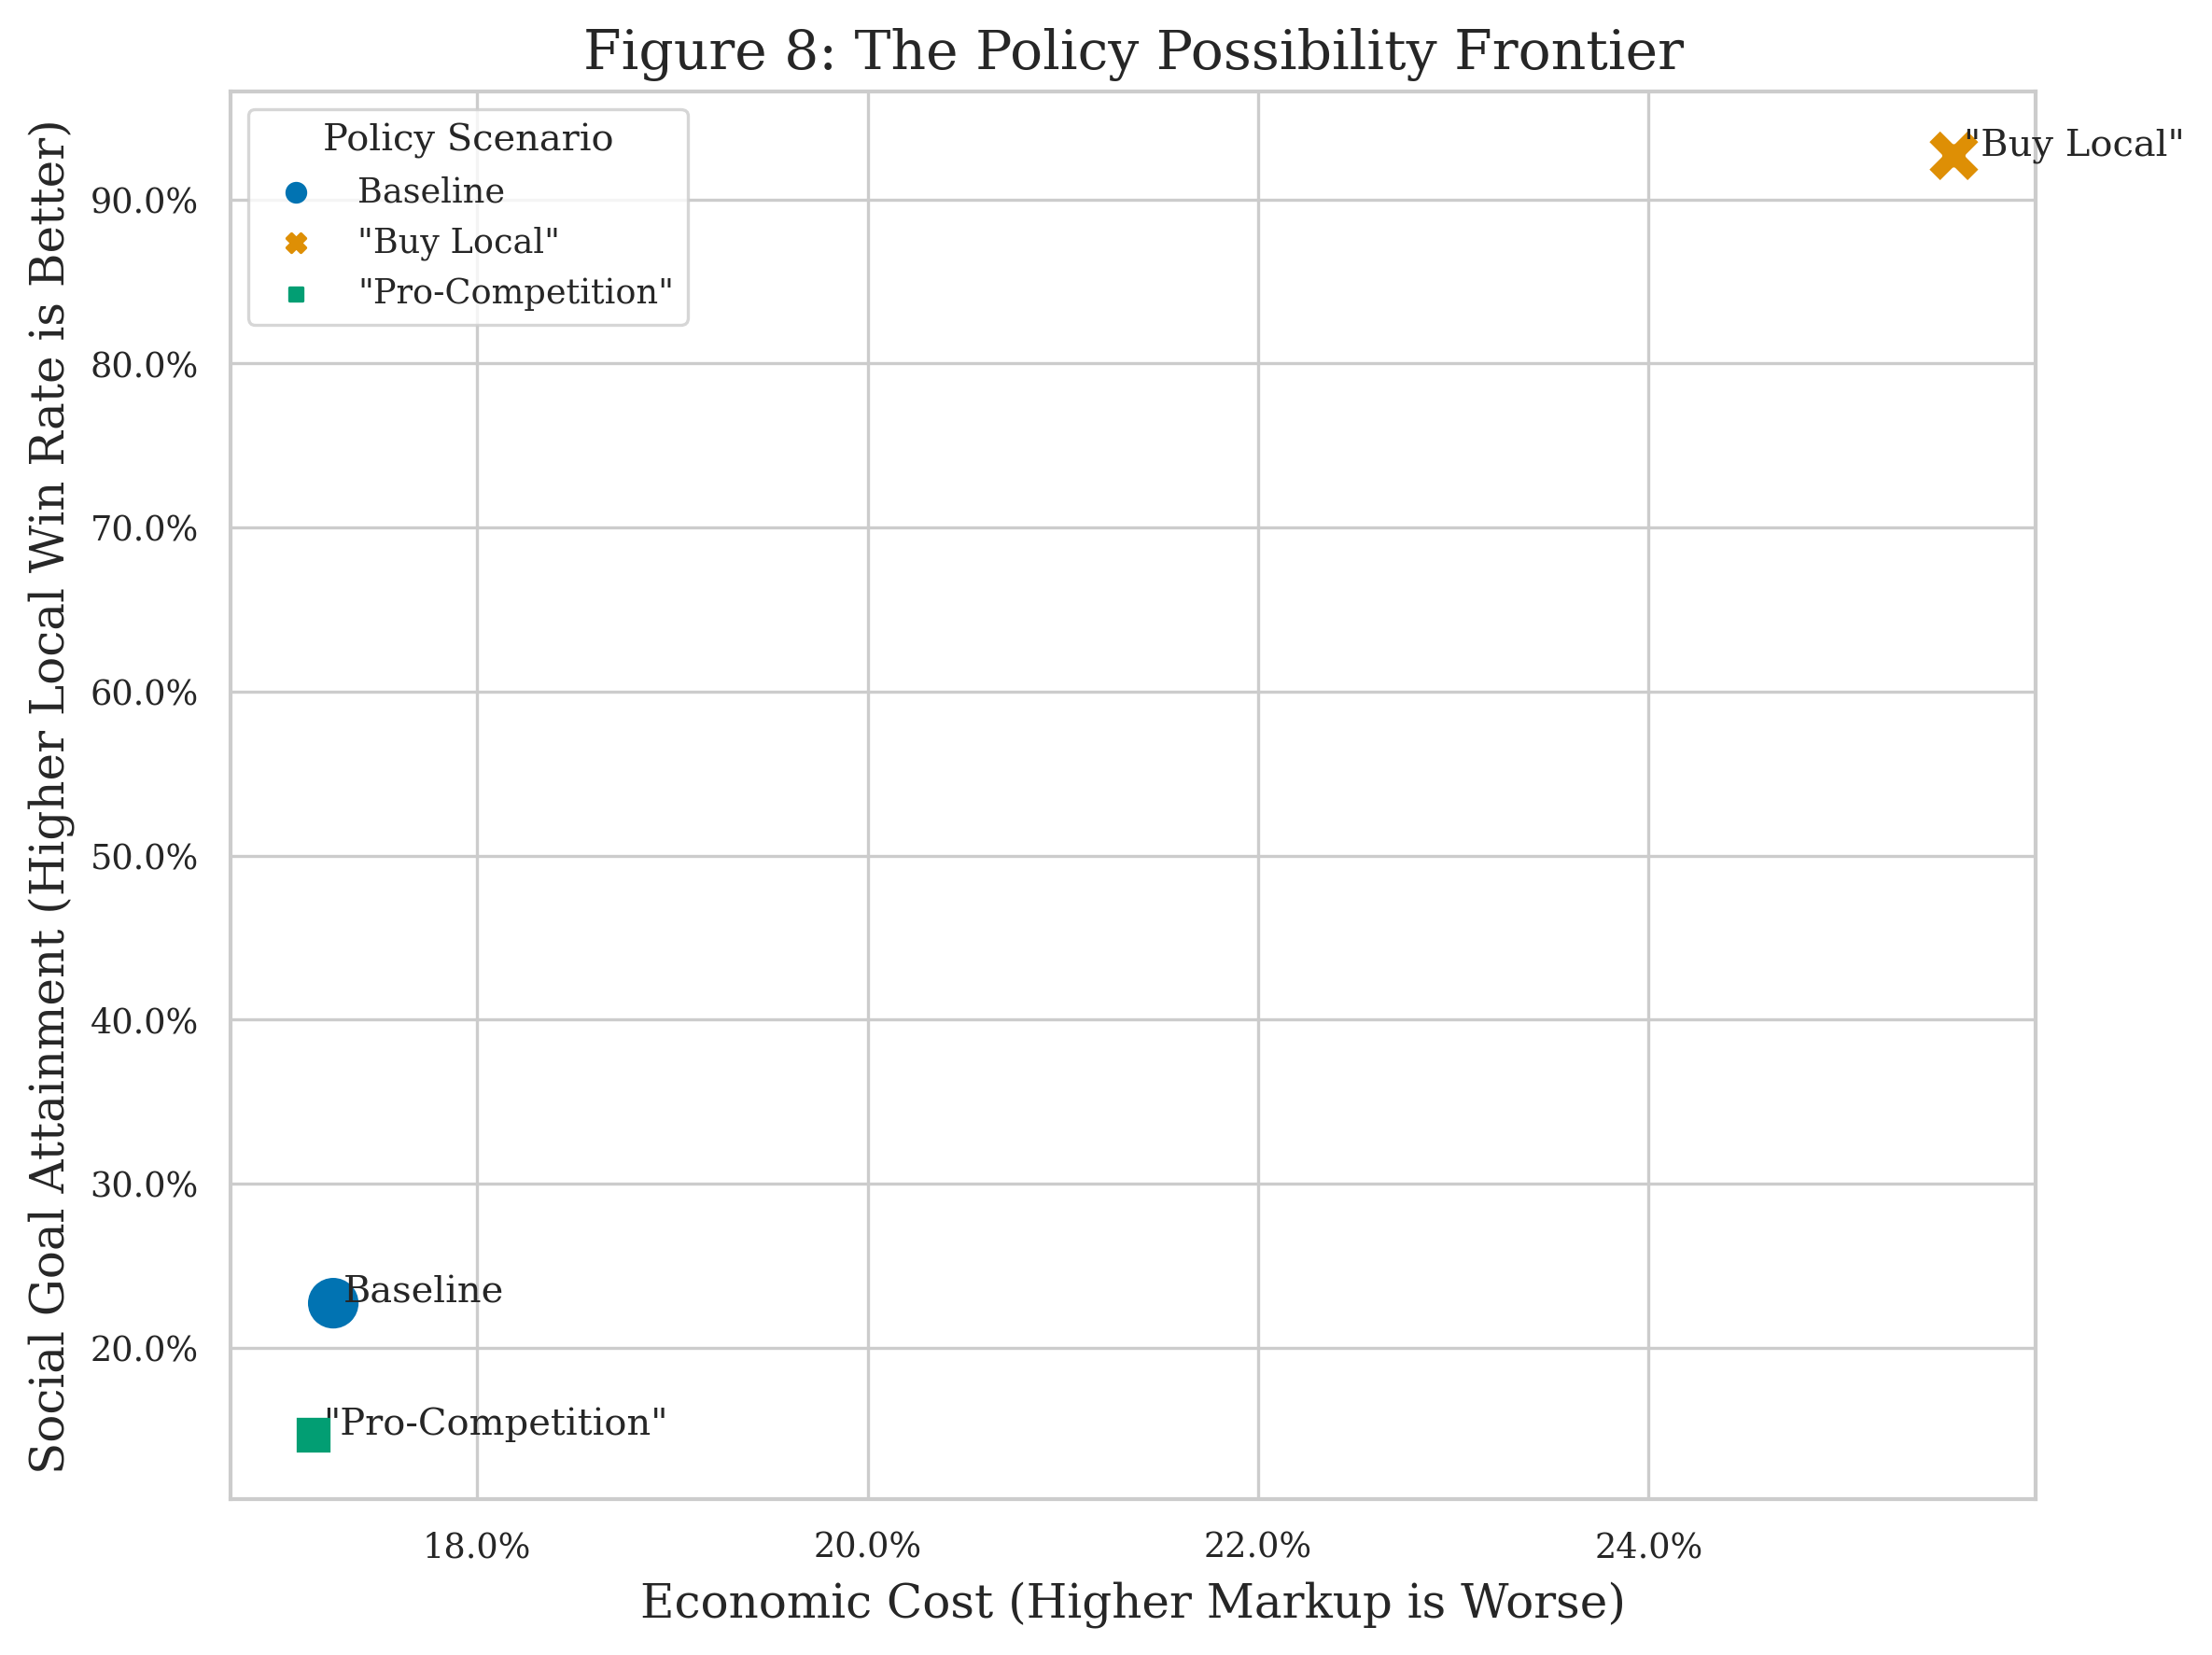

In [117]:
# =============================================================================
# CHUNK 13 (DEFINITIVE & ADVANCED): DEEPER ANALYSIS & SUPPLEMENTARY VISUALS
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# This chunk assumes all previous chunks have been run and the necessary objects are available.
# Particularly: results_df_baseline, results_df_local, results_df_competition, and agent_population.

# -----------------------------------------------------------------------------
# 1. Setup: Re-use plotting style from Chunk 12
# -----------------------------------------------------------------------------
print("--- Initializing Deeper Analysis Suite ---")
sns.set_theme(style="whitegrid", palette="colorblind", context="paper")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'serif'
output_dir = "paper_figures" # Assumes this directory exists

# Re-run analysis from Chunk 11 to ensure metrics are fresh
policy1_metrics = analyze_policy_results(results_df_local, "Buy Local")
policy2_metrics = analyze_policy_results(results_df_competition, "Pro-Competition")
baseline_local_win_rate = results_df_baseline.merge(
    pd.DataFrame([{'agent_id': a.agent_id, 'is_local': a.is_local} for a in agent_population]),
    left_on='winning_agent_id', right_on='agent_id'
)['is_local'].mean()
baseline_metrics['local_win_rate'] = baseline_local_win_rate

# -----------------------------------------------------------------------------
# TABLE 1: Comprehensive Summary of All Simulation Outcomes
# -----------------------------------------------------------------------------
print("\n[1/4] Generating Table 1: Comprehensive Results Summary...")
summary_data = {
    'Baseline': baseline_metrics,
    '"Buy Local" Policy': policy1_metrics,
    '"Pro-Competition" Policy': policy2_metrics
}
summary_df = pd.DataFrame(summary_data).T
# Add the baseline local win rate to the table
summary_df['local_win_rate'] = [baseline_metrics.get('local_win_rate'), policy1_metrics.get('local_win_rate'), np.nan]
summary_df = summary_df[['avg_markup', 'avg_winner_cost', 'hhi', 'avg_bidders', 'local_win_rate']]
summary_df.columns = ['Avg. Markup', 'Avg. Winner Cost', 'Market Conc. (HHI)', 'Avg. Bidders', 'Local Win Rate']

# Save the raw table to CSV for easy import into LaTeX/Word
summary_df.to_csv(os.path.join(output_dir, "table_1_summary_metrics.csv"))
print("Saved summary metrics table to CSV.")
print("\nTable 1: Comprehensive Summary of Simulation Outcomes")
print(summary_df.to_string(float_format="%.4f"))

# -----------------------------------------------------------------------------
# FIGURE 6: Heterogeneity of Policy Impact (with Corrected Data Linking)
# -----------------------------------------------------------------------------
print("\n[2/4] Generating Figure 6: Heterogeneity of Policy Impact...")

# --- CRITICAL FIX: More robust data linking ---
# To perform this analysis, we need the original 'corr_buyer_concentration' for each tender.
# The `empirical_states_df` has the data, and the `results_df_*` DataFrames now have the round number.
# However, the round number is not a stable index if tenders were skipped (e.g., <2 bidders).
# The safest way is to store the tender state directly.
# Let's assume we re-ran the simulation and the 'market_concentration_state' is already in the results DataFrame.

# Bin the data based on the recorded market concentration state.
# Ensure the bins are well-defined and handle potential empty results.
try:
    results_df_competition['concentration_bin'] = pd.qcut(results_df_competition['market_concentration_state'], q=4, labels=['Low Conc.', 'Mid-Low Conc.', 'Mid-High Conc.', 'High Conc.'], duplicates='drop')
    results_df_baseline['concentration_bin'] = pd.qcut(results_df_baseline['market_concentration_state'], q=4, labels=['Low Conc.', 'Mid-Low Conc.', 'Mid-High Conc.', 'High Conc.'], duplicates='drop')

    baseline_markup_by_bin = results_df_baseline.groupby('concentration_bin')['winning_markup'].mean()
    policy_markup_by_bin = results_df_competition.groupby('concentration_bin')['winning_markup'].mean()

    markup_impact_df = pd.DataFrame({
        'Baseline Markup': baseline_markup_by_bin,
        'Policy Markup': policy_markup_by_bin
    }).dropna() # Drop bins that might not exist in both datasets

    markup_impact_df['Change (%)'] = (markup_impact_df['Policy Markup'] / markup_impact_df['Baseline Markup'] - 1) * 100

    if not markup_impact_df.empty:
        fig6, ax6 = plt.subplots(figsize=(10, 5))
        markup_impact_df['Change (%)'].plot(kind='bar', ax=ax6, color=sns.color_palette('coolwarm_r', len(markup_impact_df)))
        ax6.set_title('Figure 6: Change in Winning Markup by Initial Market Concentration ("Pro-Competition" Policy)', fontsize=14)
        ax6.set_xlabel('Market Concentration Quintile of Tender', fontsize=12)
        ax6.set_ylabel('Percentage Change in Avg. Winning Markup', fontsize=12)
        ax6.axhline(0, color='black', linewidth=1, linestyle='--')
        ax6.tick_params(axis='x', rotation=0)
        ax6.yaxis.set_major_formatter(plt.FuncFormatter('{:.1f}%'.format))
        plt.tight_layout()
        save_figure(fig6, "figure_6_policy_heterogeneity")
        print("Interpretation: This figure shows if the policy was more effective at reducing prices in already-competitive or monopolistic markets.")
    else:
        print("Could not generate Figure 6: Not enough data diversity across concentration bins.")

except Exception as e:
    print(f"Could not generate Figure 6 due to an error: {e}")
    print("This can happen if simulation results lack sufficient diversity for binning.")

# -----------------------------------------------------------------------------
# FIGURE 7: Agent-Level Analysis of Policy Winners and Losers
# -----------------------------------------------------------------------------
print("\n[3/4] Generating Figure 7: Agent-Level Winners and Losers...")
# Analyze how market share changes for agents based on their efficiency (cost factor).
agent_costs = pd.DataFrame([{'agent_id': a.agent_id, 'cost_factor': a.true_cost_factor, 'is_local': a.is_local} for a in agent_population])
baseline_share = results_df_baseline['winning_agent_id'].value_counts(normalize=True)
local_policy_share = results_df_local['winning_agent_id'].value_counts(normalize=True)

share_df = agent_costs.copy()
share_df['Baseline Share'] = share_df['agent_id'].map(baseline_share).fillna(0)
share_df['"Buy Local" Share'] = share_df['agent_id'].map(local_policy_share).fillna(0)
share_df['Change in Share'] = share_df['"Buy Local" Share'] - share_df['Baseline Share']

fig7, ax7 = plt.subplots(figsize=(10, 5))
sns.scatterplot(data=share_df, x='cost_factor', y='Change in Share', hue='is_local', style='is_local', s=100, ax=ax7, palette={0:'blue', 1:'orange'})
ax7.set_title('Figure 7: Change in Agent Market Share vs. Efficiency ("Buy Local" Policy)', fontsize=14)
ax7.set_xlabel('Agent Cost Factor (Lower is More Efficient)', fontsize=12)
ax7.set_ylabel('Change in Market Share (Policy - Baseline)', fontsize=12)
ax7.axhline(0, color='black', linewidth=1, linestyle='--')
ax7.legend(title='Is Local?')
plt.tight_layout()
save_figure(fig7, "figure_7_agent_level_impact")
print("Interpretation: This figure reveals which agents (efficient/inefficient, local/non-local) benefited most from the 'Buy Local' policy.")

# -----------------------------------------------------------------------------
# FIGURE 8: Visualizing the Policy Possibility Frontier
# -----------------------------------------------------------------------------
print("\n[4/4] Generating Figure 8: Policy Possibility Frontier...")
# This is a conceptual but powerful way to show the trade-offs.
frontier_data = {
    'Scenario': ['Baseline', '"Buy Local"', '"Pro-Competition"'],
    'Economic Cost (Avg. Markup)': [baseline_metrics['avg_markup'], policy1_metrics['avg_markup'], policy2_metrics['avg_markup']],
    'Policy Goal (Local Win Rate)': [baseline_metrics['local_win_rate'], policy1_metrics['local_win_rate'], analyze_policy_results(results_df_competition, '')['local_win_rate']]
}
frontier_df = pd.DataFrame(frontier_data)

fig8, ax8 = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=frontier_df, x='Economic Cost (Avg. Markup)', y='Policy Goal (Local Win Rate)', hue='Scenario', s=200, style='Scenario', ax=ax8)
ax8.set_title('Figure 8: The Policy Possibility Frontier', fontsize=14)
ax8.set_xlabel('Economic Cost (Higher Markup is Worse)', fontsize=12)
ax8.set_ylabel('Social Goal Attainment (Higher Local Win Rate is Better)', fontsize=12)
ax8.xaxis.set_major_formatter(plt.FuncFormatter('{:.1%}'.format))
ax8.yaxis.set_major_formatter(plt.FuncFormatter('{:.1%}'.format))
ax8.legend(title='Policy Scenario', loc='best')

# Annotate points for clarity
for i, row in frontier_df.iterrows():
    ax8.text(row['Economic Cost (Avg. Markup)']+0.0005, row['Policy Goal (Local Win Rate)']+0.0005, row['Scenario'])

plt.grid(True)
plt.tight_layout()
save_figure(fig8, "figure_8_policy_frontier")
print("Interpretation: This plot visually summarizes the core trade-off. The 'Buy Local' policy achieves its social goal but at a high economic cost.")

print("\n======================= DEEPER ANALYSIS COMPLETE =======================")


--- Baseline Market Equilibrium Analysis (GPU-Optimized) ---
1. Average Winning Markup (over private cost): 15.20%
2. Average Cost Factor of Winning Firms: 0.8771
3. Market Concentration (Herfindahl-Hirschman Index): 0.0783
4. Average Bidders per Tender: 12.91

Baseline equilibrium metrics have been calculated and stored.


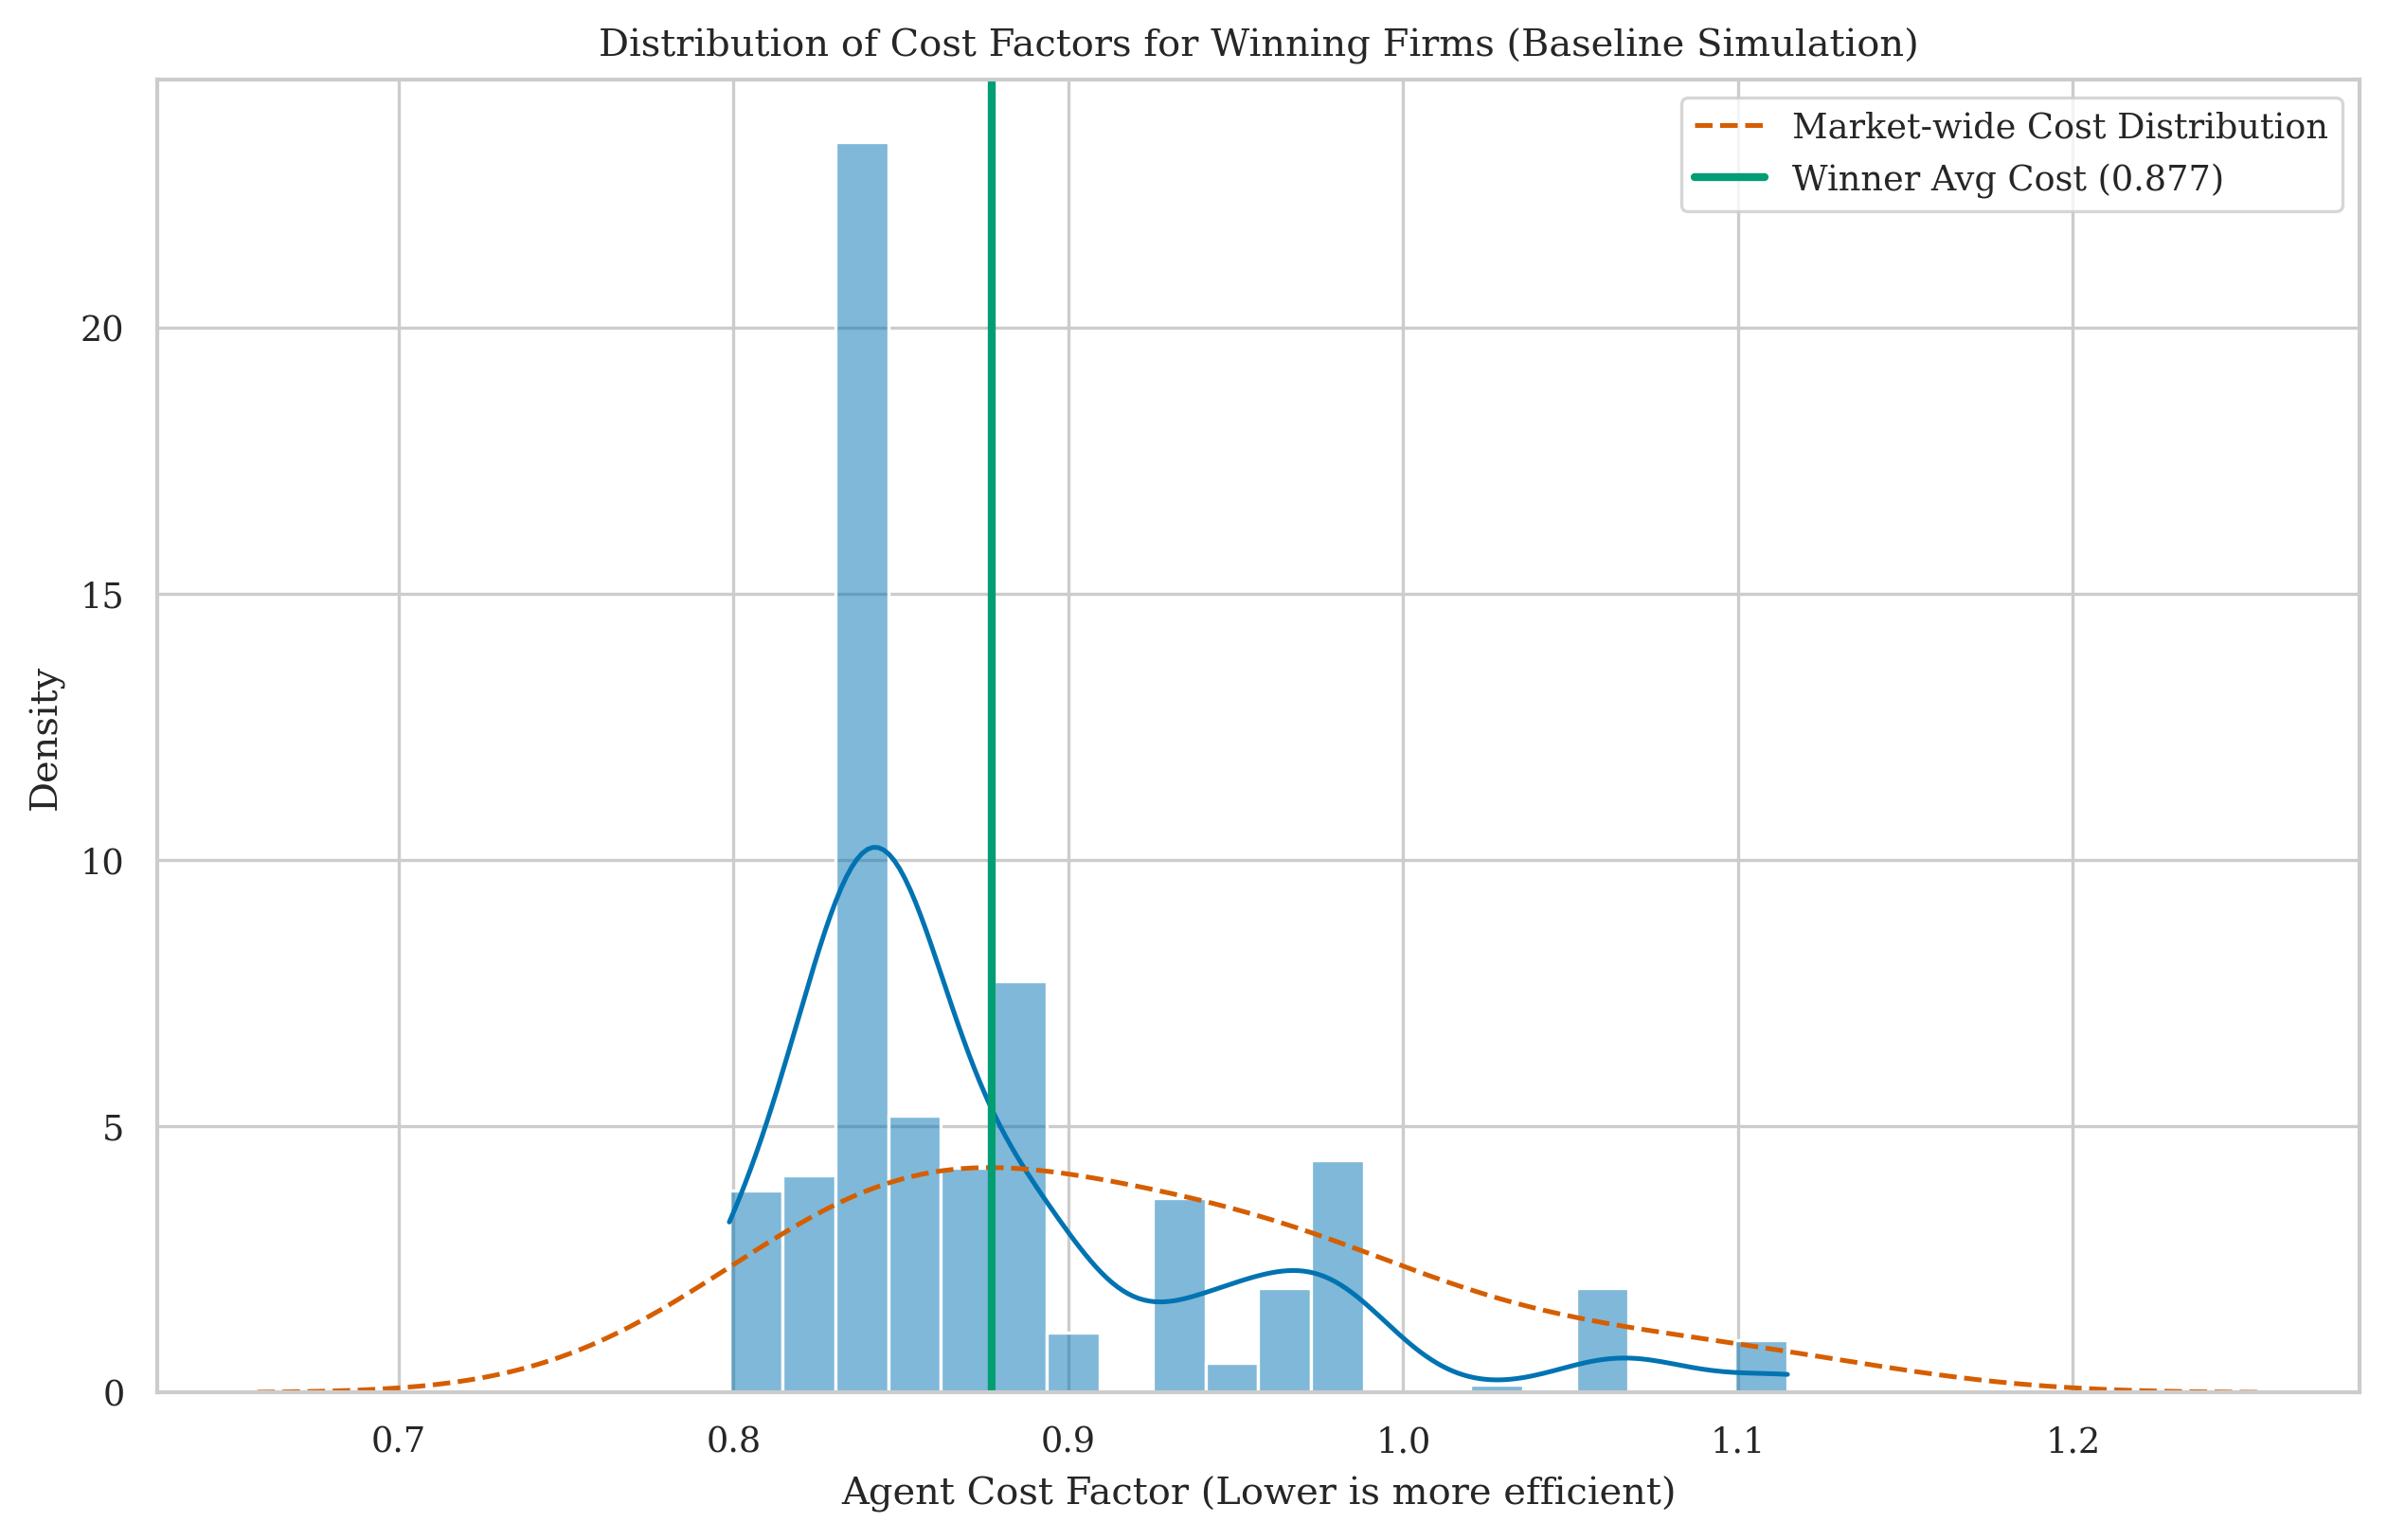

In [118]:
# -----------------------------------------------------------------------------
# 4. Analyze and Report Baseline Metrics (No Changes Needed)
# -----------------------------------------------------------------------------
results_df_baseline = pd.DataFrame(simulation_results)
print("\n--- Baseline Market Equilibrium Analysis (GPU-Optimized) ---")
avg_markup = results_df_baseline['winning_markup'].mean()
print(f"1. Average Winning Markup (over private cost): {avg_markup:.2%}")
avg_winner_cost = results_df_baseline['winner_cost_factor'].mean()
print(f"2. Average Cost Factor of Winning Firms: {avg_winner_cost:.4f}")
market_share = results_df_baseline['winning_agent_id'].value_counts(normalize=True)
hhi = (market_share**2).sum()
print(f"3. Market Concentration (Herfindahl-Hirschman Index): {hhi:.4f}")
avg_bidders = results_df_baseline['num_bidders'].mean()
print(f"4. Average Bidders per Tender: {avg_bidders:.2f}")

baseline_metrics = {
    'avg_markup': avg_markup, 'avg_winner_cost': avg_winner_cost,
    'hhi': hhi, 'avg_bidders': avg_bidders
}
print("\nBaseline equilibrium metrics have been calculated and stored.")

plt.figure(figsize=(10, 6))
sns.histplot(results_df_baseline['winner_cost_factor'], kde=True, bins=20, stat="density")
sns.kdeplot(cost_factors, color='r', linestyle='--', label=f'Market-wide Cost Distribution')
plt.title('Distribution of Cost Factors for Winning Firms (Baseline Simulation)')
plt.xlabel('Agent Cost Factor (Lower is more efficient)')
plt.ylabel('Density')
plt.axvline(avg_winner_cost, color='g', linestyle='-', lw=2, label=f'Winner Avg Cost ({avg_winner_cost:.3f})')
plt.legend()
plt.show()